<a href="https://www.kaggle.com/code/mrbhanuka/recognize-doctor-s-handwritten-prescription?scriptVersionId=264249728" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<center>
    <img src="https://github.com/mrbhanukab/Dr.Handwritten_Recognizer/blob/main/static/init.webp?raw=true" alt="Initialization: Libraries, Logging & Config"/>
</center>
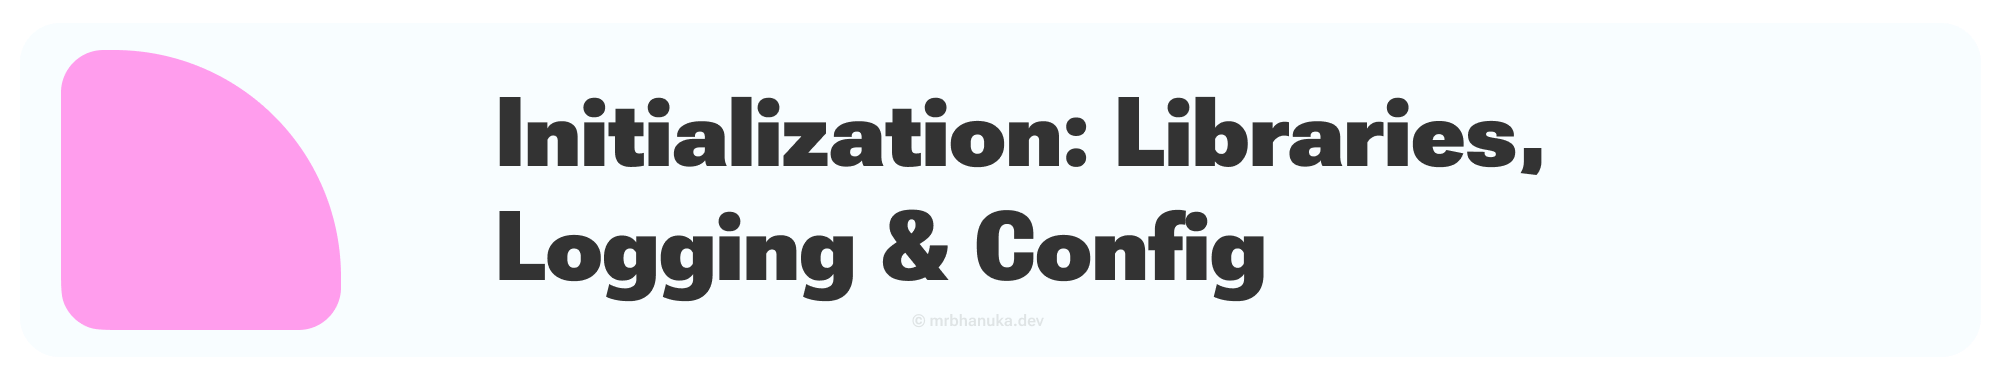
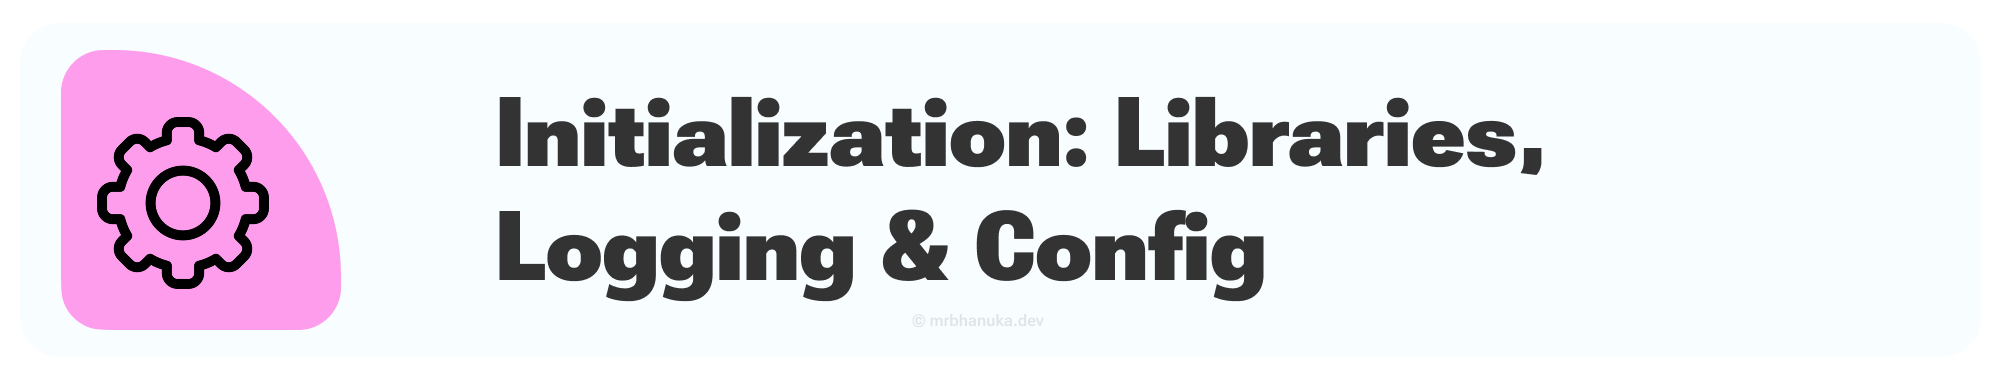
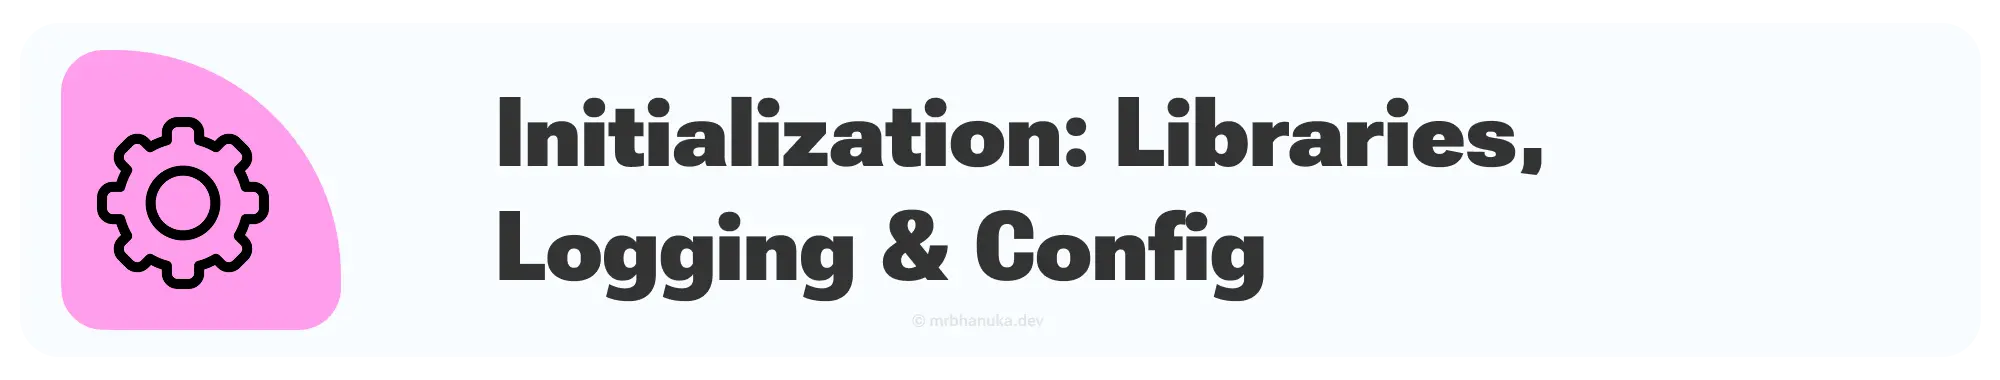
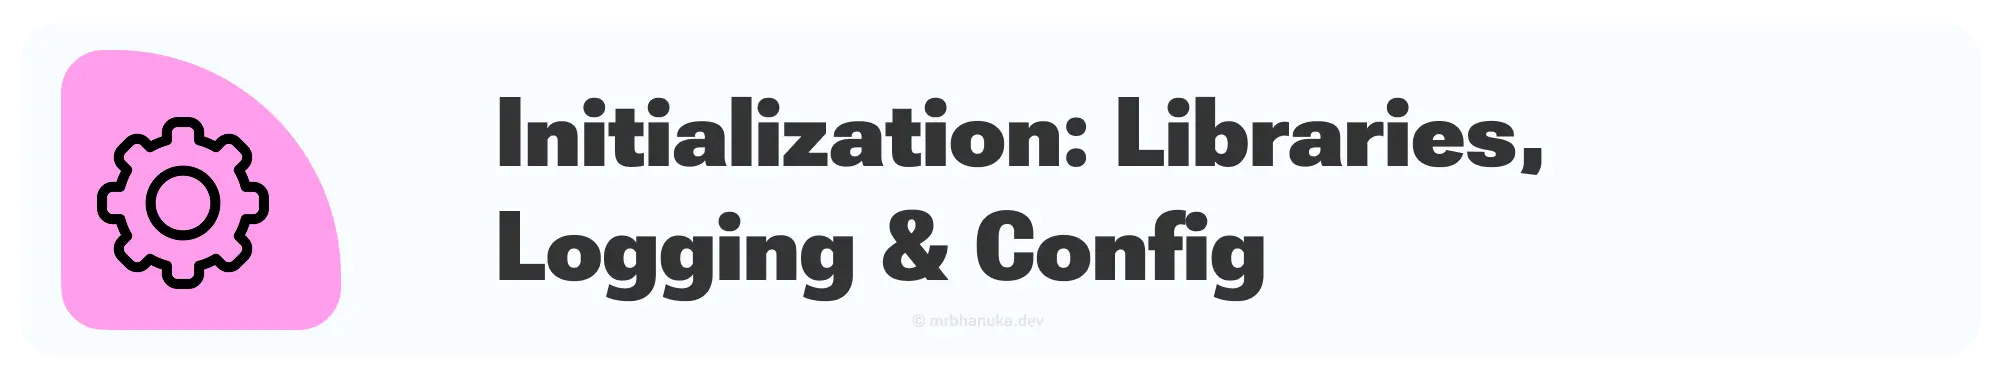
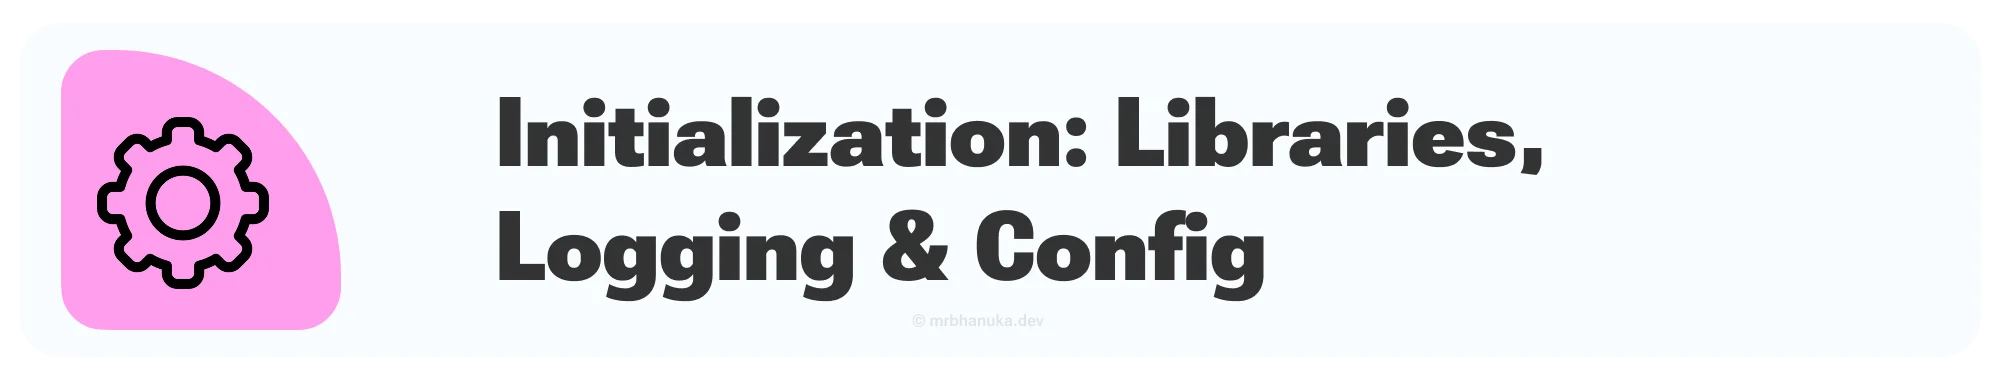
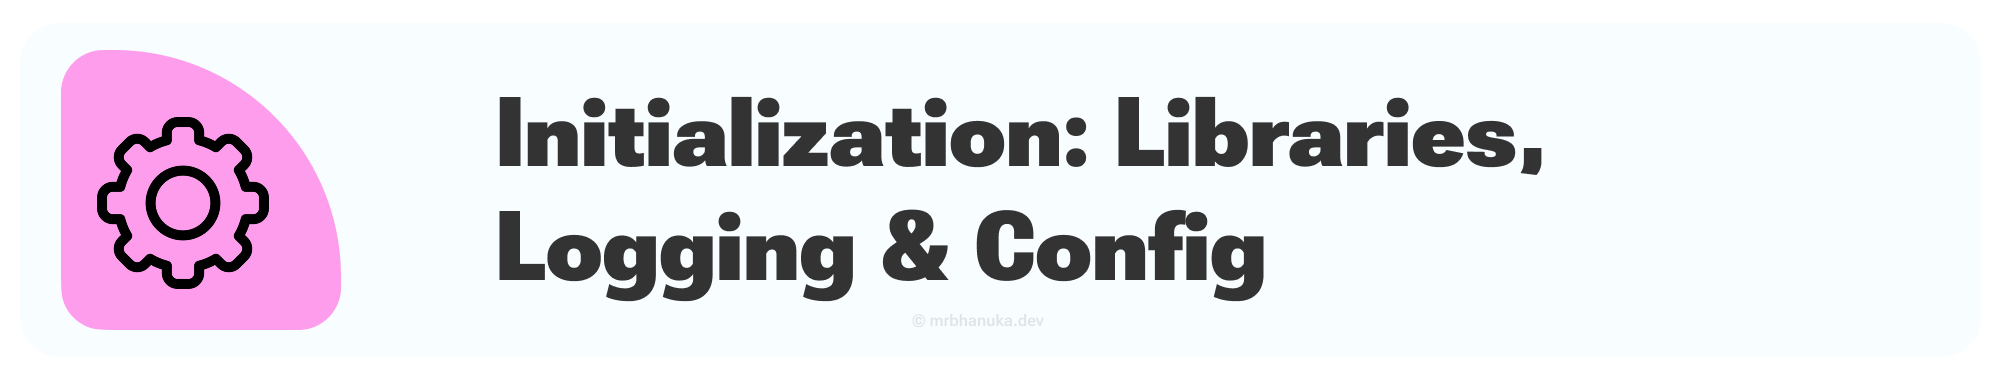

In [3]:
import importlib, subprocess, sys
from tqdm.notebook import tqdm

packages = ["spandrel", "blake3"]

def is_installed(pkg):
    try:
        importlib.import_module(pkg)
        return True
    except Exception:
        return False

missing = [p for p in packages if not is_installed(p)]
if not missing:
    print("All packages already installed:", ", ".join(packages))
else:
    print("Installing:", ", ".join(missing))
    for pkg in tqdm(missing, desc="pip install", unit="pkg"):
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, stdin=subprocess.DEVNULL)
    # re-import / verify
    not_installed = [p for p in packages if not is_installed(p)]
    if not_installed:
        raise SystemError("Some packages failed to install: " + ", ".join(not_installed))

Installing: spandrel, blake3


pip install:   0%|          | 0/2 [00:00<?, ?pkg/s]

In [4]:
import logging
import os
import time
import threading
import requests
import warnings
import random
from collections import defaultdict, Counter
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path
from threading import Lock

import blake3
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from matplotlib import colors
from matplotlib.colors import ListedColormap, to_hex
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.color import lab2rgb, rgb2lab
from spandrel import ModelLoader
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

In [5]:
logger = logging.getLogger('logger')
logger.setLevel(logging.INFO)

# Create a file handler that logs messages to log.txt
log_file_handler = logging.FileHandler('log.txt')
log_file_handler.setLevel(logging.DEBUG)

# Create a formatter and set it for the file handler
log_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
log_file_handler.setFormatter(log_formatter)

# Add the file handler to the logger
logger.addHandler(log_file_handler)

In [6]:
base_hex = ["#FF9D9F", "#9DC4FF", "#FFC39D", "#BCF7FF", "#D0BCFF", "#D8FFC5", "#E59DFF", "#FFFDBC"]

def hex_to_rgb01(h):
    return np.array(colors.to_rgb(h))  # 0..1

# convert base to Lab
base_rgb = np.stack([hex_to_rgb01(h) for h in base_hex], axis=0)[None, ...]  # shape (1, n, 3)
base_lab = rgb2lab(base_rgb)[0]  # shape (n,3)

def build_expanded_palette(n_colors=10):
    # param t over [0,1] across the base colors
    t_base = np.linspace(0, 1, len(base_lab))
    t_new = np.linspace(0, 1, n_colors)
    # interpolate L,a,b channels
    L = np.interp(t_new, t_base, base_lab[:, 0])
    a = np.interp(t_new, t_base, base_lab[:, 1])
    b = np.interp(t_new, t_base, base_lab[:, 2])
    lab_new = np.stack([L, a, b], axis=1)[None, ...]  # shape (1, n_colors, 3)
    rgb_new = lab2rgb(lab_new)[0]  # may be slightly out of 0..1; clip
    rgb_new = np.clip(rgb_new, 0, 1)
    hex_new = [to_hex(tuple(c)) for c in rgb_new]
    return hex_new

In [7]:
# configs
expanded = build_expanded_palette()
color_map = ListedColormap(expanded, name="m3e")
color_palette = list(color_map.colors)
FIG_BG_COLOR = "#F8FDFF"

<center>
    <img src="https://raw.githubusercontent.com/mrbhanukab/Dr.Handwritten_Recognizer/refs/heads/main/static/pipe.webp" alt="Data Pipeline"/>
    <h5>The variable <code>data_pipeline_status</code> is used to track the status of each step in the data pipeline, where each boolean value represents the success of a specific step; <u>a step can only proceed if the previous one is marked as <code>True</code></u>, ensuring a structured and reliable workflow.</h5>
</center>
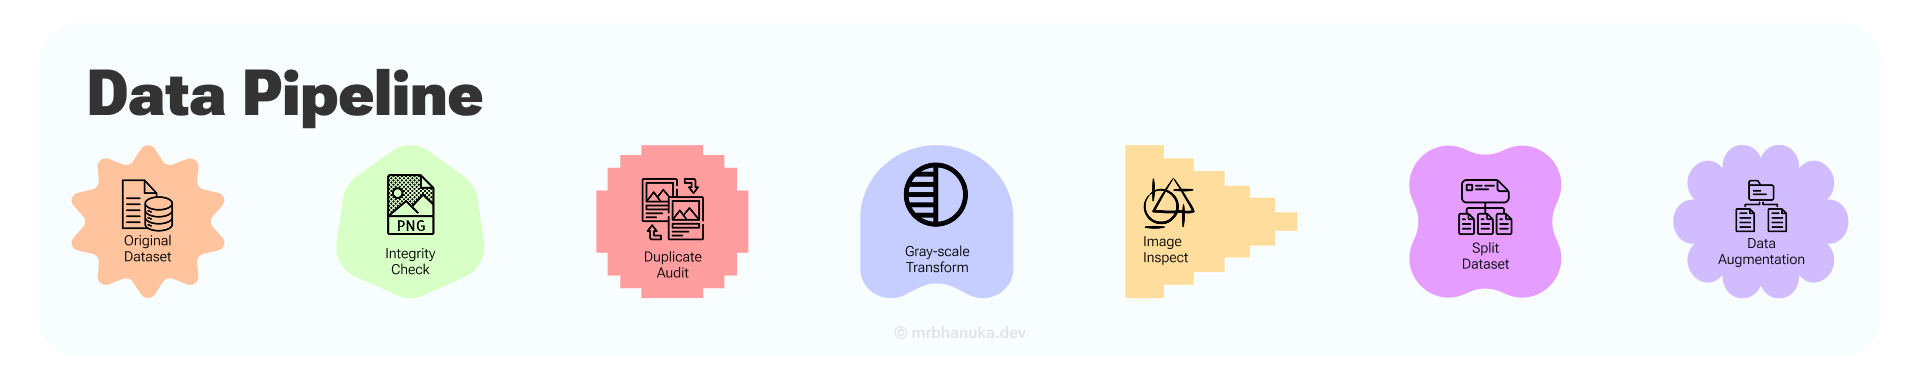
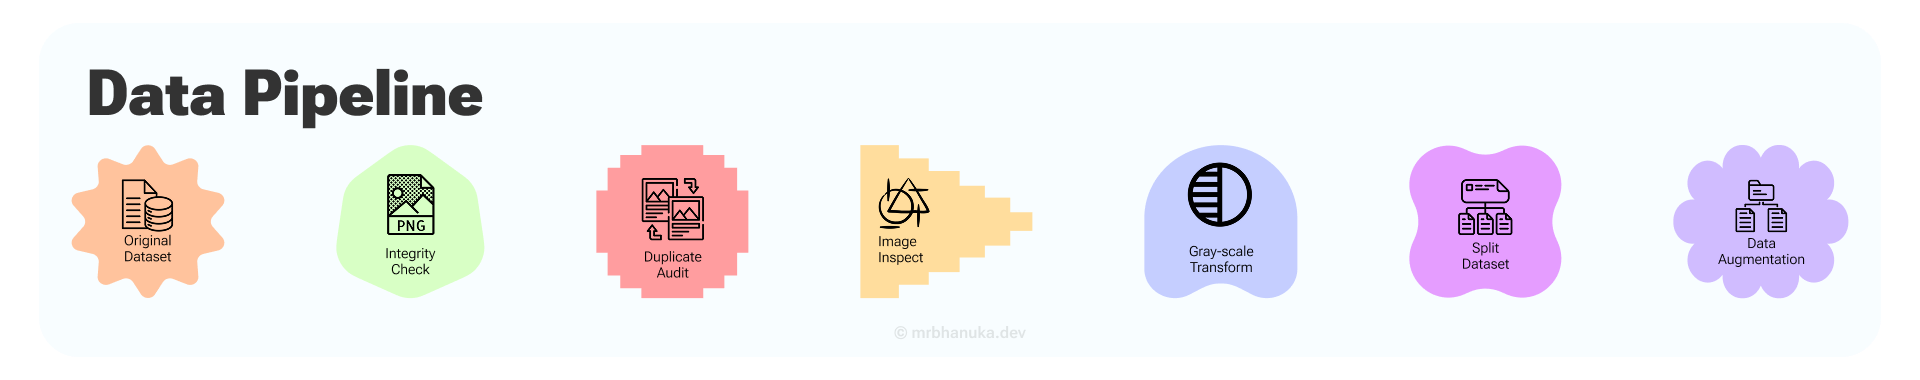
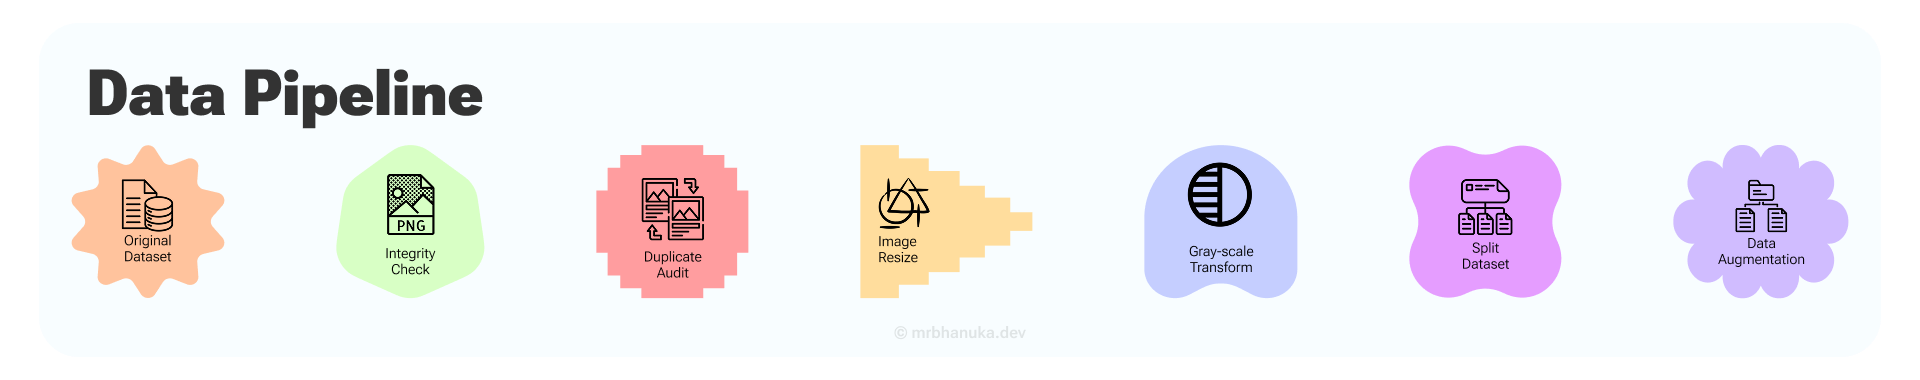
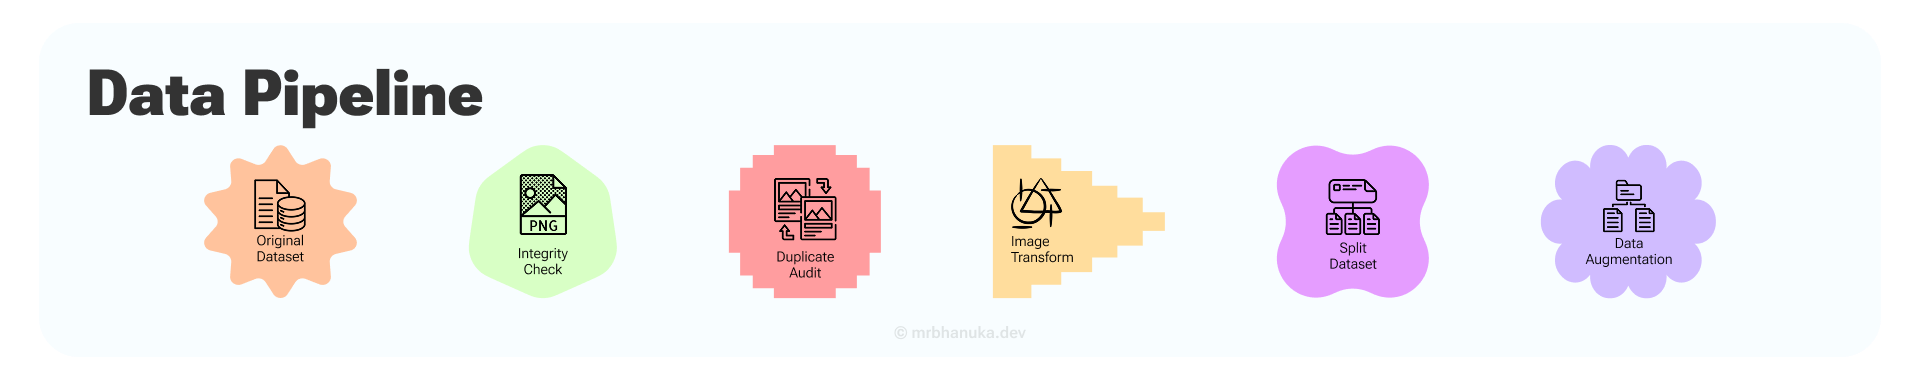
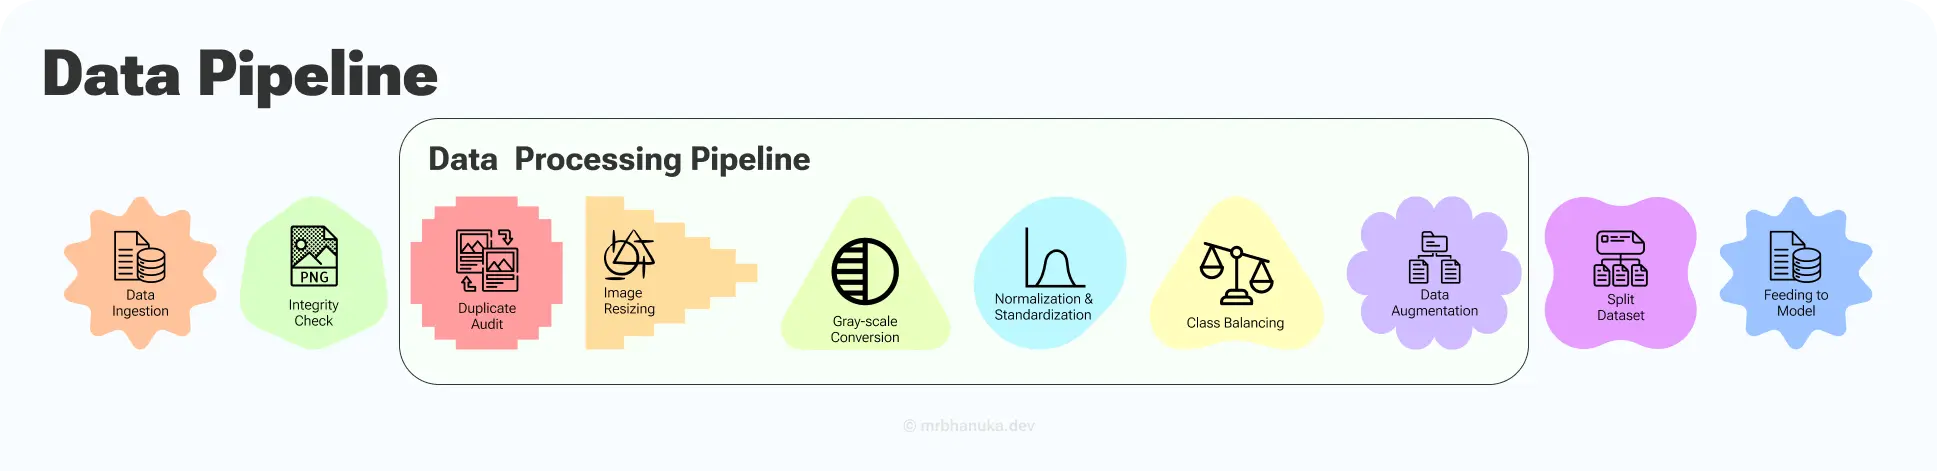
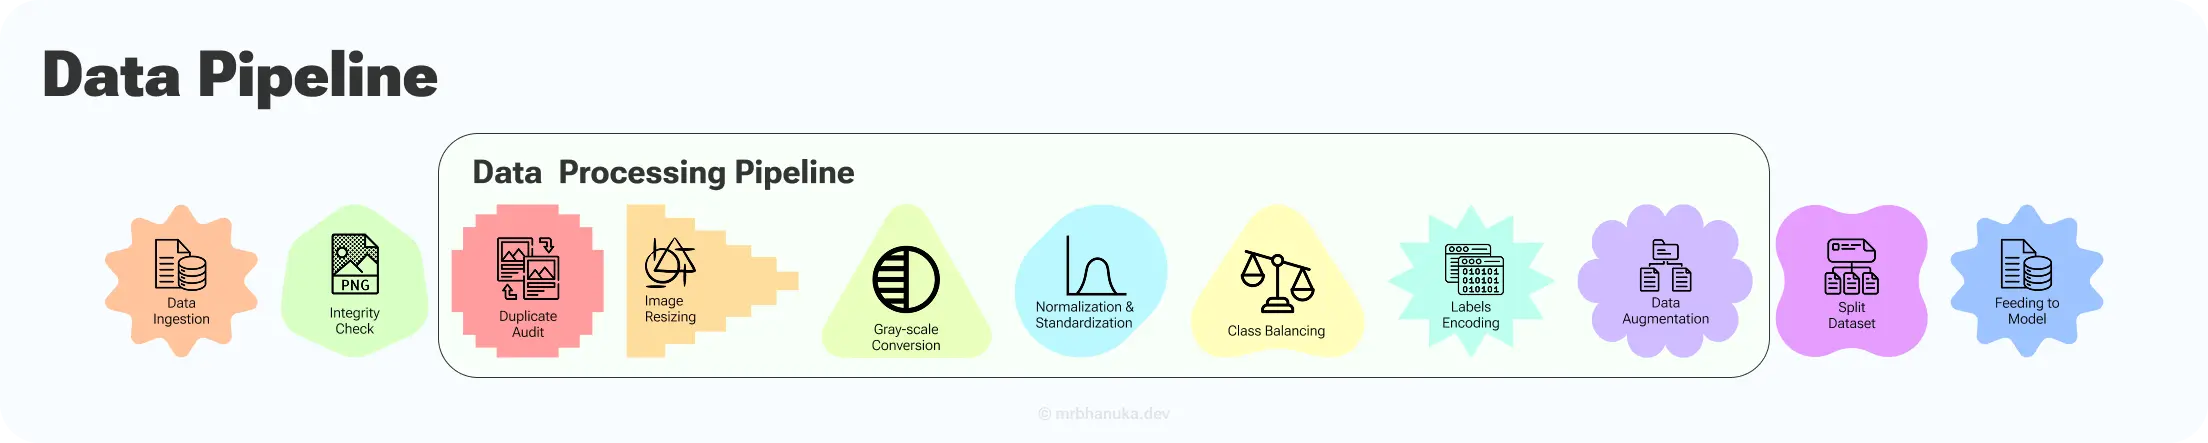
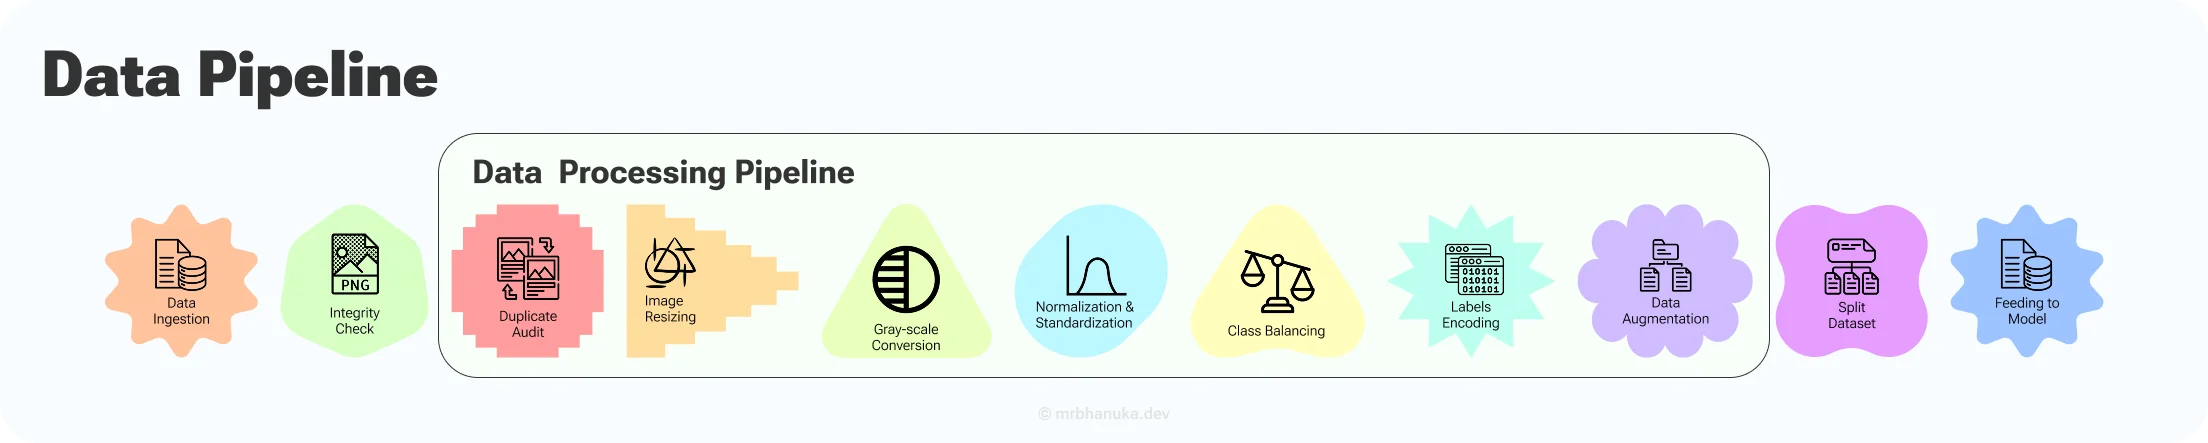
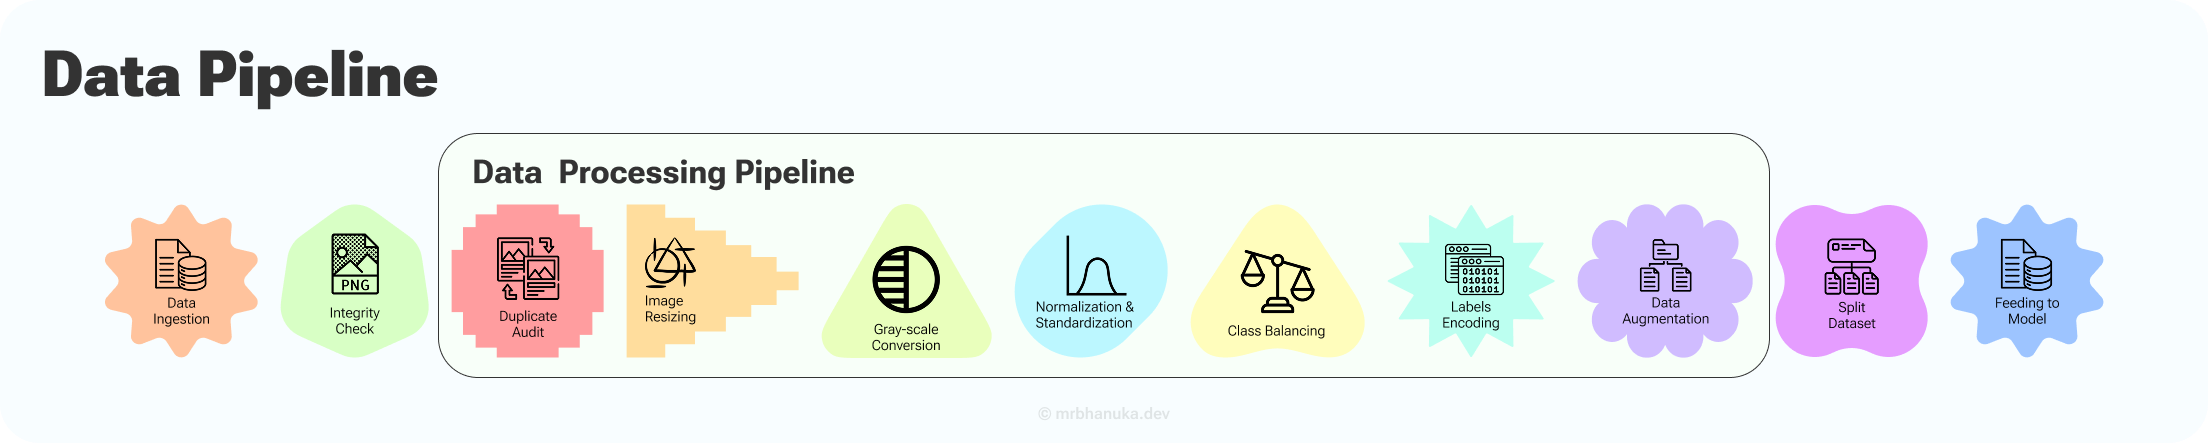
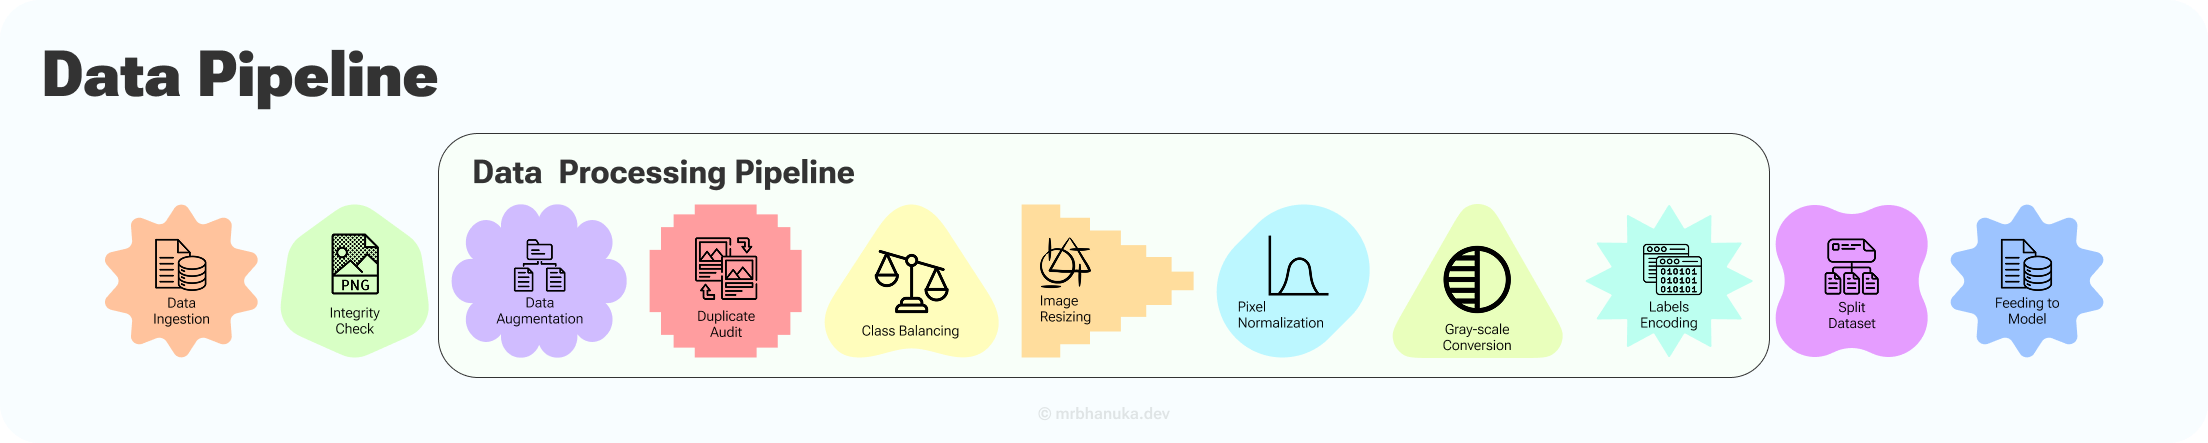

In [8]:
data_pipeline_status = [False] * 6

<center>
<table>
    <tr>
        <td><img src="https://github.com/mrbhanukab/Dr.Handwritten_Recognizer/blob/main/static/data.webp?raw=true" alt="Data Ingestion" /></td>
        <td>
            <h5>This dataset was initially created for research by Mia et al. (2024)<a href="#ref1">[1]</a>,<a href="#ref2">[2]</a>, in which a deep neural network model was used to recognize Bangladeshi doctors’ handwritten prescriptions.</h5>
            <ul>
                <li>Nearly 500 handwritten prescriptions were collected from various healthcare facilities across Bangladesh. </li>
                <li>Each prescription was manually cropped to isolate only the relevant content (non-medical information was removed).</li>
                <li>The cropped images were sharpened to improve clarity.</li>
                <li>A specialized word-detection algorithm was used to segment each prescription into individual words.</li>
                <li>Each word image was manually labeled with the corresponding medicine name using visual inspection; labels were cross-checked for correctness.</li>
            </ul>
            <h5>Dataset summary:</h5>
            <ul>
                <li>Contains 4,680 images.</li>
                <li>Covers 78 unique medicine classes.</li>
            </ul>
        </td>
    </tr>
</table>
</center>
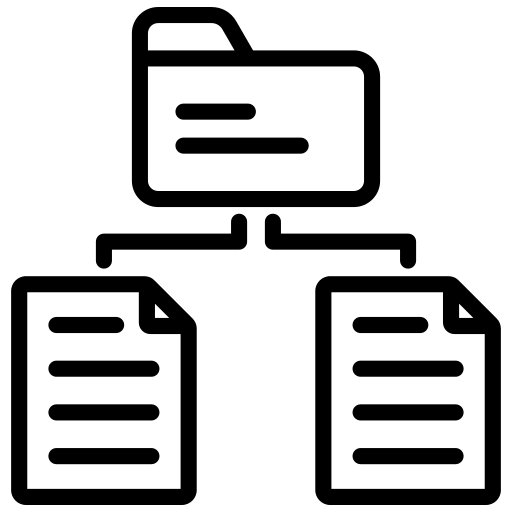
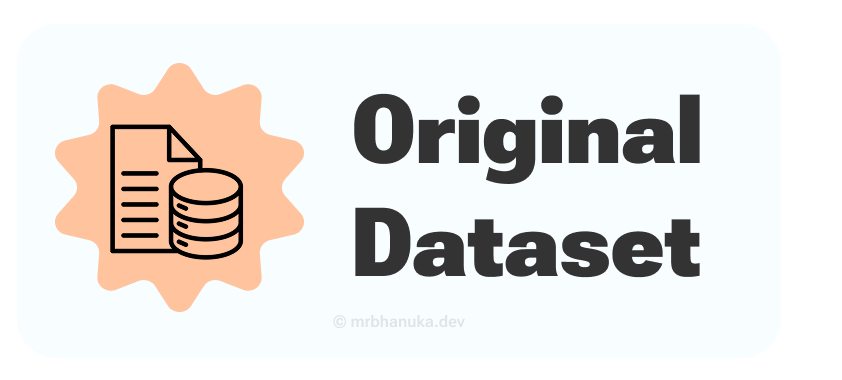
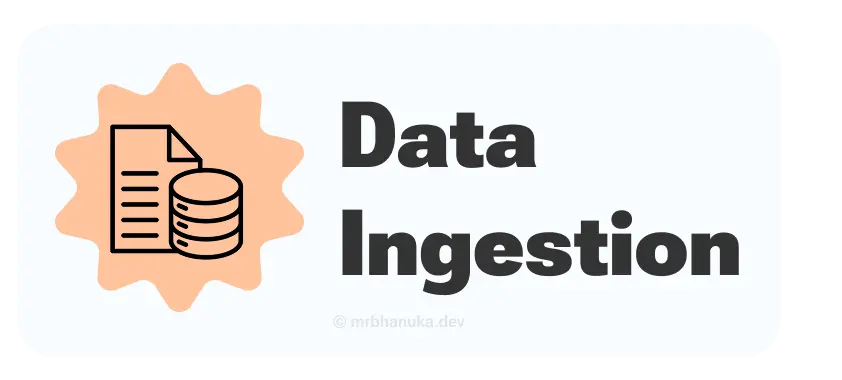
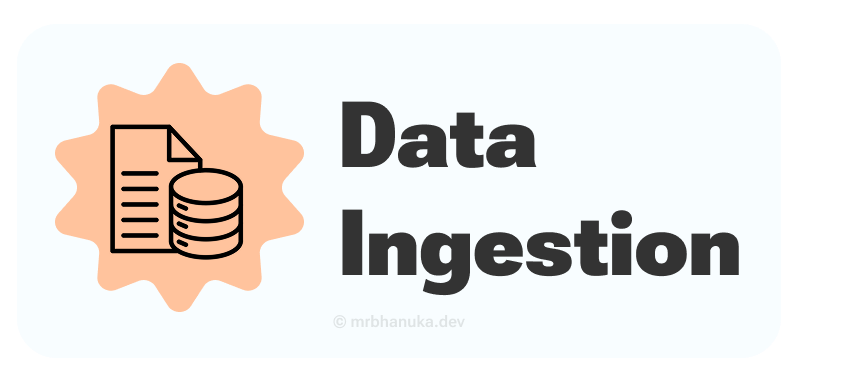

In [9]:
ORIGINAL_DATASET_BASE = "/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset"

original_dataset_training = pd.read_csv(Path(ORIGINAL_DATASET_BASE) / "Training" / "training_labels.csv")
original_dataset_testing = pd.read_csv(Path(ORIGINAL_DATASET_BASE) / "Testing" / "testing_labels.csv")
original_dataset_validation = pd.read_csv(Path(ORIGINAL_DATASET_BASE) / "Validation" / "validation_labels.csv")

# prepend full path to IMAGE filenames
original_dataset_training['IMAGE'] = original_dataset_training['IMAGE'].astype(str).apply(
    lambda p: str(Path(ORIGINAL_DATASET_BASE) / "Training" / "training_words" / p) if not (p.startswith("/") or p.startswith("..") or "://" in p) else p)
original_dataset_testing['IMAGE'] = original_dataset_testing['IMAGE'].astype(str).apply(
    lambda p: str(Path(ORIGINAL_DATASET_BASE) / "Testing" / "testing_words" / p) if not (p.startswith("/") or p.startswith("..") or "://" in p) else p)
original_dataset_validation['IMAGE'] = original_dataset_validation['IMAGE'].astype(str).apply(
    lambda p: str(Path(ORIGINAL_DATASET_BASE) / "Validation" / "validation_words" / p) if not (p.startswith("/") or p.startswith("..") or "://" in p) else p)

original_dataset = pd.concat([original_dataset_training,original_dataset_testing,original_dataset_validation], ignore_index=True)
original_dataset = original_dataset.drop_duplicates()

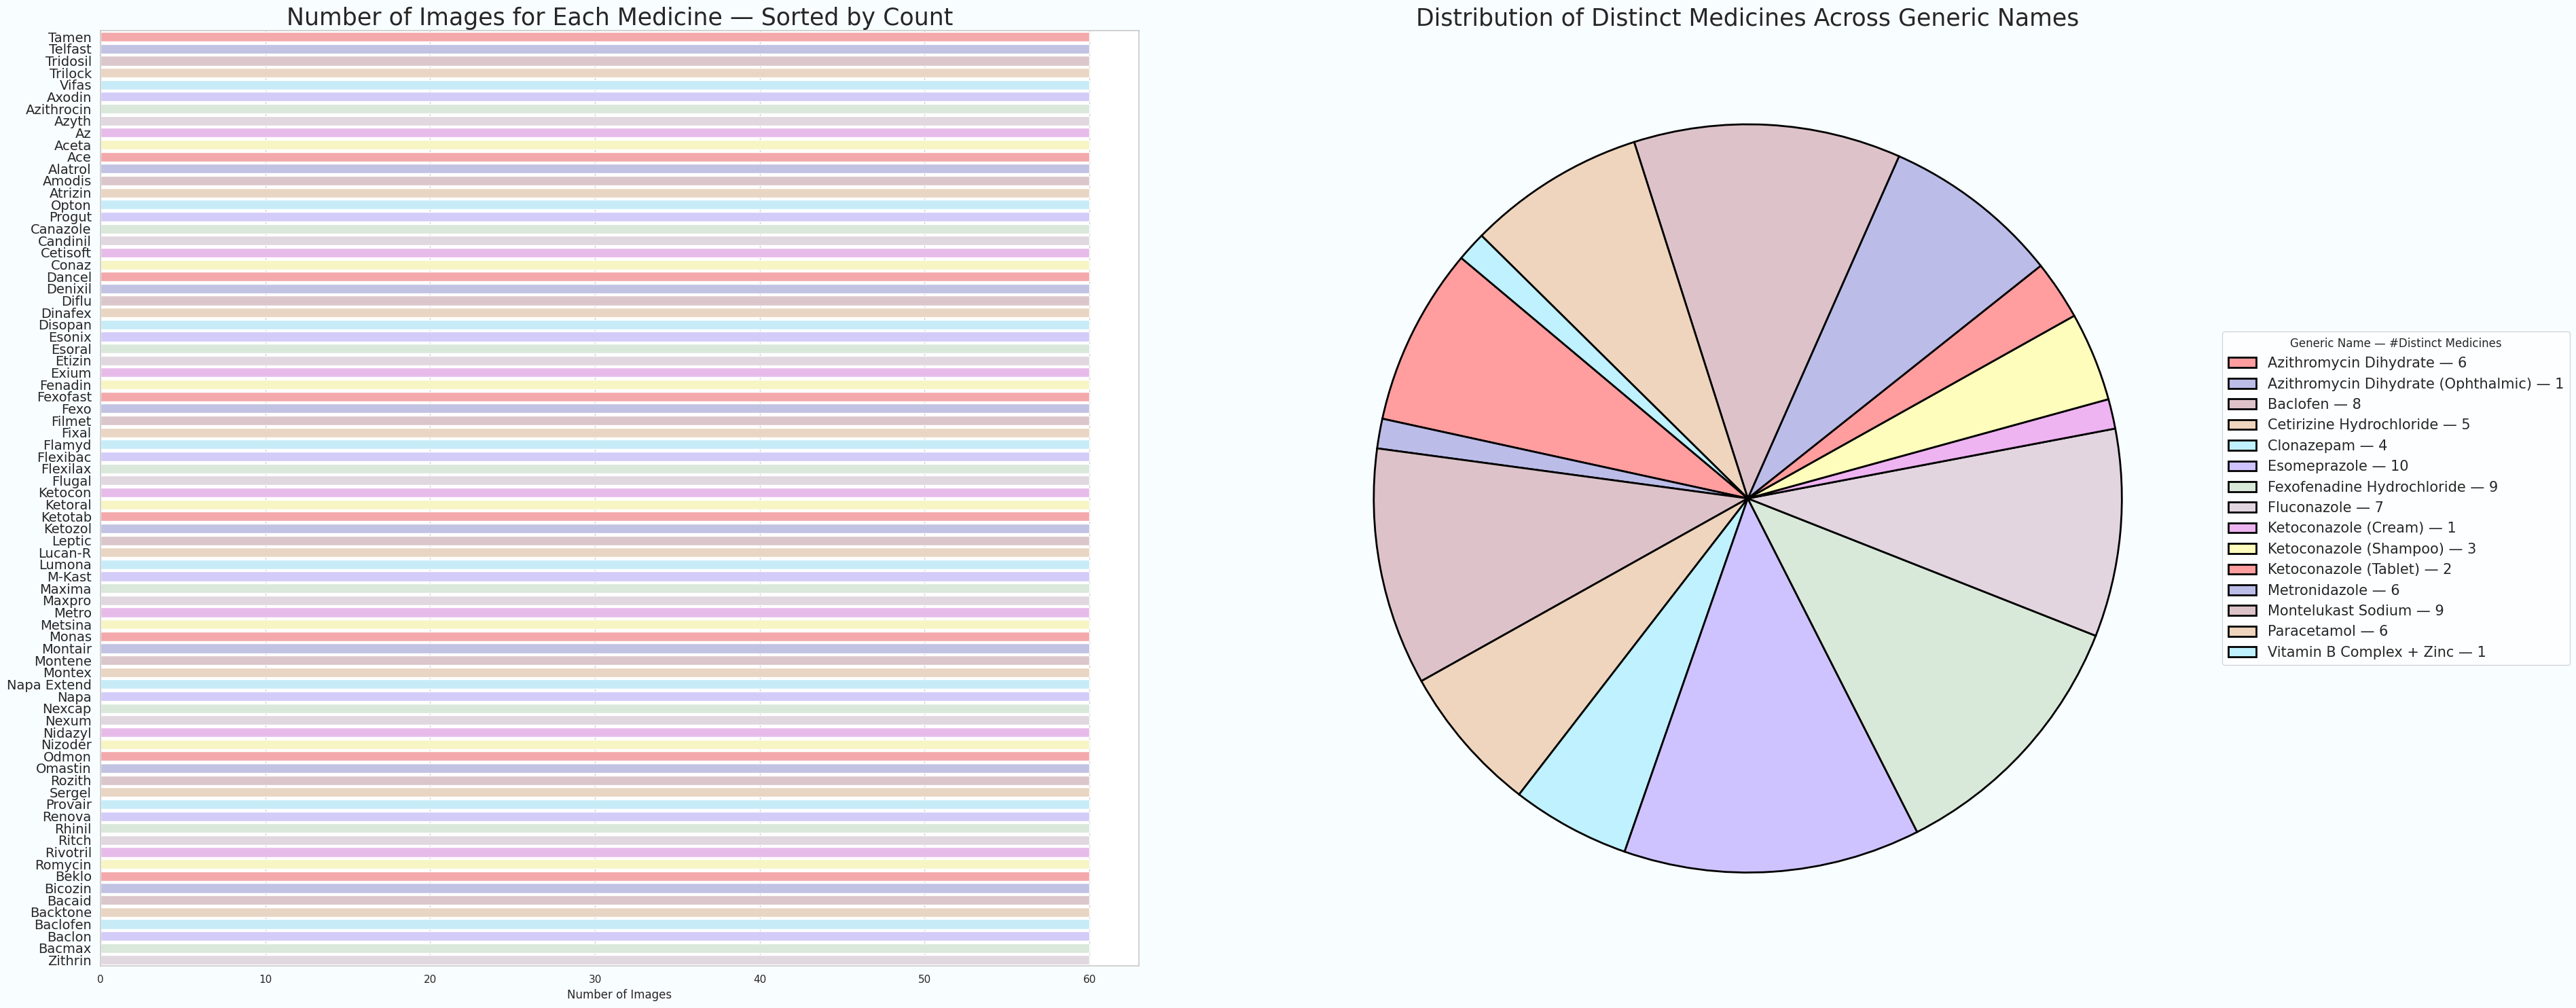

In [10]:
sns.set_theme(style='whitegrid', context='notebook')

fig, axes = plt.subplots(ncols=2, figsize=(40, 15), gridspec_kw={'width_ratios':[2, 3]})
fig.patch.set_facecolor(FIG_BG_COLOR)

# Left: sorted horizontal bar chart for MEDICINE_NAME
sns.barplot(x='count', y='MEDICINE_NAME', data=original_dataset['MEDICINE_NAME'].value_counts().reset_index().sort_values('count', ascending=True) , ax=axes[0], palette=color_palette)
axes[0].set_title('Number of Images for Each Medicine — Sorted by Count', fontsize=25)
axes[0].set_xlabel('Number of Images')
axes[0].set_ylabel('')
axes[0].tick_params(axis='y', labelsize=14)

# Right: pie chart for all GENERIC_NAME
medicines_per_generic_name = original_dataset.groupby('GENERIC_NAME')['MEDICINE_NAME'].nunique().reset_index()
labels = medicines_per_generic_name['GENERIC_NAME']
sizes = medicines_per_generic_name['MEDICINE_NAME']

axes[1].pie(sizes, labels=None, colors=[color_map(i % color_map.N) for i in range(len(labels))], startangle=140,
            wedgeprops={'edgecolor': 'black', 'linewidth': 2})
axes[1].set_title('Distribution of Distinct Medicines Across Generic Names', fontsize=25)

legend_labels = [f"{n} — {c}" for n, c in zip(labels, sizes)]
axes[1].legend(legend_labels, title='Generic Name — #Distinct Medicines', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)

fig.tight_layout()
plt.show()

<table>
<tr>
    <td><img src="https://github.com/mrbhanukab/Dr.Handwritten_Recognizer/blob/main/static/check.webp?raw=true" alt="Integrity Check" /></td>
    <td>
        <h2>Steps: </h2>
        <table>
            <tr>
                <td>
                    <h3>Check Image Format</h3>
                    <ol>
                        <li>Loop through <code>original_dataset</code></li>
                        <li>Identify non-<code>.png</code> images.</li>
                        <li>Show a pie chart of formats vs. number of images.</li>
                        <li>Log images with other formats in <code>log.txt.</code></li>
                    </ol>
                </td>
                <td>
                    <h3>Check Image Accessibility</h3>
                    <ol>
                        <li>Attempt to open each image.</li>
                        <li>Show a pie chart of accessible vs. inaccessible images.</li>
                        <li>Log inaccessible images in <code>log.txt.</code></li>
                    </ol>
                </td>                
            </tr>
        </table>
    </td>
</tr>
<tr>
    <td colspan="2">
        <h5>The variable <code>manipulated_dataset</code> is created as a copy of the original dataset, allowing for data manipulation and analysis without altering the original data. This approach ensures that we can easily compare the results of any transformations or processing steps against the untouched original dataset, maintaining data integrity throughout the workflow.</h5>
    </td>
</tr>
</table>
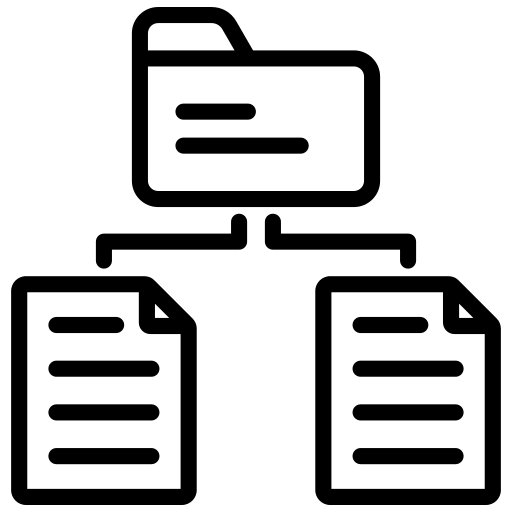
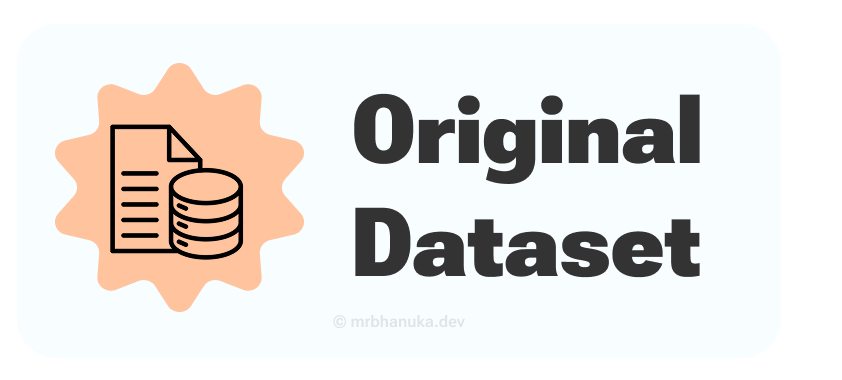
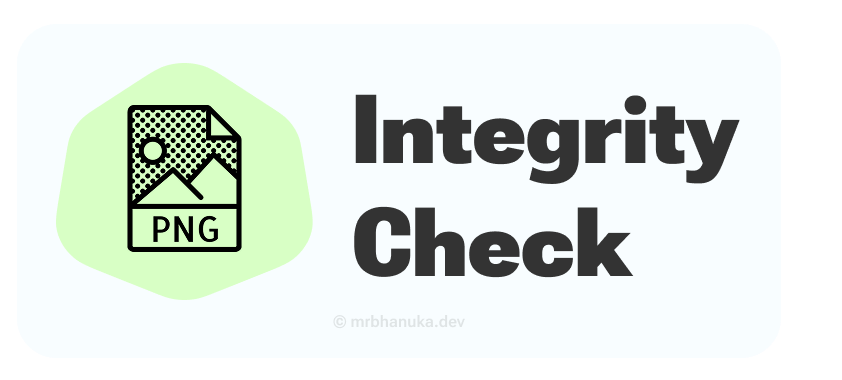
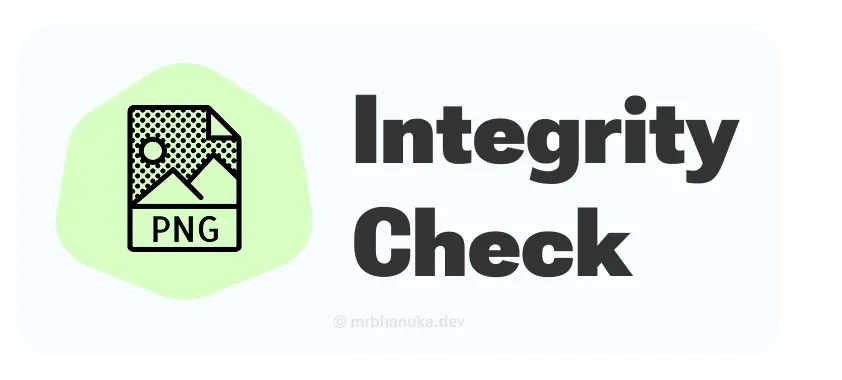
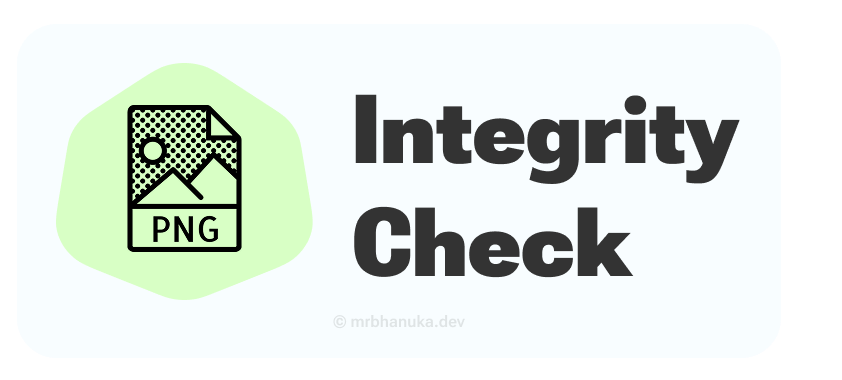

In [11]:
manipulated_dataset = original_dataset.copy()

In [12]:
non_png_images = []

for image in manipulated_dataset["IMAGE"]:
    if not image.lower().endswith('.png'):
        non_png_images.append(image_path)
        logging.warning(f'Non-PNG image found: {img}')

In [13]:
inaccessible_images = []

def check_image_accessibility(image:str)->str:
    # Check if the image file exists
    if not os.path.exists(image):
        logger.warning(f'Inaccessible image found: {image}')
        return image

    # Attempt to open the image
    try:
        with Image.open(image) as img:
            img.verify()
    except (IOError, SyntaxError) as error:
        logger.warning(f'Inaccessible image found: {image} [{error}]')
        return image

with ThreadPoolExecutor() as executor:
    inaccessible_images = [
        img for img in list(executor.map(check_image_accessibility, manipulated_dataset["IMAGE"]))
        if img is not None
    ]

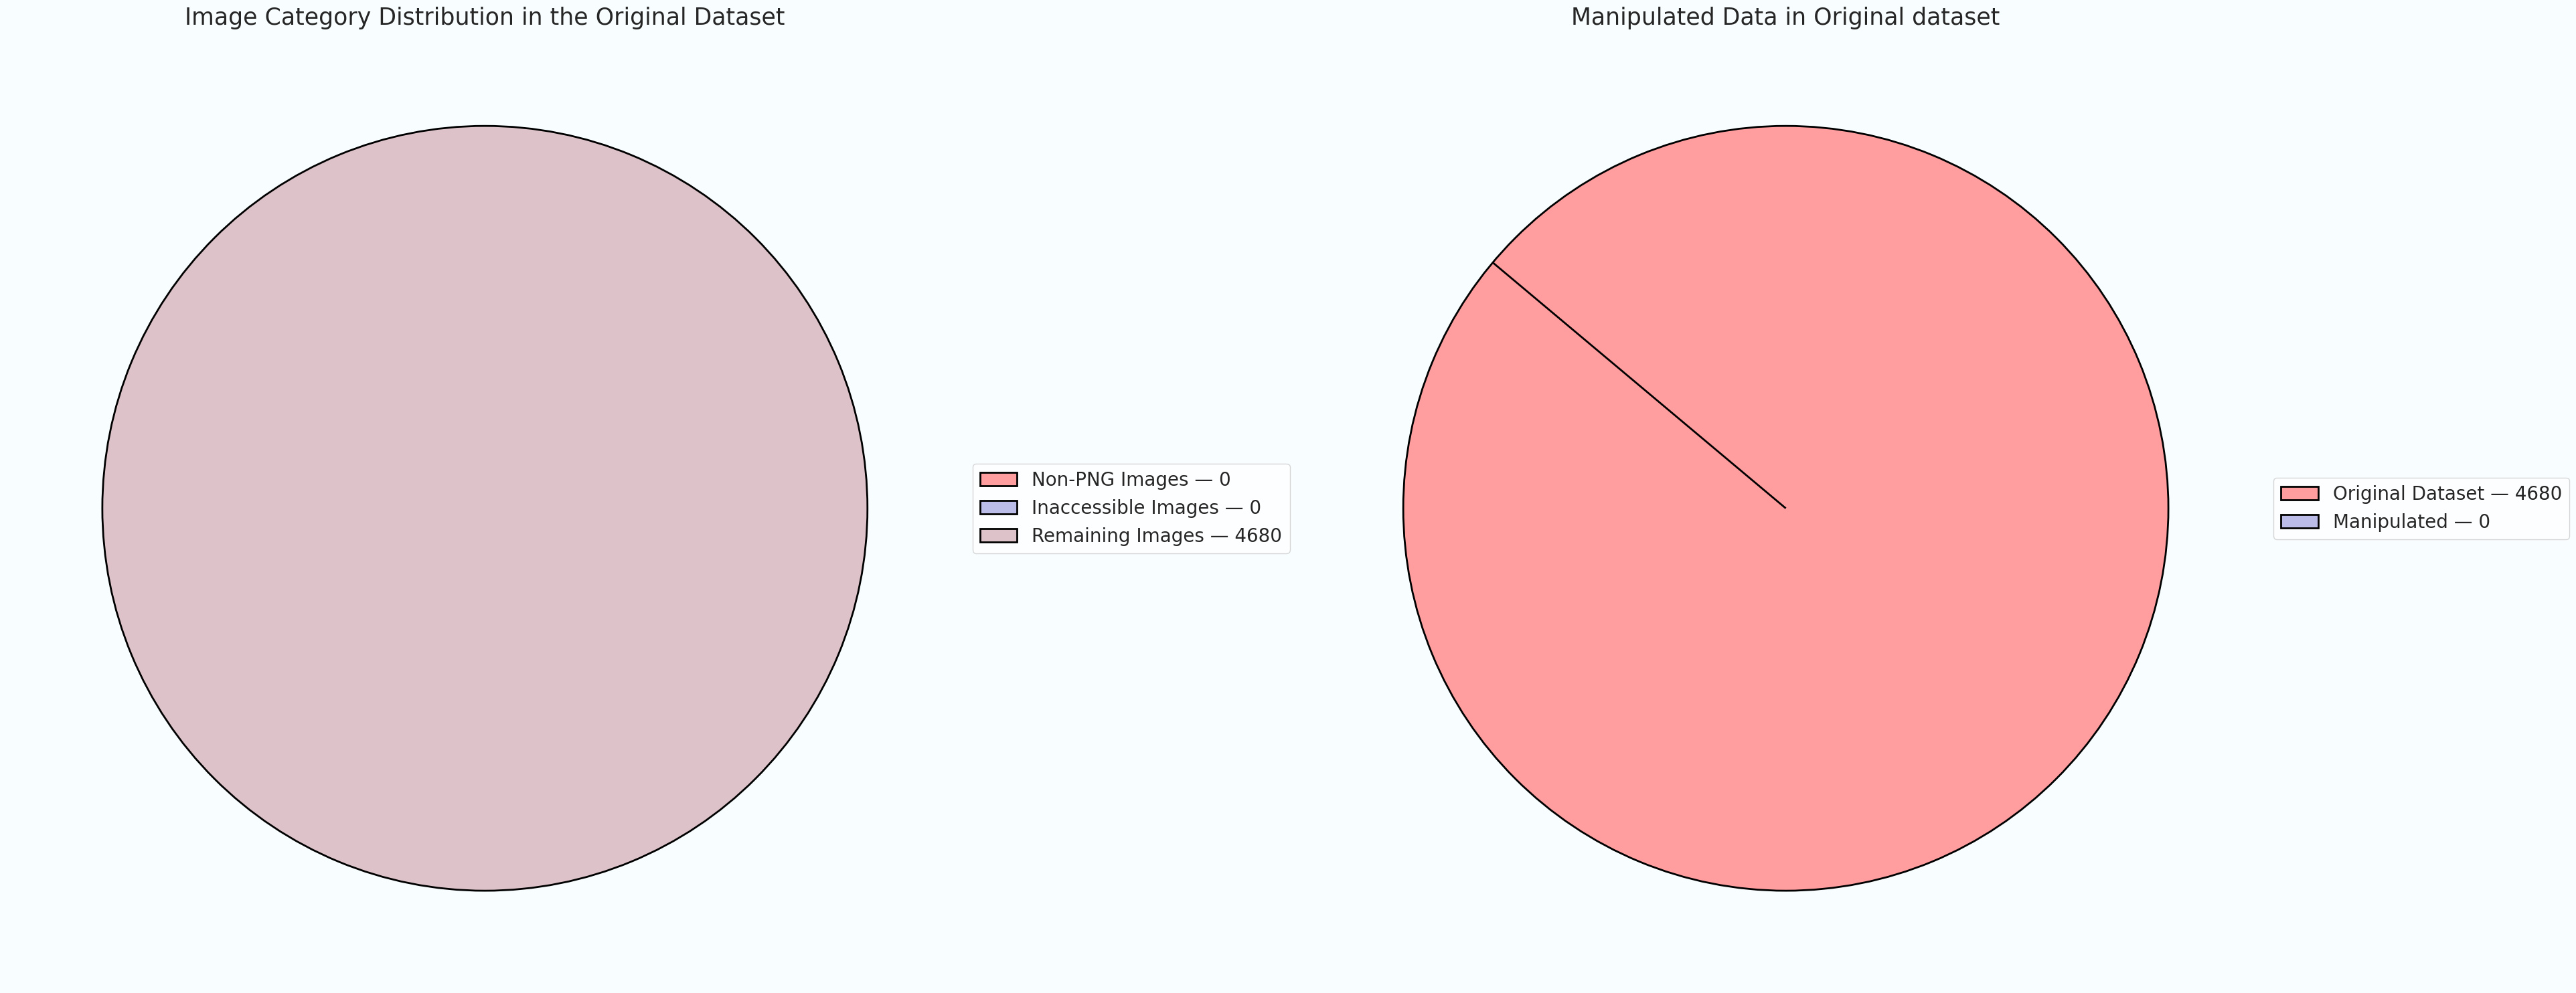

In [14]:
if not (non_png_images or inaccessible_images):
    data_pipeline_status[0] = True
else:
    if non_png_images:
        print("Images in other formats found!")
    if inaccessible_images:
        print("Inaccessible images found!")
    print("Check log.txt for more information.")

fig, axes = plt.subplots(ncols=2, figsize=(40, 15), gridspec_kw={'width_ratios':[1, 1]})
fig.patch.set_facecolor(FIG_BG_COLOR)

# Left: Image Category Distribution in the Original Dataset
labels = ['Non-PNG Images', 'Inaccessible Images', 'Remaining Images']
sizes = [len(non_png_images), len(inaccessible_images), len(original_dataset) - (len(non_png_images)+len(inaccessible_images))]

colors = [color_map(i % color_map.N) for i in range(len(labels))]

axes[0].pie(sizes, labels=None, colors=colors, startangle=140, wedgeprops={'edgecolor': 'black', 'linewidth': 2})
axes[0].set_title('Image Category Distribution in the Original Dataset', fontsize=25)

legend_labels = [f"{n} — {c}" for n, c in zip(labels, sizes)]
axes[0].legend(legend_labels, title='', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)

# Right: Manipulated Data in Original dataset
labels = ['Original Dataset', 'Manipulated']
sizes = [len(original_dataset) - (len(original_dataset) - len(manipulated_dataset)), len(original_dataset) - len(manipulated_dataset)]

colors = [color_map(i % color_map.N) for i in range(len(labels))]

axes[1].pie(sizes, labels=None, colors=colors, startangle=140, wedgeprops={'edgecolor': 'black', 'linewidth': 2})
axes[1].set_title('Manipulated Data in Original dataset', fontsize=25)

legend_labels = [f"{n} — {c}" for n, c in zip(labels, sizes)]
axes[1].legend(legend_labels, title='', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)

fig.tight_layout()
plt.show()

> Because integrity checks confirm all images are PNG and accessible (no broken files), no image-level data cleaning is required. Therefore, the original dataset remains unchanged, as shown by the second pie chart.

<table>
<tr>
    <td><img src="https://github.com/mrbhanukab/Dr.Handwritten_Recognizer/blob/main/static/augment.webp?raw=true" alt="Data Augmentation" /></td>
    <td>
        <h2>Steps: </h2>
        <ol>
            <li>Take each image from <code>manipulated_dataset</code></li>
            <li>Apply a series of <strong>mild transformations</strong> (rotation, shift, light contrast/brightness changes)</li>
            <li>Apply a smaller number of <strong>extreme transformations</strong> (stronger rotations, zoom, shearing, heavy brightness/contrast)</li>
            <li>Collect and save 10 variations of each original image for training</li>
        </ol>
    </td>
</tr>
<tr>
<td colspan="2">
<h2>Why this setup?</h2>
<p>We use <strong>data augmentation</strong> to expose our model to different variations of handwriting, lighting, and distortions, improving its ability to generalize. For each input image, we generate <strong>10 variations</strong>: 6 mild and 4 extreme.</p> 

<p>The idea is that <strong>mild augmentations</strong> represent natural variations a model will most frequently encounter (small shifts, slight brightness changes, minor rotations). By keeping 60% of our augmentations mild, we make sure the model sees these common scenarios often enough to learn stable features.</p> 

<p>The remaining <strong>40% extreme augmentations</strong> simulate challenging conditions such as heavily rotated or poorly lit prescriptions. These serve as a "stress test" for the model, forcing it to learn robust representations without overwhelming it. If all augmentations were extreme, training would become noisy and unstable; if all were mild, the model could overfit. Our 6:4 balance is designed to combine realism with robustness.</p>
</td>
</tr>
</table>
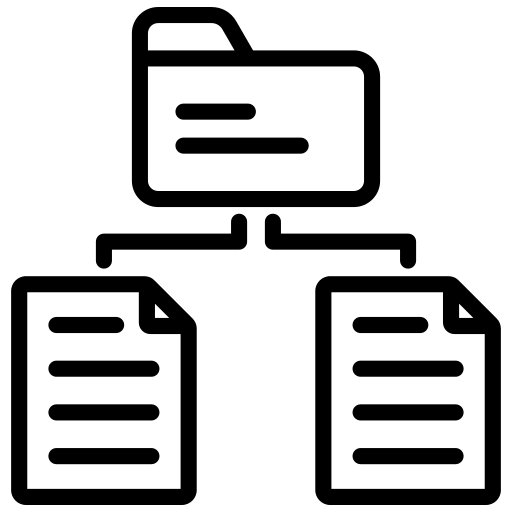
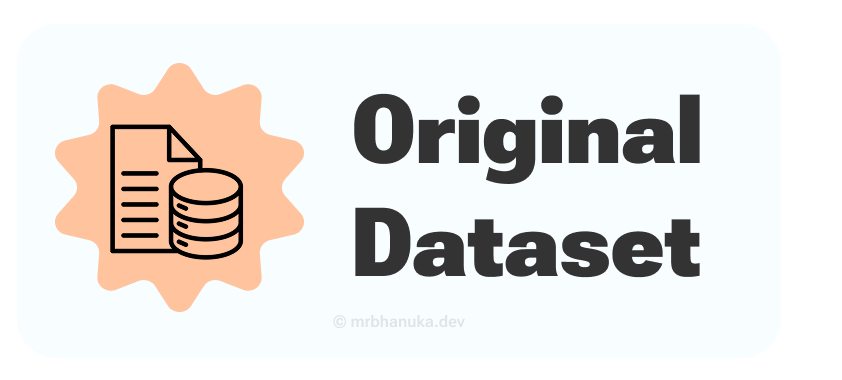
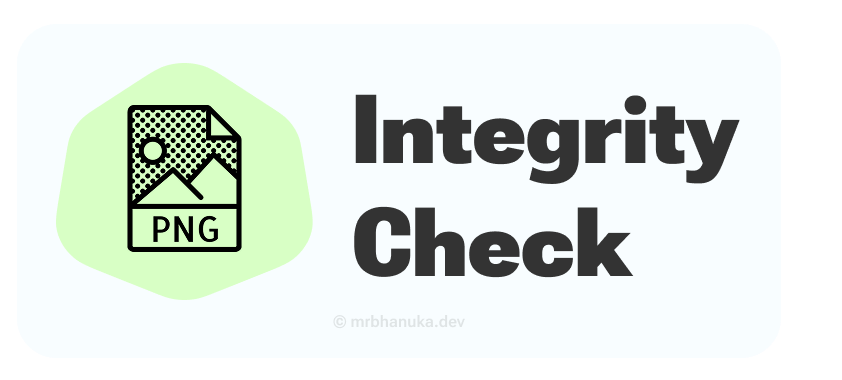
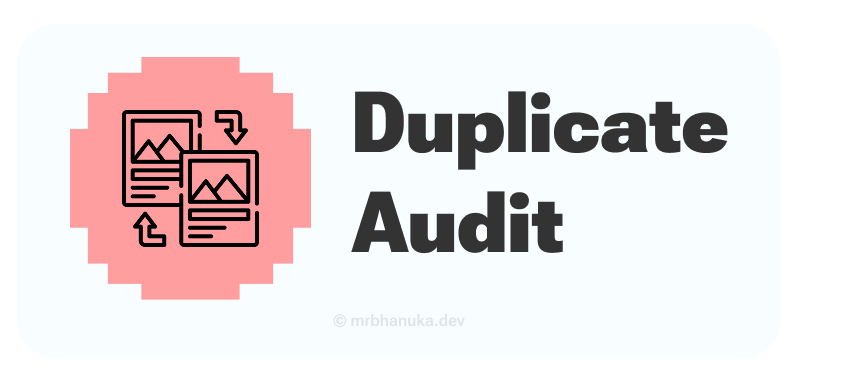
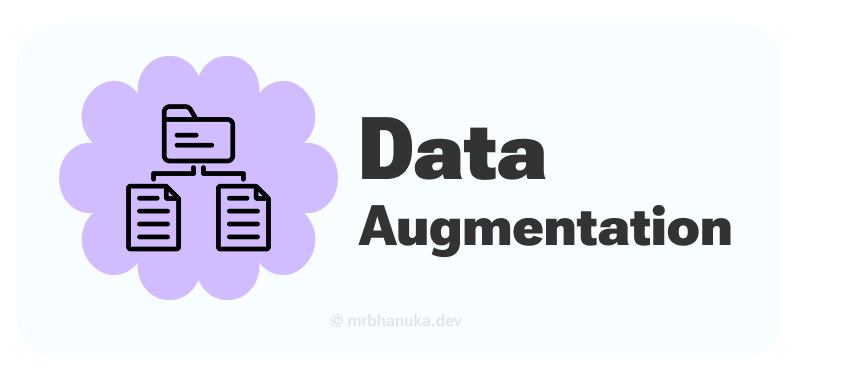

In [15]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean

# Mild augmentations (subtle variations)
mild_augs = transforms.Compose([
    transforms.RandomRotation(5),                              # small rotations
    transforms.RandomAffine(0, translate=(0.05, 0.05)),        # tiny shifts
    transforms.RandomResizedCrop(128, scale=(0.9, 1.0)),       # small crop/zoom
    transforms.ColorJitter(brightness=0.1, contrast=0.1),      # light changes
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2), # light blur
])

# Extreme augmentations (heavy distortions)
extreme_augs = transforms.Compose([
    transforms.RandomRotation(25),                               # bigger rotation
    transforms.RandomAffine(0, translate=(0.25, 0.25), shear=20),# large shifts/shear
    transforms.RandomResizedCrop(128, scale=(0.5, 1.0)),         # aggressive zoom/crop
    transforms.ColorJitter(brightness=0.5, contrast=0.5),        # harsh lighting
    transforms.RandomApply([transforms.GaussianBlur(9)], p=0.5), # strong blur
    transforms.RandomApply([AddGaussianNoise(0., 0.15)], p=0.5),  # heavy noise
    transforms.RandomInvert(p=0.3),                              # invert black/white
    transforms.RandomSolarize(threshold=0.5, p=0.3),             # thresholding-like effect
])

# Augmentation function
def augment_image(image, total=10, extreme_count=4):
    augmented_images = []

    # Convert image to tensor
    image_tensor = transforms.ToTensor()(image)

    def mild():
        return mild_augs(image_tensor)

    def extreme():
        return extreme_augs(image_tensor)

    tasks = [mild] * (total - extreme_count) + [extreme] * extreme_count
    random.shuffle(tasks)  # mix mild and extreme

    with ThreadPoolExecutor(max_workers=min(total, 8)) as executor:
        augmented_images = list(executor.map(lambda f: f(), tasks))

    return augmented_images

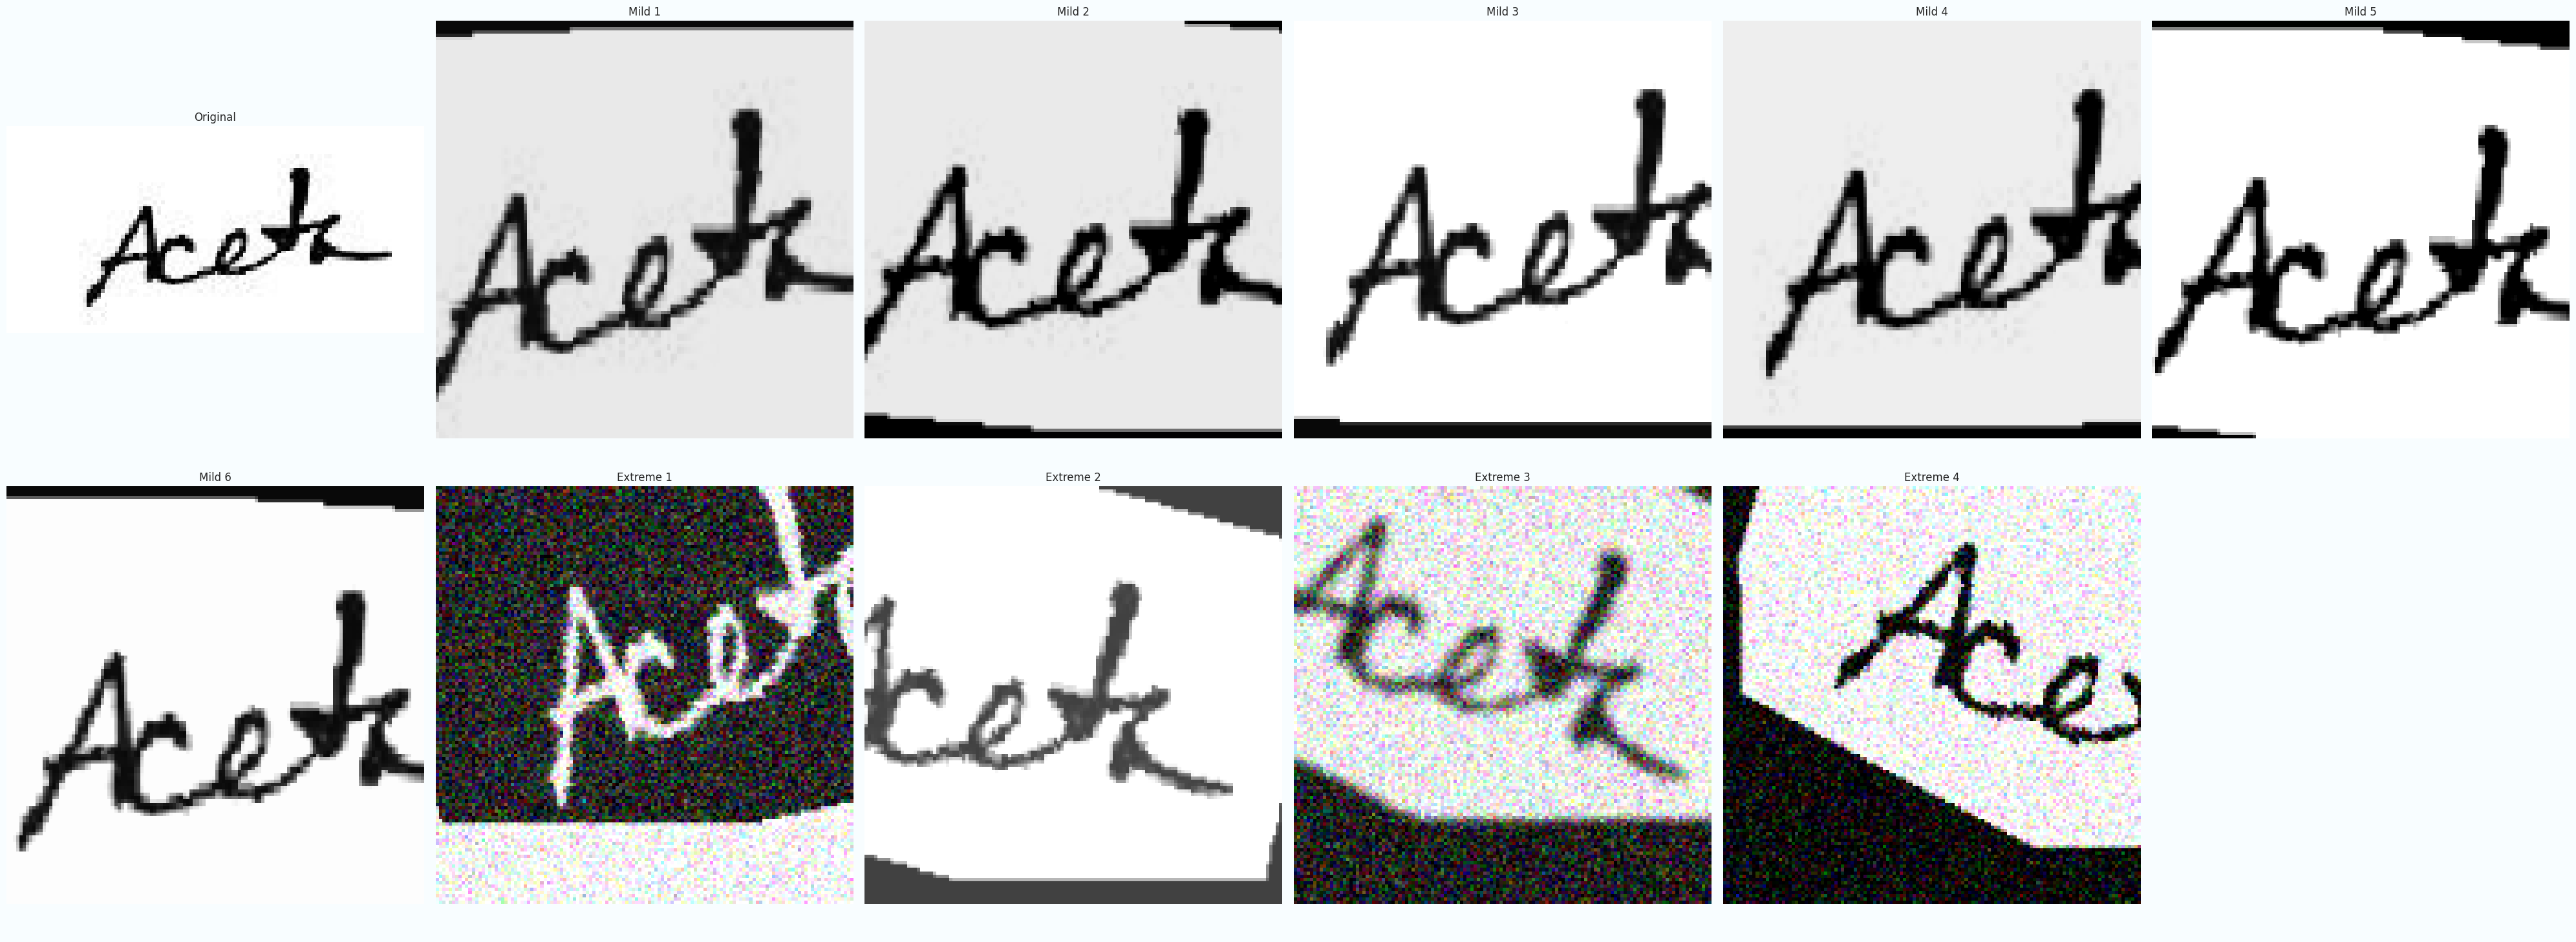

In [16]:
image = Image.open("/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/0.png").convert("RGB")

# get 6 mild-only and 4 extreme-only images
mild_imgs = augment_image(image, total=6, extreme_count=0)
extreme_imgs = augment_image(image, total=4, extreme_count=4)

fig, axes = plt.subplots(2, 6, figsize=(40, 15))
fig.patch.set_facecolor(FIG_BG_COLOR)

axes = axes.flat  # flatten for easy indexing

# Show original
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

# Show mild images in slots 1..6
for i, img in enumerate(mild_imgs):
    axes[i+1].imshow(img.permute(1, 2, 0), cmap="gray")
    axes[i+1].set_title(f"Mild {i+1}")
    axes[i+1].axis("off")

# Show extreme images in next 4 slots (7..10)
for i, img in enumerate(extreme_imgs):
    axes[7 + i].imshow(img.permute(1, 2, 0), cmap="gray")  # row 2 starts at index 6; index 7 is second row slot 2
    axes[7 + i].set_title(f"Extreme {i+1}")
    axes[7 + i].axis("off")

# Hide any remaining empty subplot(s)
for j in range(11, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

<table>
<tr>
    <td><img src="https://github.com/mrbhanukab/Dr.Handwritten_Recognizer/blob/main/static/duplicate.webp?raw=true" alt="Duplicate Audit" /></td>
    <td>
        <h2>Steps: </h2>
        <ol>
            <li>Loop through images in <code>manipulated_dataset</code></li>
            <li>Calculate Hash value for each image using <u>BLAKE3</u></li>
            <li>Compare hash with previously calculated hash values.</li>
            <li>If it duplicated remove second one, while keep first one from <code>manipulated_dataset</code></li>
        </ol>
    </td>
</tr>
<tr>
<td colspan="2">
    <h2>Why BLAKE3?</h2>

<table>
    <thead>
        <tr>
            <th>Hash Function</th>
            <th>Speed</th>
            <th>Collision Risk</th>
            <th>Cryptographic?</th>
            <th>Suitability for Deduplication</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>MD5</td>
            <td>Moderate</td>
            <td>Low (but broken for security)</td>
            <td>✅ (but obsolete)</td>
            <td>Okay, but slower and outdated</td>
        </tr>
        <tr>
            <td>SHA-256</td>
            <td>Moderate</td>
            <td>Extremely low</td>
            <td>✅</td>
            <td>Very safe, but overkill for deduplication</td>
        </tr>
        <tr>
            <td>CRC32</td>
            <td>Fast</td>
            <td>Poor (not suitable for security)</td>
            <td>❌</td>
            <td>Not recommended for deduplication</td>
        </tr>
        <tr>
            <td>xxHash</td>
            <td>Blazing fast</td>
            <td>Very low (but non-cryptographic)</td>
            <td>❌</td>
            <td>Excellent for large image sets</td>
        </tr>
        <tr>
            <td>BLAKE3</td>
            <td>Very fast (SIMD, parallelized)</td>
            <td>Extremely low</td>
            <td>✅</td>
            <td>Best of both worlds: speed + security</td>
        </tr>
    </tbody>
</table>

<p>We selected <strong>BLAKE3</strong> over <strong>xxHash</strong> because, while <strong>xxHash</strong> is indeed the fastest option, it is not cryptographically secure. This means that it is more susceptible to collision attacks, where different inputs could produce the same hash value. In contrast, <strong>BLAKE3</strong> offers both high speed and strong cryptographic security, making it a more reliable choice for deduplication tasks.</p>

<p>Additionally, <strong>BLAKE3</strong> provides excellent collision resistance, ensuring that the likelihood of two different images producing the same hash is extremely low. This is crucial for accurately identifying duplicates, especially in a dataset of approximately <strong>5,000 images</strong>. Thus, <strong>BLAKE3</strong> guarantees both speed and reliability, making it the best choice for our needs.</p>

</td>
</tr>
</table>
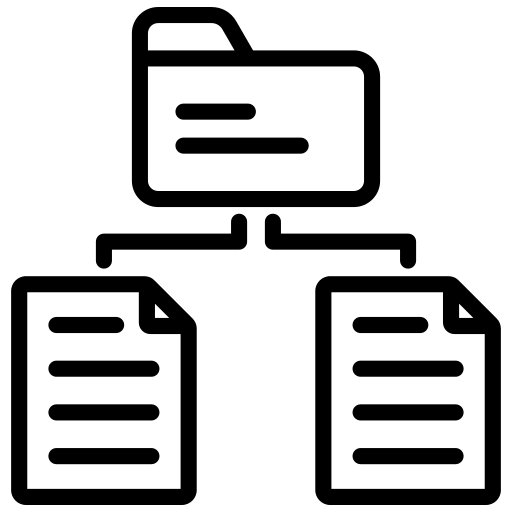
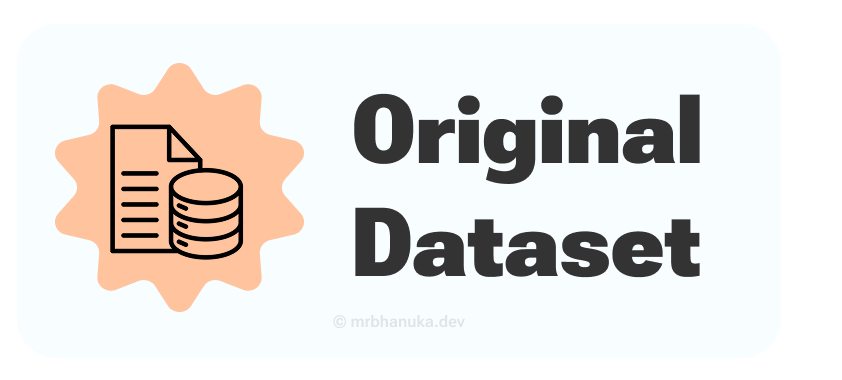
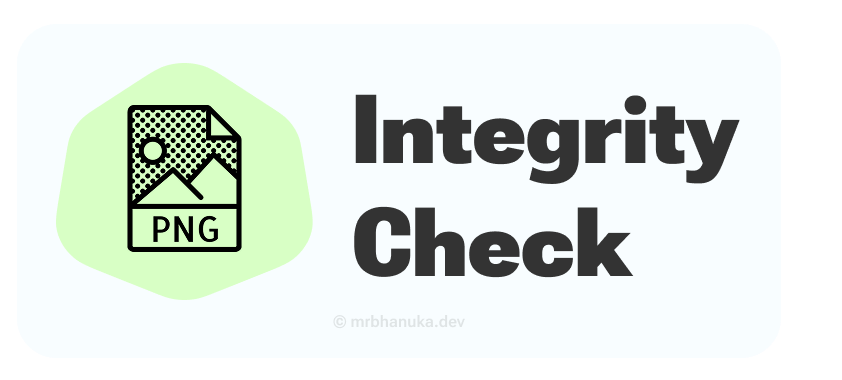
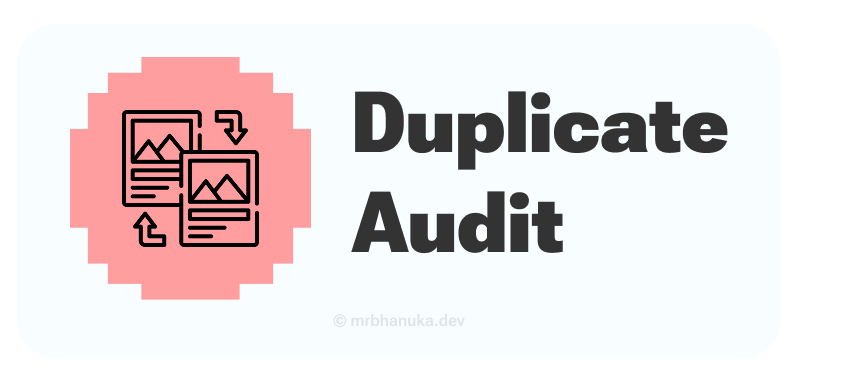
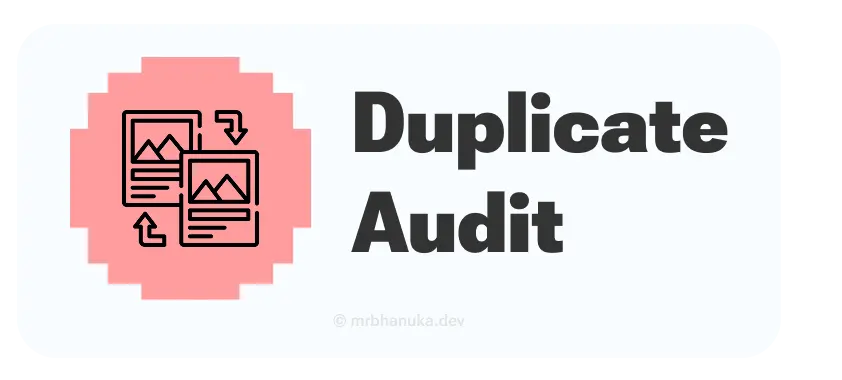
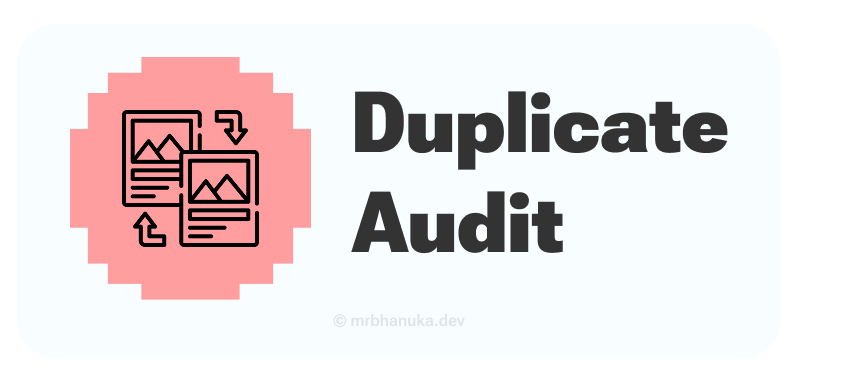

In [17]:
duplicates = []
seen_hashes = {}

lock = Lock()

def check_for_duplicates(image: str):
    try:
        with open(image, 'rb') as file:
            file_hash = blake3.blake3(file.read()).hexdigest()
        with lock:
            if file_hash in seen_hashes:
                logger.warning(f'Duplicate image found: {image}. It will be removed from the dataset.')
                duplicates.append((seen_hashes[file_hash], image))
            else:
                seen_hashes[file_hash] = image
    except Exception as e:
        logger.error(f"⚠️ Error processing {image}: {e}")
        

if data_pipeline_status[0]:
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        executor.map(check_for_duplicates, manipulated_dataset["IMAGE"])
else:
    print("You have to complete Integrity Check!")

In [18]:
manipulated_dataset = manipulated_dataset[~manipulated_dataset["IMAGE"].isin({dup for orig, dup in duplicates})]

if seen_hashes:
    data_pipeline_status[1] = True

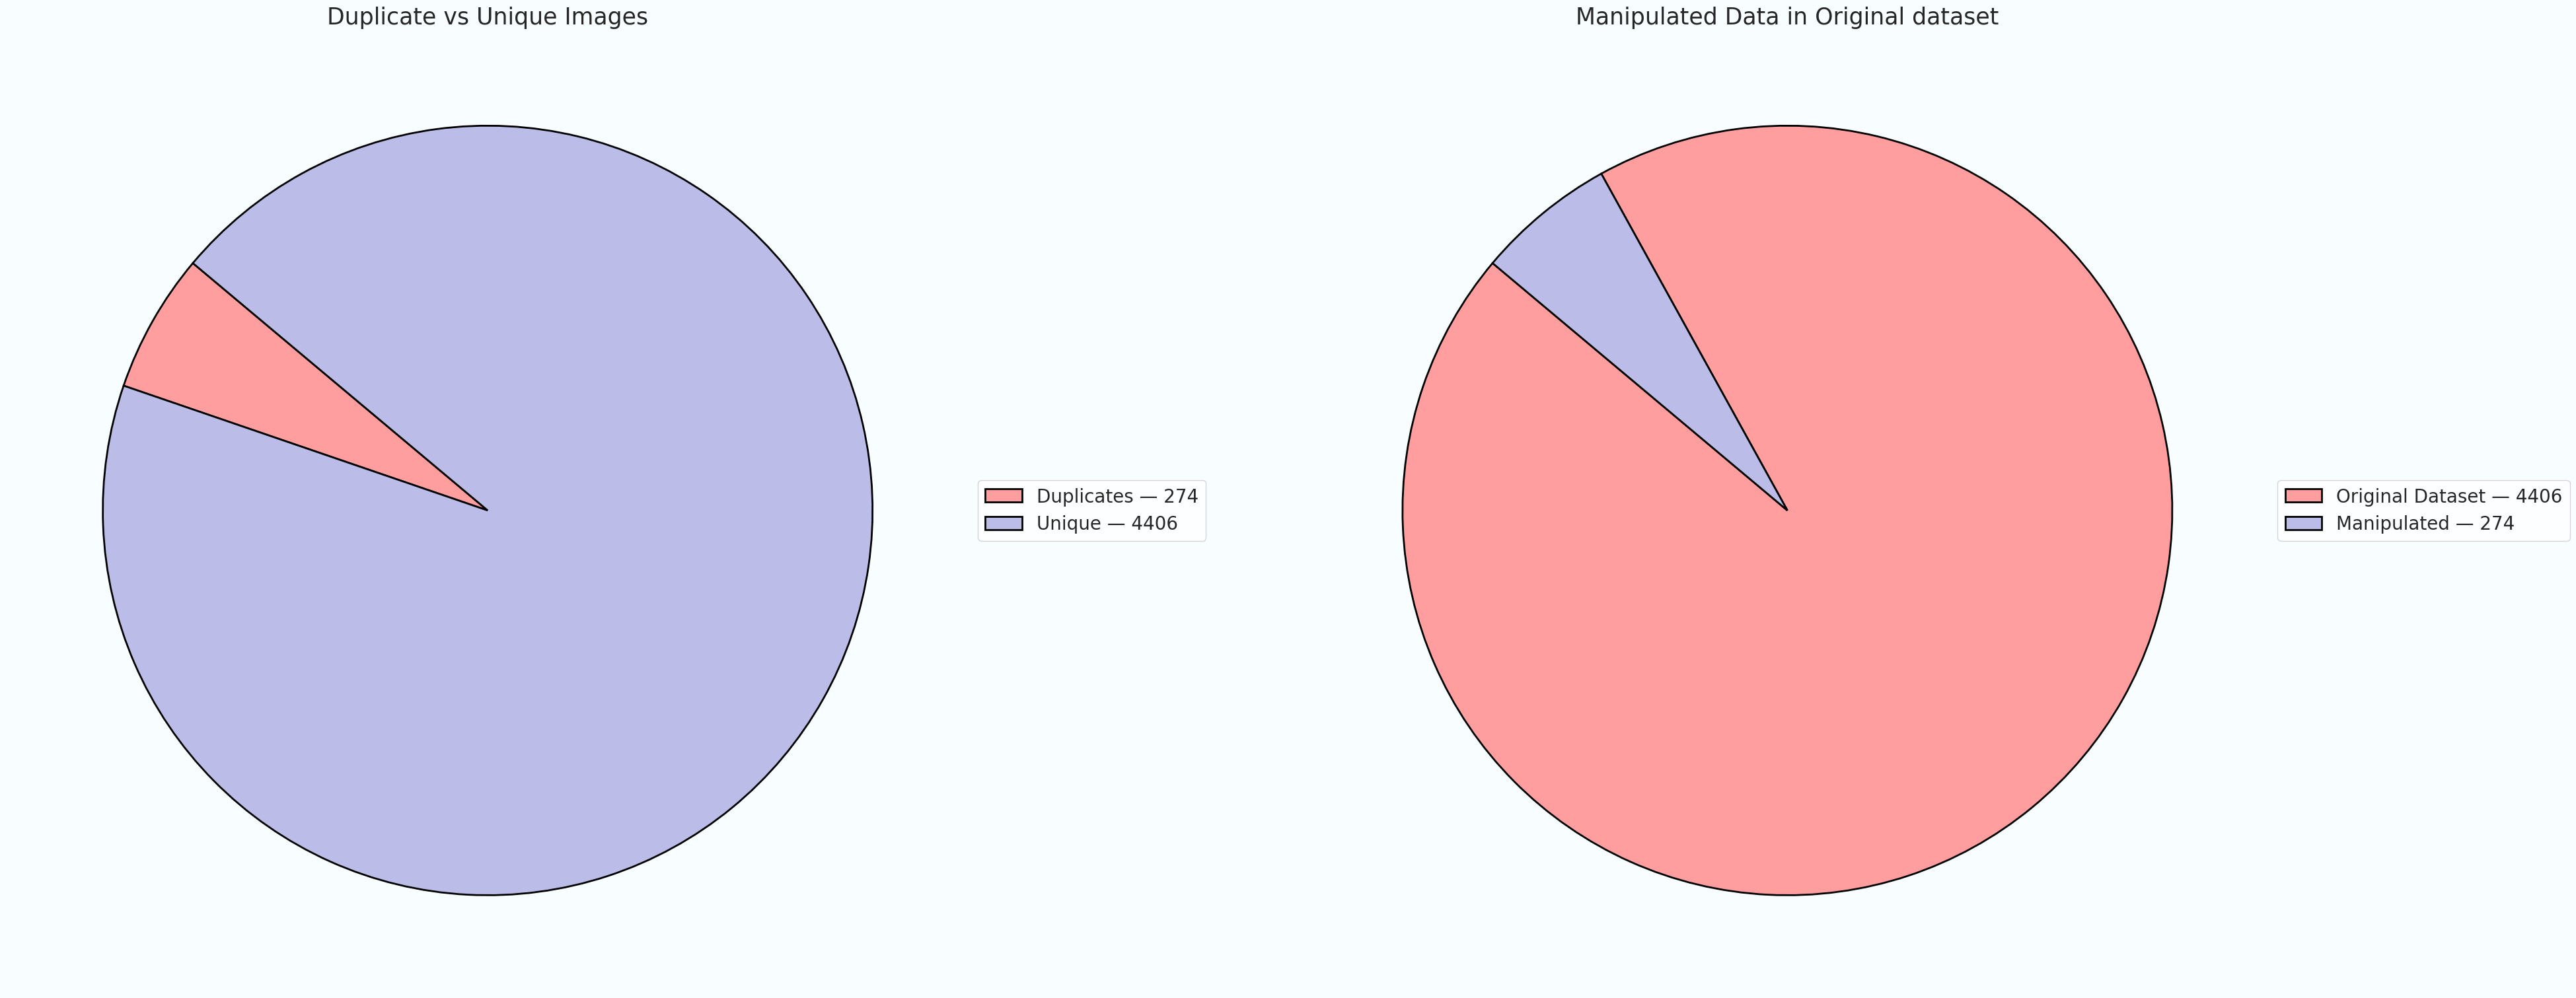

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(40, 15), gridspec_kw={'width_ratios':[1, 1]}, constrained_layout=True)
fig.patch.set_facecolor(FIG_BG_COLOR)

# Left: Duplicates in the Manipulated Dataset
labels = ["Duplicates", "Unique"]
sizes = [len(duplicates), len(seen_hashes)]

colors = [color_map(i % color_map.N) for i in range(len(labels))]

axes[0].pie(sizes, labels=None, colors=colors, startangle=140, wedgeprops={'edgecolor': 'black', 'linewidth': 2})
axes[0].set_title('Duplicate vs Unique Images', fontsize=25)

legend_labels = [f"{n} — {c}" for n, c in zip(labels, sizes)]
axes[0].legend(legend_labels, title='', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)

# Right: Manipulated Data in Original dataset
labels = ['Original Dataset', 'Manipulated']
sizes = [len(original_dataset) - (len(original_dataset) - len(manipulated_dataset)), len(original_dataset) - len(manipulated_dataset)]

colors = [color_map(i % color_map.N) for i in range(len(labels))]

axes[1].pie(sizes, labels=None, colors=colors, startangle=140, wedgeprops={'edgecolor': 'black', 'linewidth': 2})
axes[1].set_title('Manipulated Data in Original dataset', fontsize=25)

legend_labels = [f"{n} — {c}" for n, c in zip(labels, sizes)]
axes[1].legend(legend_labels, title='', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)

plt.show()

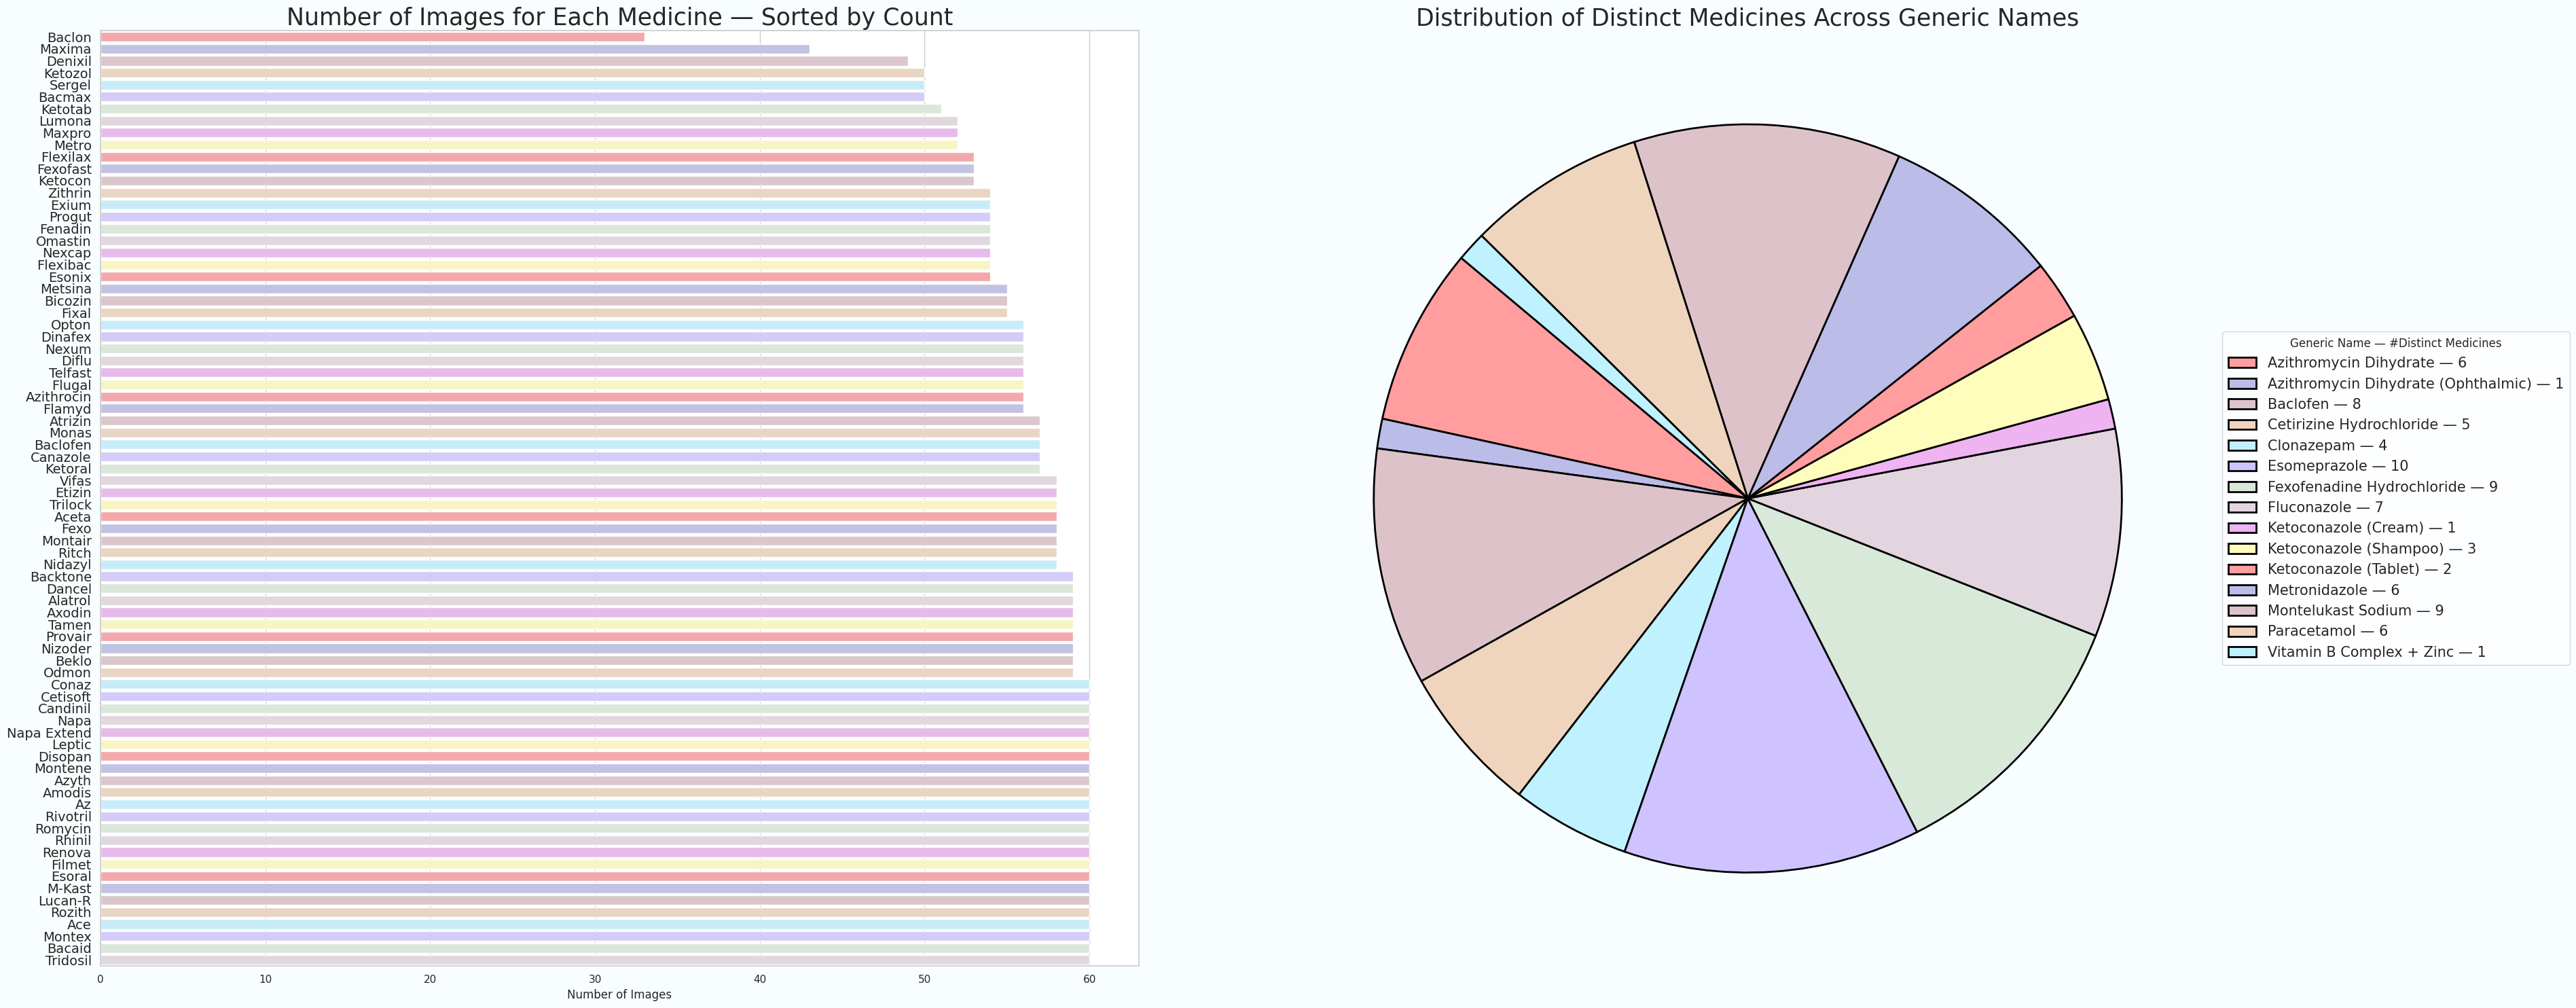

In [20]:
sns.set_theme(style='whitegrid', context='notebook')

fig, axes = plt.subplots(ncols=2, figsize=(40, 15), gridspec_kw={'width_ratios':[2, 3]})
fig.patch.set_facecolor(FIG_BG_COLOR)

# Left: sorted horizontal bar chart for MEDICINE_NAME
sns.barplot(x='count', y='MEDICINE_NAME', data=manipulated_dataset['MEDICINE_NAME'].value_counts().reset_index().sort_values('count', ascending=True) , ax=axes[0], palette=color_palette)
axes[0].set_title('Number of Images for Each Medicine — Sorted by Count', fontsize=25)
axes[0].set_xlabel('Number of Images')
axes[0].set_ylabel('')
axes[0].tick_params(axis='y', labelsize=14)

# Right: pie chart for all GENERIC_NAME
medicines_per_generic_name = manipulated_dataset.groupby('GENERIC_NAME')['MEDICINE_NAME'].nunique().reset_index()
labels = medicines_per_generic_name['GENERIC_NAME']
sizes = medicines_per_generic_name['MEDICINE_NAME']

axes[1].pie(sizes, labels=None, colors=[color_map(i % color_map.N) for i in range(len(labels))], startangle=140,
            wedgeprops={'edgecolor': 'black', 'linewidth': 2})
axes[1].set_title('Distribution of Distinct Medicines Across Generic Names', fontsize=25)

legend_labels = [f"{n} — {c}" for n, c in zip(labels, sizes)]
axes[1].legend(legend_labels, title='Generic Name — #Distinct Medicines', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)

fig.tight_layout()
plt.show()

<table>
<tr>
<td><img src="https://github.com/mrbhanukab/Dr.Handwritten_Recognizer/blob/main/static/balance.webp?raw=true" alt="Class Balancing" /></td>
    <td>
        <h2>Steps:</h2>
        <ol>
            <li>Identify each <code>MEDICINE_NAME</code> with fewer images than the target class size.</li>
            <li>Compute how many additional images are required to reach the target size.</li>
            <li>Generate the required synthetic or duplicated samples for that class (distinct from the <code>augment_image</code> method).</li>
            <li>Save the new files into the <code>temp</code> folder.</li>
            <li>Create corresponding entries in the <code>manipulated_dataset</code> to reflect the added samples.</li>
        </ol>
    </td>
</tr>
<tr>
<td colspan="2">
<h2>But why?</h2>
<p>Class balancing via oversampling reduces bias toward majority classes and improves minority-class performance by providing the model with more training examples for underrepresented classes.</p>

<p>Adding synthetic samples helps the model learn the minority classes' patterns more reliably, stabilizes training, and improves metrics such as recall and F1 for those classes. Care should be taken to avoid exact duplicates or unrealistic samples that could cause overfitting or mislead the model.</p>
</td>
</tr>
</table>

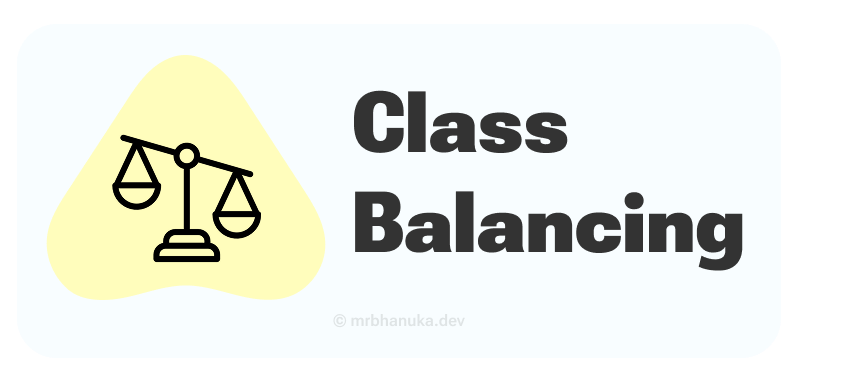
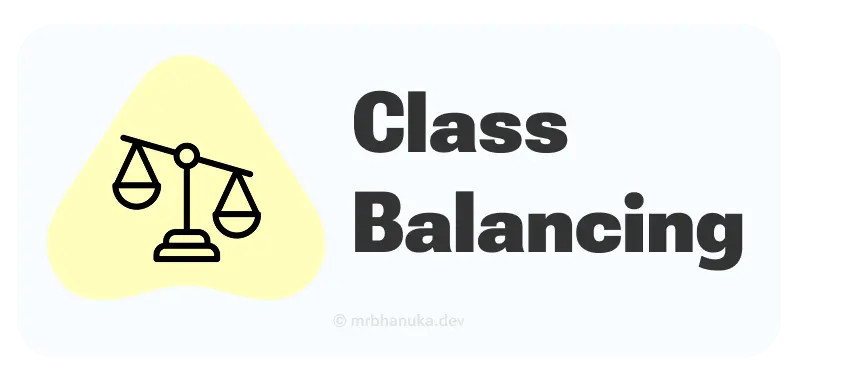
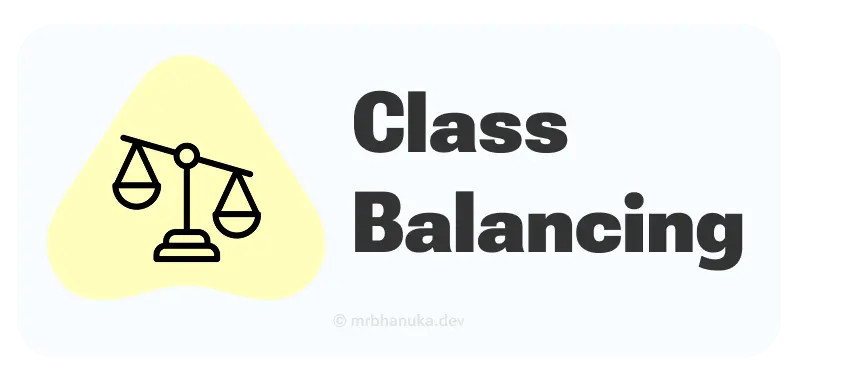
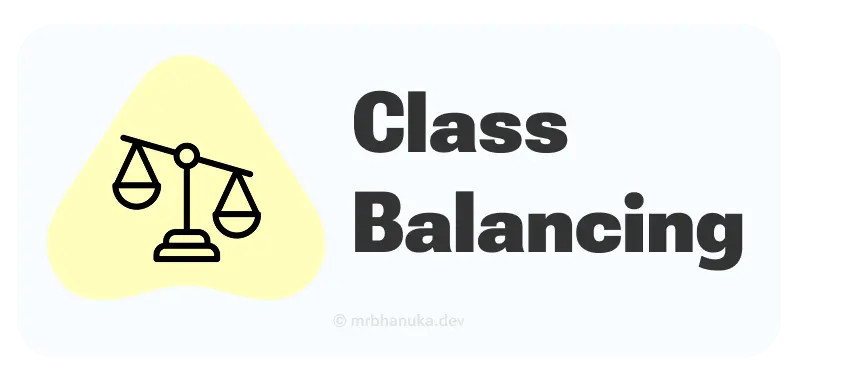
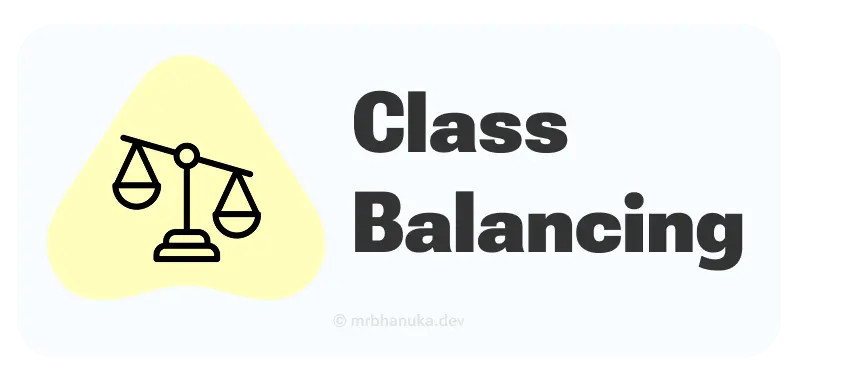

In [21]:
# ensure temp exists
os.makedirs("temp", exist_ok=True)

target_count = 60
counts = manipulated_dataset['MEDICINE_NAME'].value_counts().to_dict()
under = {name: cnt for name, cnt in counts.items() if cnt < target_count}

def to_pil(img_obj):
    if hasattr(img_obj, "permute"):
        return transforms.ToPILImage()(img_obj)
    if isinstance(img_obj, Image.Image):
        return img_obj
    raise TypeError(f"Unsupported image type: {type(img_obj)}")

def process_base_sample(args):
    base_path, med_name, generic, to_make = args
    saved = []
    try:
        img = Image.open(base_path).convert("RGB")
    except Exception as e:
        print(f"Failed open {base_path}: {e}")
        return saved

    try:
        aug_images = augment_image(img, total=to_make, extreme_count=0)
    except Exception as e:
        print(f"augment_image failed for {base_path}: {e}")
        return saved

    for ai in aug_images:
        try:
            ai_pil = to_pil(ai).convert("RGBA")  # ensure PNG support
            fname = f"{med_name.replace(' ', '_')}_{random.randint(1,10**12)}.png"
            out_path = str(Path("temp") / fname)
            ai_pil.save(out_path, format='PNG')
            saved.append((out_path, med_name, generic))
        except Exception as e:
            print(f"Failed save aug image for {base_path}: {e}")
            continue
    return saved

all_new = []
with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = []
    for med_name, current_count in under.items():
        needed = target_count - current_count
        existing = manipulated_dataset[manipulated_dataset['MEDICINE_NAME'] == med_name]['IMAGE'].tolist()
        if not existing:
            print(f"No existing images for {med_name}, skipping")
            continue
        generic = manipulated_dataset[manipulated_dataset['MEDICINE_NAME'] == med_name]['GENERIC_NAME'].iloc[0]

        while needed > 0 and existing:
            batch = min(needed, 10)
            base_path = random.choice(existing)
            futures.append(executor.submit(process_base_sample, (base_path, med_name, generic, batch)))
            needed -= batch

    for fut in as_completed(futures):
        try:
            results = fut.result()
        except Exception as e:
            print(f"Worker raised: {e}")
            continue
        all_new.extend(results)

new_rows = [{'IMAGE': p, 'MEDICINE_NAME': m, 'GENERIC_NAME': g} for p, m, g in all_new]
if new_rows:
    df_new = pd.DataFrame(new_rows, columns=['IMAGE', 'MEDICINE_NAME', 'GENERIC_NAME'])
    manipulated_dataset = pd.concat([manipulated_dataset, df_new], ignore_index=True)

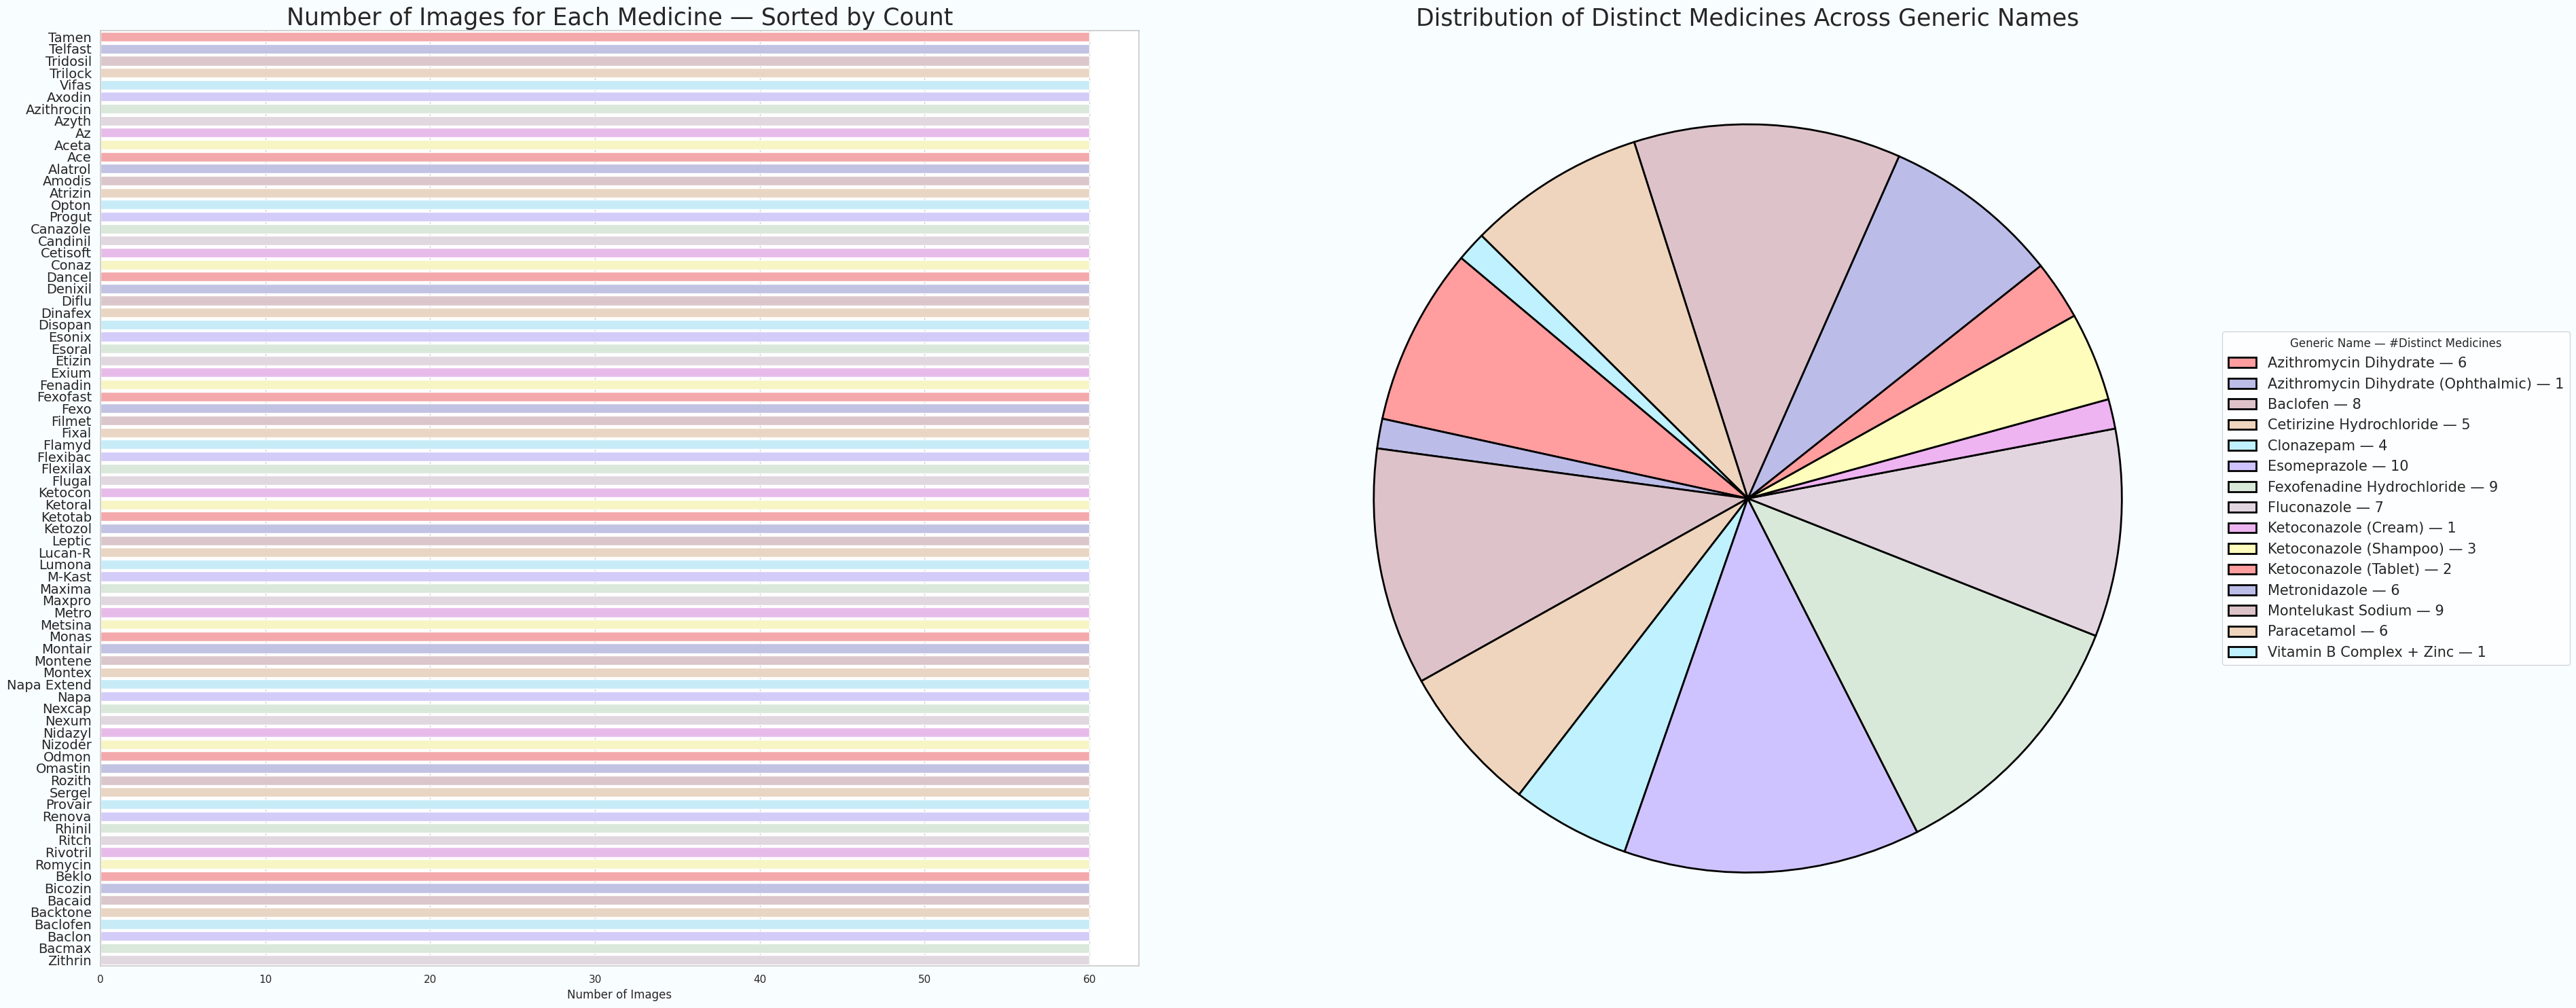

In [22]:
sns.set_theme(style='whitegrid', context='notebook')

fig, axes = plt.subplots(ncols=2, figsize=(40, 15), gridspec_kw={'width_ratios':[2, 3]})
fig.patch.set_facecolor(FIG_BG_COLOR)

# Left: sorted horizontal bar chart for MEDICINE_NAME
sns.barplot(x='count', y='MEDICINE_NAME', data=manipulated_dataset['MEDICINE_NAME'].value_counts().reset_index().sort_values('count', ascending=True) , ax=axes[0], palette=color_palette)
axes[0].set_title('Number of Images for Each Medicine — Sorted by Count', fontsize=25)
axes[0].set_xlabel('Number of Images')
axes[0].set_ylabel('')
axes[0].tick_params(axis='y', labelsize=14)

# Right: pie chart for all GENERIC_NAME
medicines_per_generic_name = manipulated_dataset.groupby('GENERIC_NAME')['MEDICINE_NAME'].nunique().reset_index()
labels = medicines_per_generic_name['GENERIC_NAME']
sizes = medicines_per_generic_name['MEDICINE_NAME']

axes[1].pie(sizes, labels=None, colors=[color_map(i % color_map.N) for i in range(len(labels))], startangle=140,
            wedgeprops={'edgecolor': 'black', 'linewidth': 2})
axes[1].set_title('Distribution of Distinct Medicines Across Generic Names', fontsize=25)

legend_labels = [f"{n} — {c}" for n, c in zip(labels, sizes)]
axes[1].legend(legend_labels, title='Generic Name — #Distinct Medicines', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)

fig.tight_layout()
plt.show()

<table>
<tr>
    <td>
        <img src="https://github.com/mrbhanukab/Dr.Handwritten_Recognizer/blob/main/static/resize.webp?raw=true" alt="Image Resize" />
    </td>
    <td>
        <h2>Steps:</h2>
        <table>
            <tr>
                <td>
                    <h3>Check Most Practical Way of Resizing</h3>
                    <ol>
                        <li>Change aspect ratio to 1:1 by padding with white space</li>
                        <li>
                            Compare resizing methods (quality vs. time trade-off):
                            <ul>
                                <li>PyTorch transforms.Resize</li>
                                <li>BSRGAN</li>
                                <li>Real-ESRGAN</li>
                                <li>SwinIR</li>
                            </ul>
                        </li>
                    </ol>
                </td>
                <td>
                    <h3>Image Transform</h3>
                    <h4>Create a function to:</h4>
                    <ol>
                        <li>Change aspect ratio to 1:1 by padding with white space</li>
                        <li>Resize the input image to 224×224</li>
                        <li>Convert to grayscale</li>
                        <li>Return the processed image</li>
                    </ol>
                </td>                
            </tr>
        </table>
    </td>
</tr>
<tr>
<td colspan="2">
    <h2>Why Resizing into 224×224?</h2>
    <p>
Models such as VGG, ResNet, and DenseNet were originally trained on the ImageNet dataset with a standard input size of 224×224; using this resolution ensures compatibility with pretrained models, aligns convolutional feature scales, captures a useful balance of local detail versus computational cost, and simplifies transfer learning by allowing direct reuse of pretrained weights — but as you can see below, most hexbin images are too small, so we need to upscale.
    </p>
</tr>
</table>

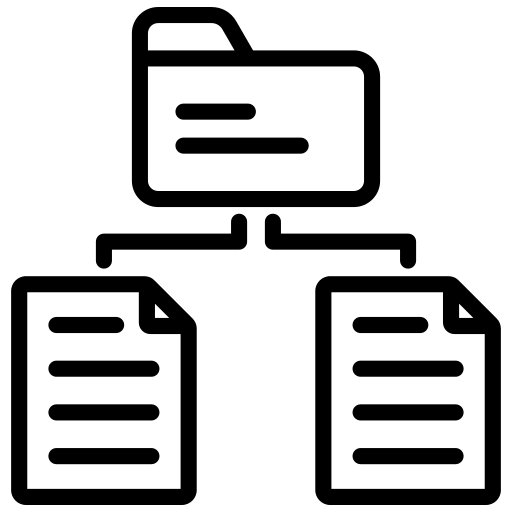
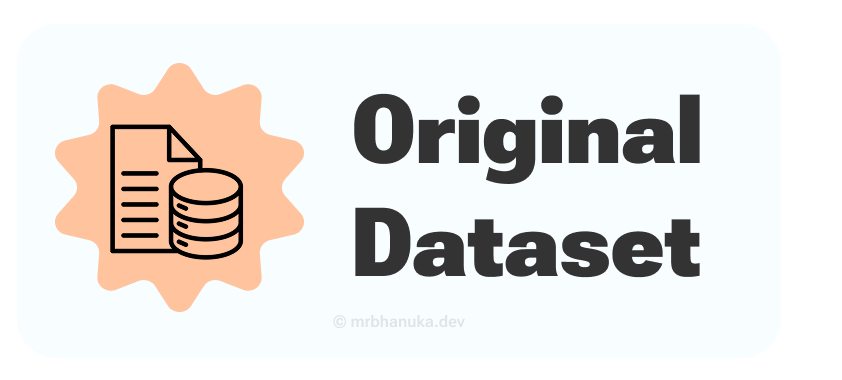
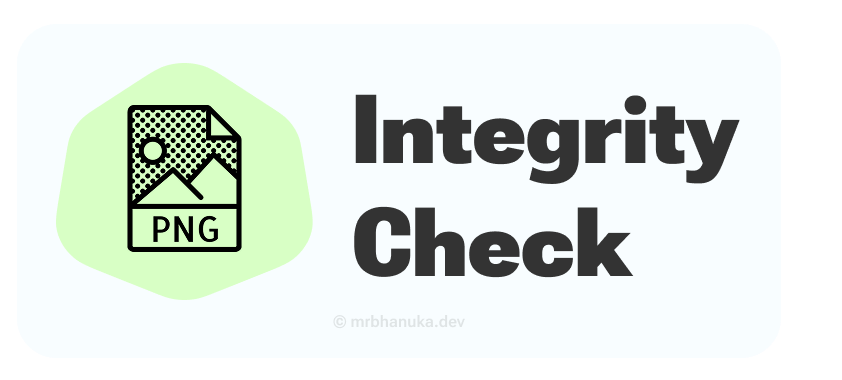
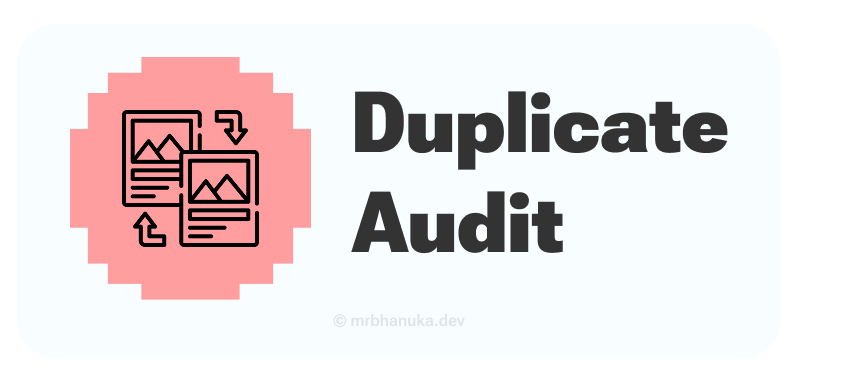
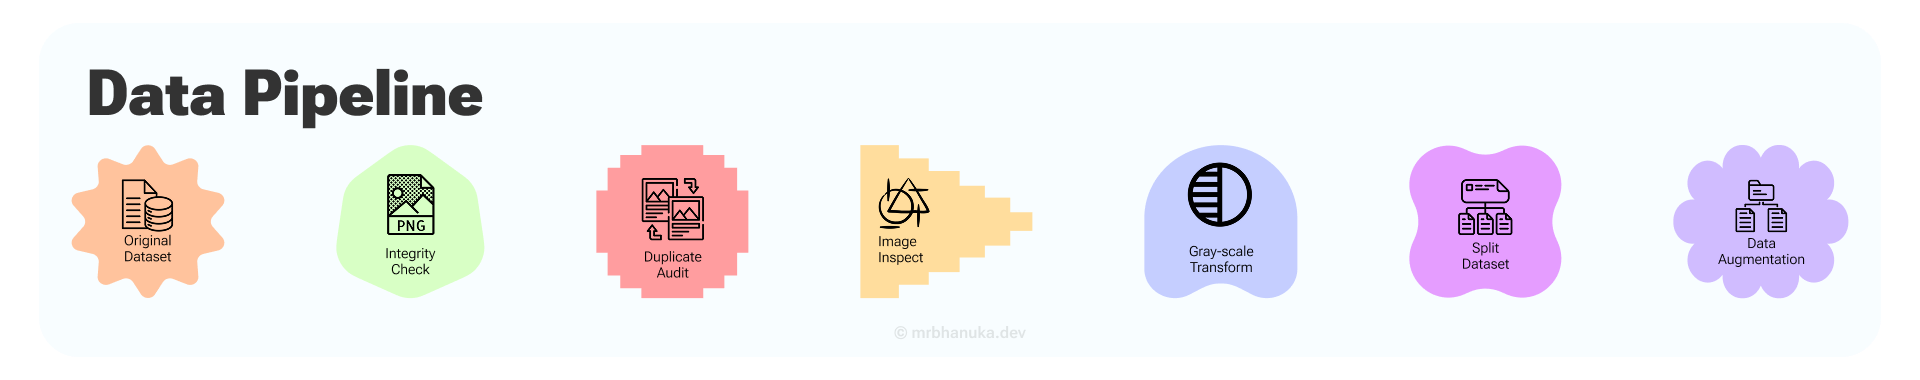
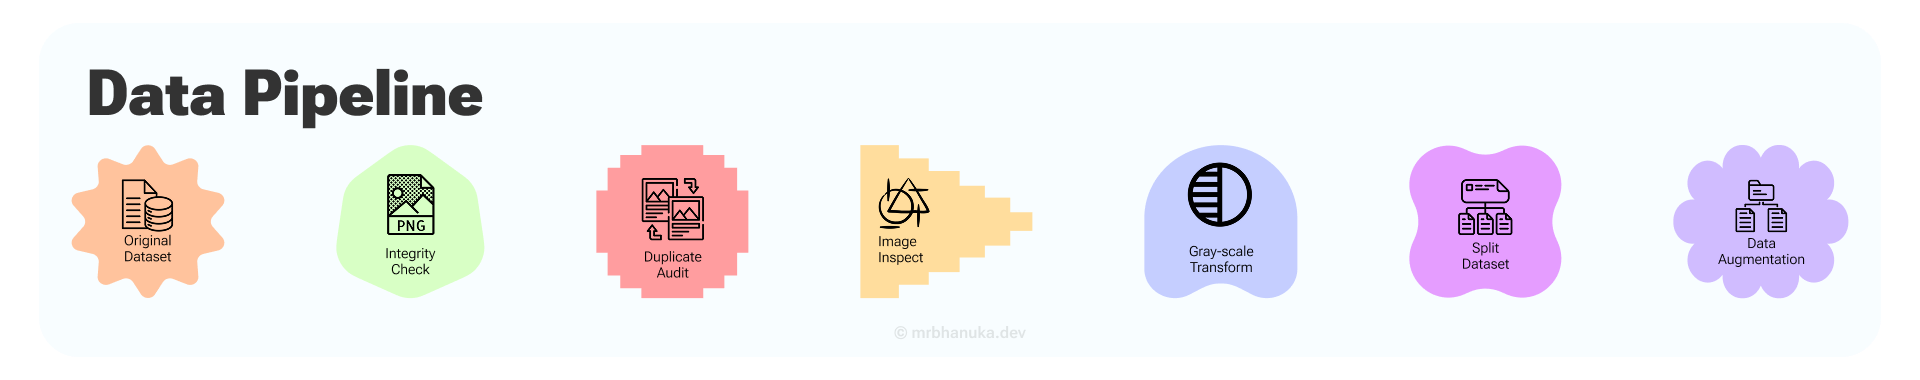
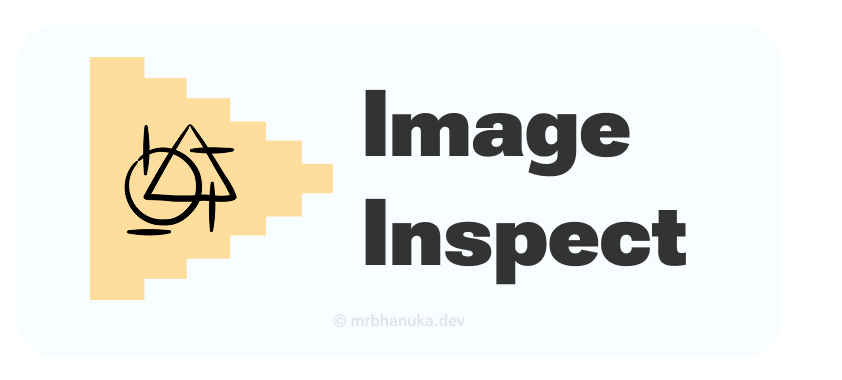
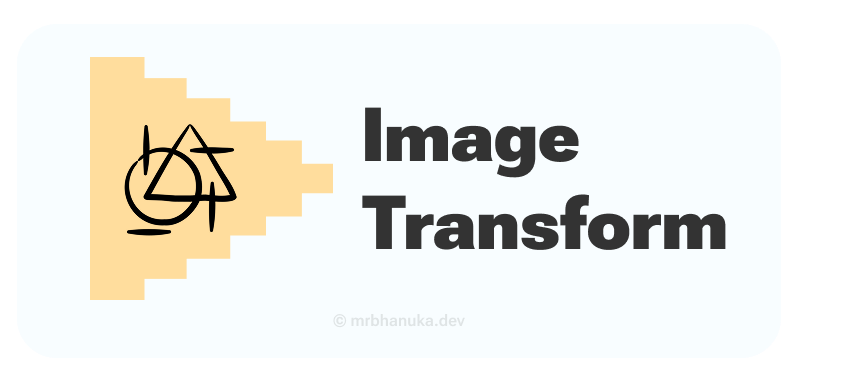
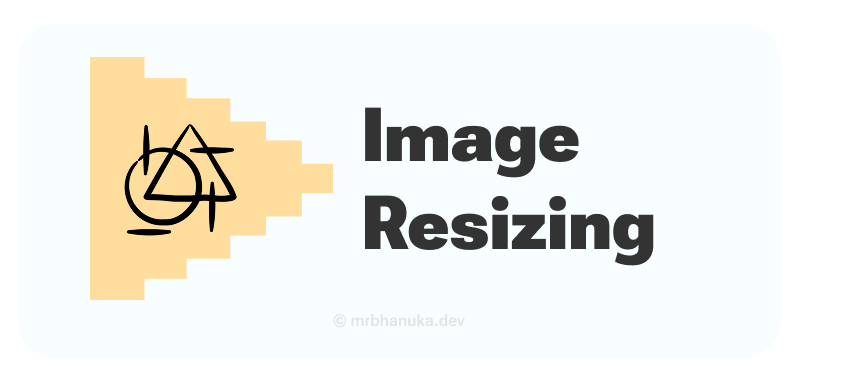

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


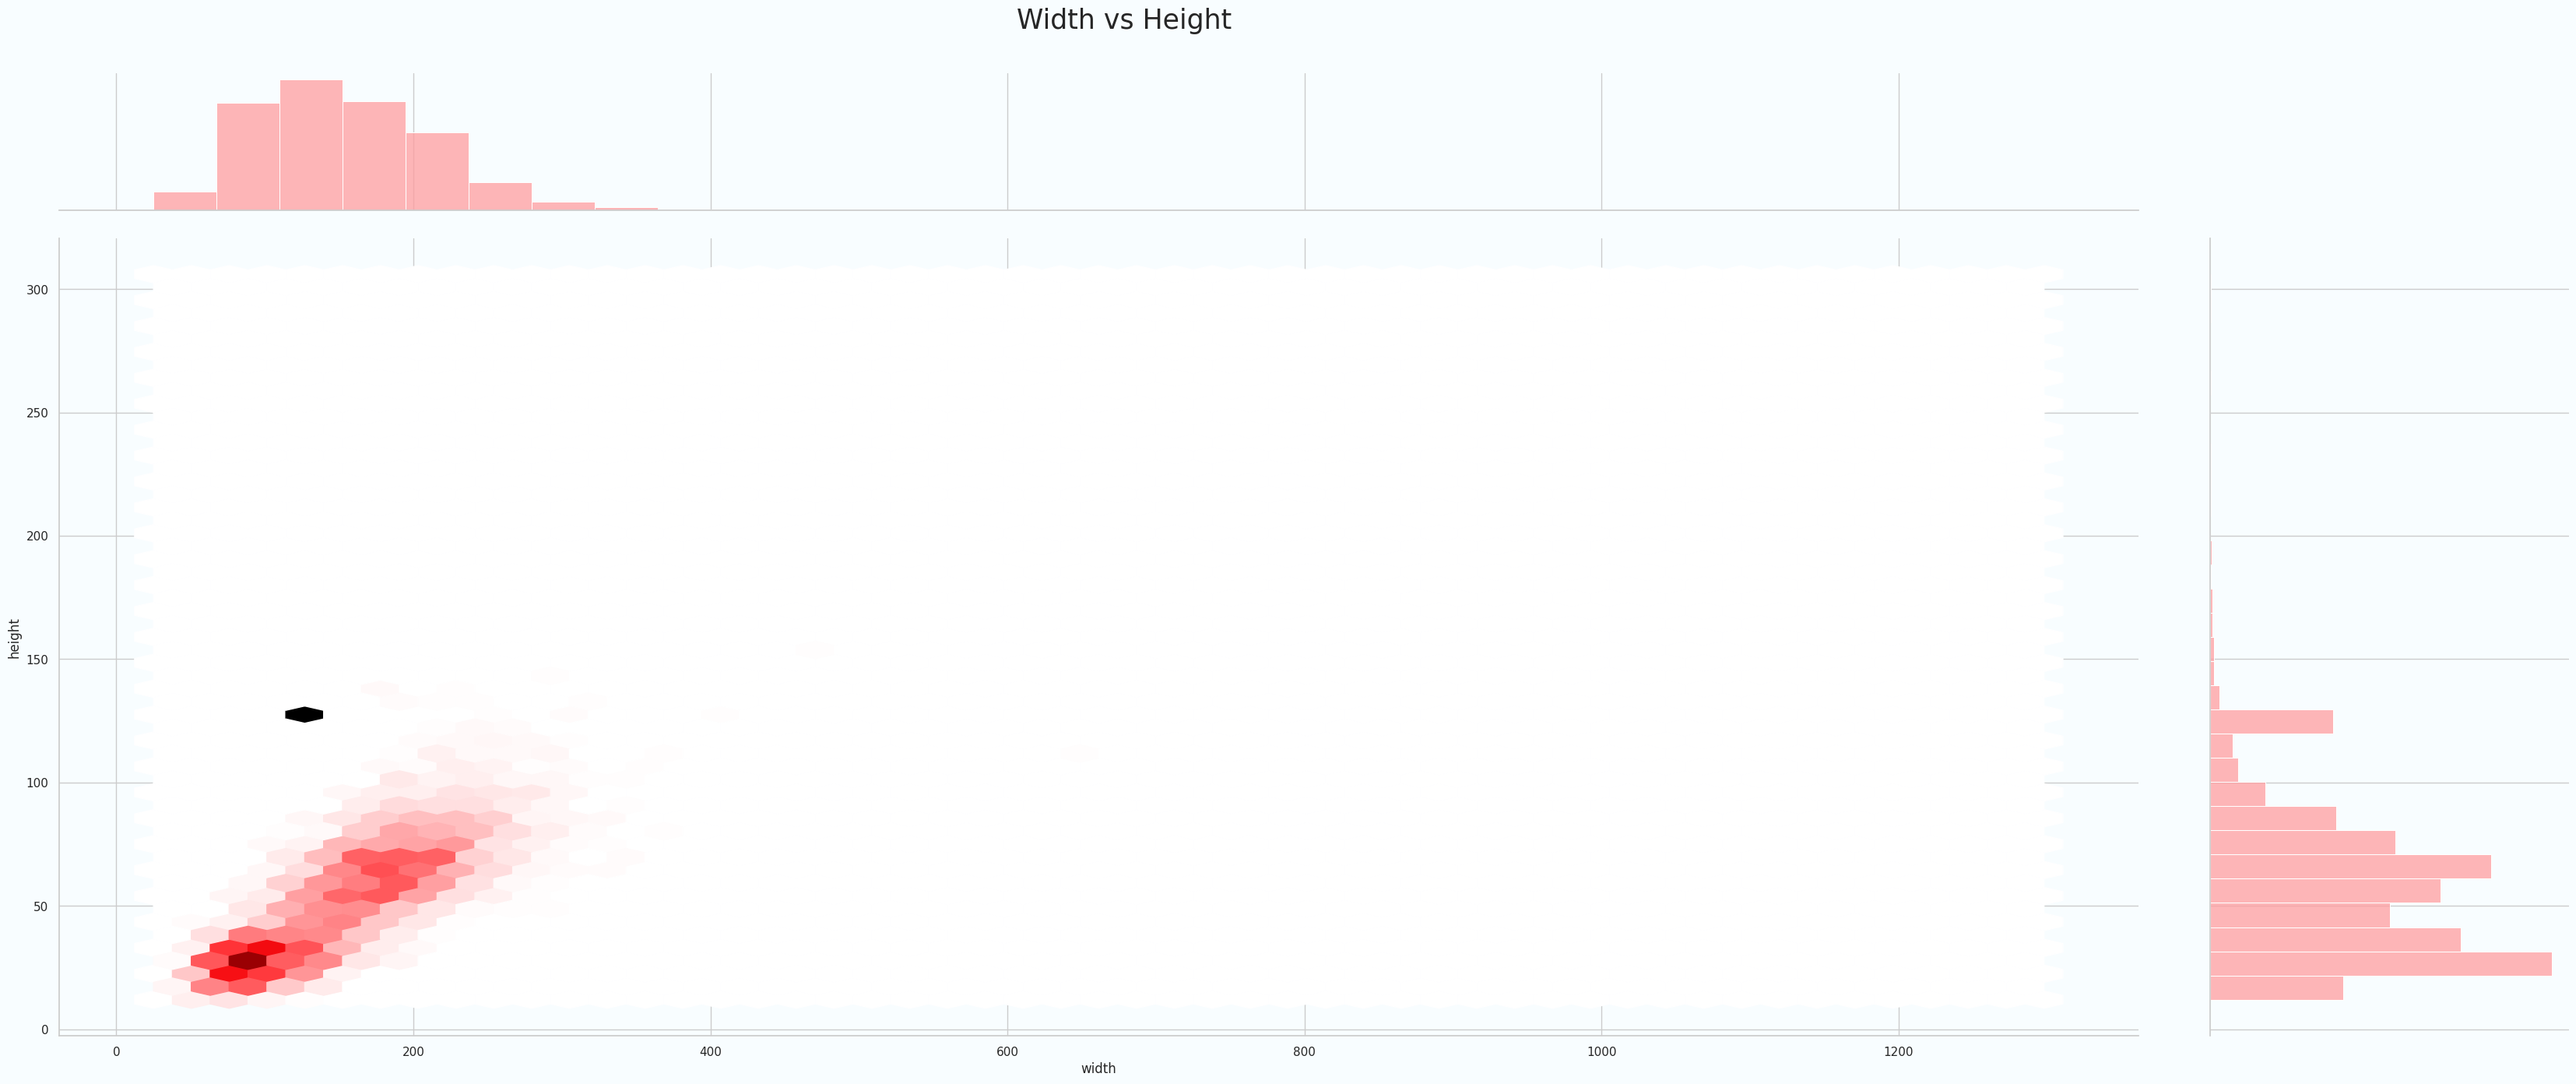

In [23]:
widths = []
heights = []

# Helper to open one image and return (width, height)
def _get_size(path):
    img = Image.open(path)
    w, h = img.size
    img.close()
    return w, h
    
with ThreadPoolExecutor(max_workers=os.cpu_count()) as ex:
    for w, h in ex.map(_get_size, list(manipulated_dataset["IMAGE"])):
        widths.append(w)
        heights.append(h)

# Build DataFrame
df_wh = pd.DataFrame({"width": widths, "height": heights})

# Seaborn/Matplotlib plotting with provided palette and background
sns.set(style="whitegrid", rc={"axes.facecolor": FIG_BG_COLOR, "figure.facecolor": FIG_BG_COLOR})
if 'color_palette' in globals():
    sns.set_palette(color_palette)

g = sns.jointplot(x="width", y="height", data=df_wh, kind="hex", height=5, marginal_kws=dict(bins=30, fill=True))
g.fig.set_facecolor(FIG_BG_COLOR)
g.fig.set_size_inches(40, 15)
plt.suptitle("Width vs Height", fontsize=25, y=1.02)
plt.show()

> According to the following test, just resizing is not enough. So we tested several GANs and found that **Real-ESRGAN** produces the most realistic upscaled images in the least amount of time, so we will use it for image upscaling. We also added padding to preserve a **1:1 aspect ratio**.

In [24]:
def ensure_224_224(image: Image.Image) -> Image.Image:
    if not isinstance(image, Image.Image):
        raise TypeError("image must be a PIL.Image.Image")

    w, h = image.size
    
    # Initialize padding variables
    pad_left = pad_top = pad_right = pad_bottom = 0
    
    if not w == h:
        new_side = max(w, h)
        
        if w > h:
            # padding height
            total_pad = w - h
            pad_top = total_pad // 2
            pad_bottom = total_pad - pad_top
        else:
            # padding width
            total_pad = h - w
            pad_left = total_pad // 2
            pad_right = total_pad - pad_left

    return (transforms.Resize((224, 224)))(ImageOps.expand(image, border=(pad_left, pad_top, pad_right, pad_bottom), fill="white"))

# helper: tensor (C,H,W) in [0,1] -> PIL RGB
def tensor_to_pil(tensor):
    # tensor: torch.Tensor on CPU or CUDA, shape (C,H,W) or (1,C,H,W)
    if tensor.dim() == 4:
        tensor = tensor.squeeze(0)
    tensor = tensor.clamp(0, 1)
    return TF.to_pil_image(tensor.cpu())

In [25]:
out_dir = Path("weights")
out_dir.mkdir(parents=True, exist_ok=True)

urls = [
    "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth",
    "https://huggingface.co/kadirnar/bsrgan/resolve/main/BSRGAN.pth",
    "https://huggingface.co/LykosAI/Upscalers/resolve/main/SwinIR/SwinIR_4x.pth",
]

def download(url: str, dest: Path, chunk_size: int = 1024*1024):
    if dest.exists():
        print(f"Skipping, already exists: {dest}")
        return
    # stream request to get content-length
    with requests.get(url, stream=True, allow_redirects=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("Content-Length", 0))
        with tqdm(total=total, unit="B", unit_scale=True, unit_divisor=1024,
                  desc=dest.name, initial=0) as pbar:
            with open(dest, "wb") as f:
                for chunk in r.iter_content(chunk_size=chunk_size):
                    if not chunk:
                        continue
                    f.write(chunk)
                    pbar.update(len(chunk))

for url in urls:
    filename = url.split("/")[-1]
    dest_path = out_dir / filename
    try:
        download(url, dest_path)
    except Exception as e:
        print(f"Failed to download {url}: {e}")

RealESRGAN_x4plus.pth:   0%|          | 0.00/63.9M [00:00<?, ?B/s]

BSRGAN.pth:   0%|          | 0.00/63.9M [00:00<?, ?B/s]

SwinIR_4x.pth:   0%|          | 0.00/136M [00:00<?, ?B/s]

Using device: cuda


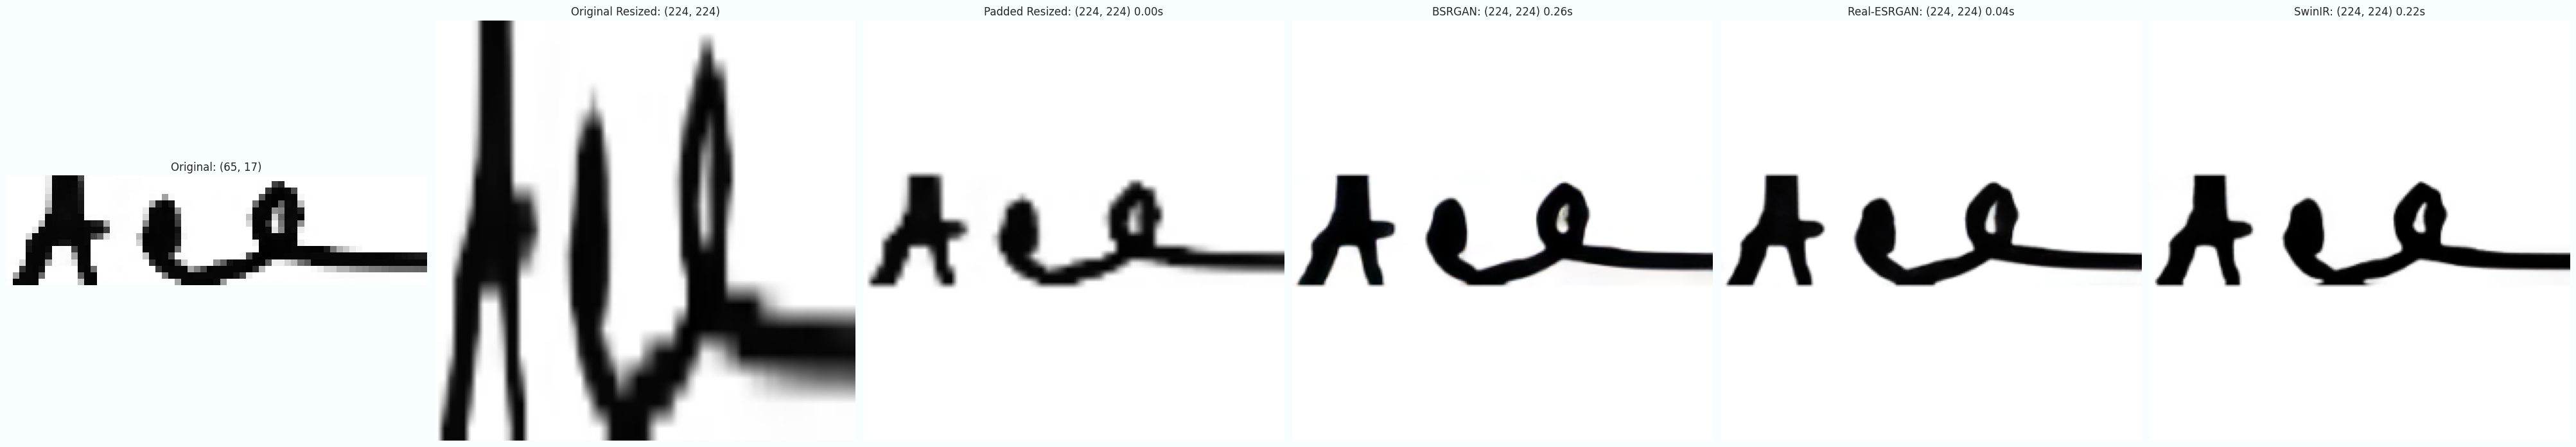

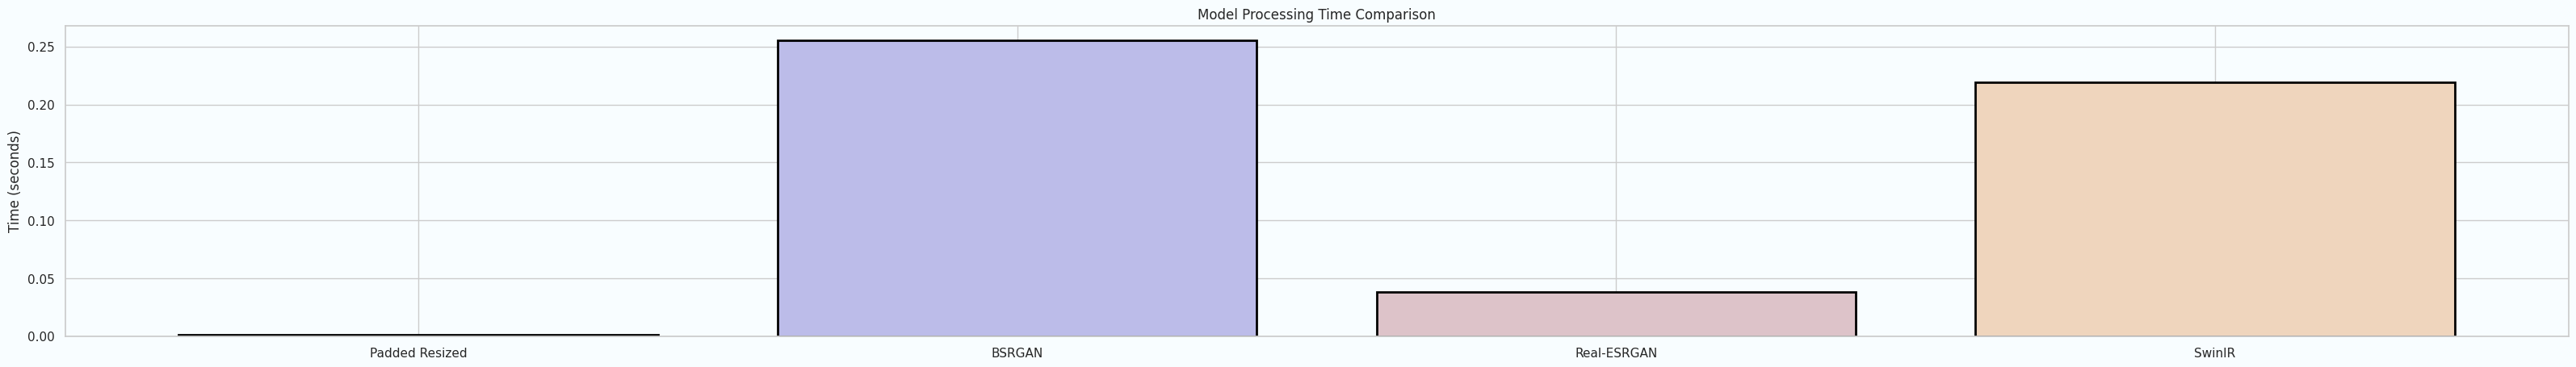

In [26]:
warnings.filterwarnings("ignore")

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and preprocess image
image_path = "/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/11.png"
original_image = Image.open(image_path).convert("RGB")

# Resize to 224x224
original_image_resized = (transforms.Resize((224, 224)))(original_image)

# Timing and processing
times = []
outputs = []

# --- Pad to square ---
start_time = time.time()
outputs.append(ensure_224_224(original_image))
times.append(time.time() - start_time)


# Convert to tensor
to_tensor = transforms.ToTensor()
tensor = to_tensor(original_image).unsqueeze(0)

# Load models
bsrgan = ModelLoader().load_from_file("/kaggle/working/weights/BSRGAN.pth").to("cuda")
realesrgan = ModelLoader().load_from_file("/kaggle/working/weights/RealESRGAN_x4plus.pth").to("cuda")
swinir = ModelLoader().load_from_file("//kaggle/working/weights/SwinIR_4x.pth").to("cuda")

# BSRGAN
start_time = time.time()
with torch.no_grad():
    out_t = bsrgan(tensor.to(device))
    pil = tensor_to_pil(out_t)
    outputs.append(ensure_224_224(pil))
times.append(time.time() - start_time)

# Real-ESRGAN
start_time = time.time()
with torch.no_grad():
    out_t = realesrgan(tensor.to(device))
    pil = tensor_to_pil(out_t)
    outputs.append(ensure_224_224(pil))
times.append(time.time() - start_time)

# SwinIR
start_time = time.time()
with torch.no_grad():
    out_t = swinir(tensor.to(device))
    pil = tensor_to_pil(out_t)
    outputs.append(ensure_224_224(pil))
times.append(time.time() - start_time)

# --- Display original, padded, and outputs ---
fig, axs = plt.subplots(1, 6, figsize=(40, 10), constrained_layout=True)
fig.patch.set_facecolor(FIG_BG_COLOR)
axs[0].imshow(original_image); axs[0].set_title(f"Original: {original_image.size}"); axs[0].axis("off")
axs[1].imshow(original_image_resized); axs[1].set_title(f"Original Resized: {original_image_resized.size}"); axs[1].axis("off")
axs[2].imshow(outputs[0]); axs[2].set_title(f"Padded Resized: {outputs[0].size} {times[0]:.2f}s"); axs[2].axis("off")
axs[3].imshow(outputs[1]); axs[3].set_title(f"BSRGAN: {outputs[1].size} {times[1]:.2f}s"); axs[3].axis("off")
axs[4].imshow(outputs[2]); axs[4].set_title(f"Real-ESRGAN: {outputs[2].size} {times[2]:.2f}s"); axs[4].axis("off")
axs[5].imshow(outputs[3]); axs[5].set_title(f"SwinIR: {outputs[3].size} {times[3]:.2f}s"); axs[5].axis("off")

plt.show()

# --- Plotting time taken ---
plt.figure(figsize=(40, 5))
plt.bar(['Padded Resized','BSRGAN', 'Real-ESRGAN', 'SwinIR'], times, color=color_palette, edgecolor='black', linewidth=2)
plt.ylabel('Time (seconds)')
plt.title('Model Processing Time Comparison')
plt.show()

In [27]:
files = [
    Path("/kaggle/working/weights/SwinIR_4x.pth"),
    Path("/kaggle/working/weights/BSRGAN.pth"),
]

for p in tqdm(files, desc="Removing files", unit="file"):
    try:
        if p.exists():
            p.unlink()
            tqdm.write(f"Removed: {p}")
        else:
            tqdm.write(f"Not found (skipped): {p}")
    except Exception as e:
        tqdm.write(f"Failed to remove {p}: {e}")

Removing files:   0%|          | 0/2 [00:00<?, ?file/s]

Removed: /kaggle/working/weights/SwinIR_4x.pth
Removed: /kaggle/working/weights/BSRGAN.pth


In [28]:
def ensure_224_224_by_upscaling(image: Image.Image) -> Image.Image:
    
    if not isinstance(image, Image.Image):
        raise TypeError("image must be a PIL.Image.Image")

    w, h = image.size
    if (w < 224) or (h < 224):
        to_tensor = transforms.ToTensor()
        tensor = to_tensor(image).unsqueeze(0)
        realesrgan = ModelLoader().load_from_file("/kaggle/working/weights/RealESRGAN_x4plus.pth").to("cuda")
        image = tensor_to_pil(realesrgan(tensor.to(device)))

    return ensure_224_224(image)

<table>
<tr>
<td><img src="https://github.com/mrbhanukab/Dr.Handwritten_Recognizer/blob/main/static/gray.webp?raw=true" alt="Gray-scale Conversion " /></td>
</tr>
<tr>
<td >
<h2>Why Grayscale conversion matter</h2>
<p><strong>Grayscale conversion</strong> reduces input channels and model size when color is unnecessary (e.g., handwriting).</p>

</td>
</tr>
</table>
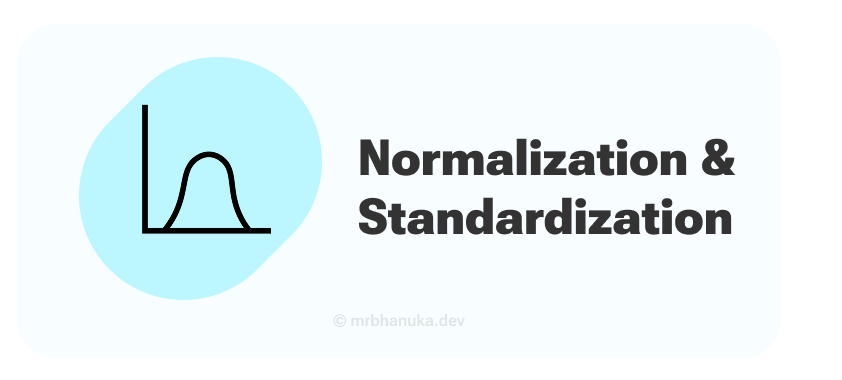
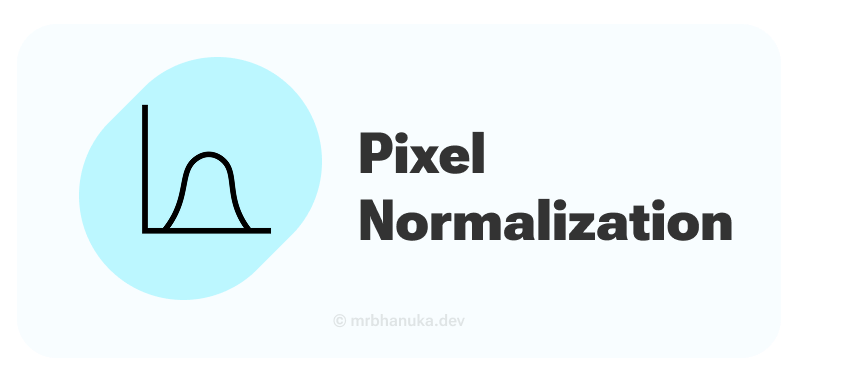
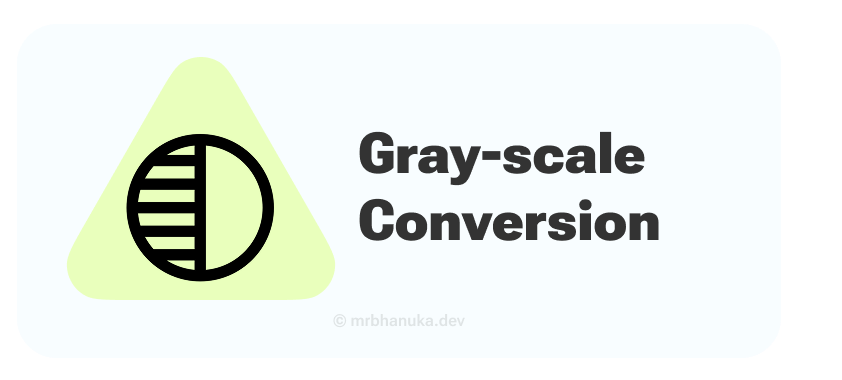

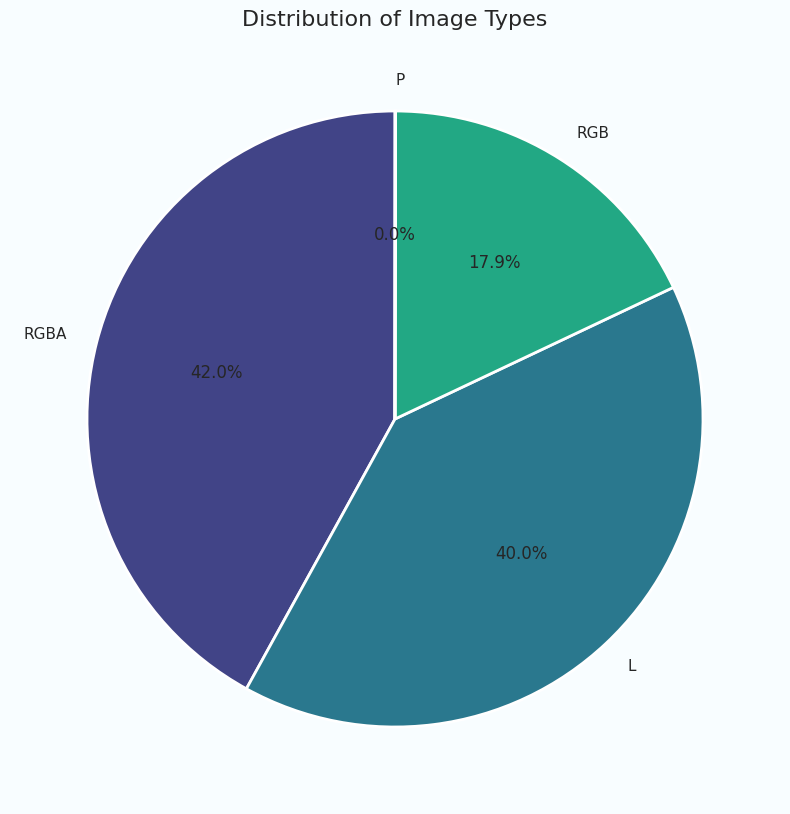

In [29]:
def get_image_type(image_path):
    try:
        with Image.open(image_path) as img:
            return img.mode
    except Exception as e:
        return "Error"

with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    image_types = list(executor.map(get_image_type, manipulated_dataset["IMAGE"]))

image_types_series = pd.Series(image_types)
image_type_counts = image_types_series[image_types_series != "Error"].value_counts()


expanded = sns.color_palette("viridis", len(image_type_counts)).as_hex()
color_map = ListedColormap(expanded, name="m3e")
color_palette = list(color_map.colors)
FIG_BG_COLOR = "#F8FDFF"

plt.figure(figsize=(10, 10), facecolor=FIG_BG_COLOR)
plt.gca().set_facecolor(FIG_BG_COLOR)

plt.pie(
    image_type_counts,
    labels=image_type_counts.index,
    autopct='%1.1f%%',
    colors=color_palette,
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

plt.title('Distribution of Image Types', fontsize=16)

plt.show()

In [30]:
def grayscale_image(img):
    if isinstance(img, (str, bytes)):
        img = Image.open(img)
    img = img.convert("L")
    return img

def transform_image(image: Image.Image) -> Image.Image:
    return grayscale_image(ensure_224_224_by_upscaling(image))

Mode: L
Size (W,H): (224, 224)


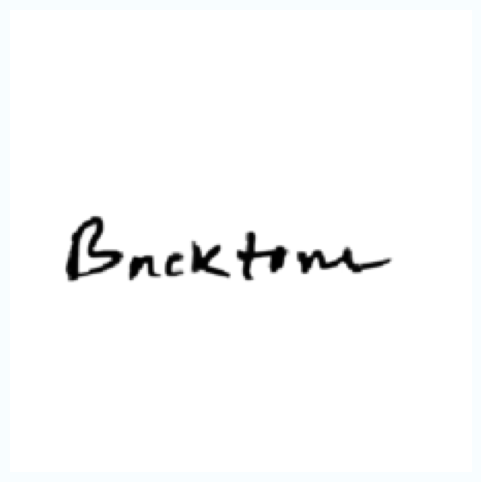

In [31]:
img_path = "/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/104.png"

# Load
img = transform_image(Image.open(img_path))

# Show basic info
print("Mode:", img.mode)
print("Size (W,H):", img.size)

# Display
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.show()

<center>
            <img src="https://github.com/mrbhanukab/Dr.Handwritten_Recognizer/blob/main/static/encoding.webp?raw=true" alt="Lable Encoding" />
</center>
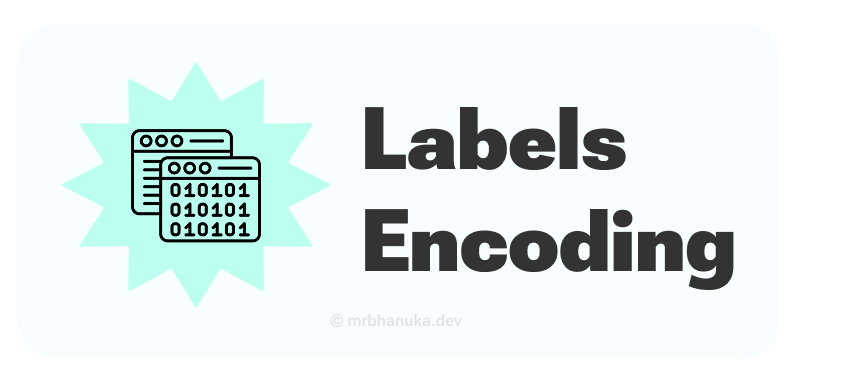

In [32]:
unique_meds = manipulated_dataset[['MEDICINE_NAME', 'GENERIC_NAME']].drop_duplicates()

le = LabelEncoder()
unique_meds['LABEL'] = le.fit_transform(unique_meds['MEDICINE_NAME'])

os.makedirs('out/dataset', exist_ok=True)

display(unique_meds)

unique_meds.to_csv('out/dataset/labels.csv', index=False)

MEDICINE_NAME                GENERIC_NAME  LABEL
0            Aceta                 Paracetamol      1
39             Ace                 Paracetamol      0
79         Alatrol    Cetirizine Hydrochloride      2
118         Amodis               Metronidazole      3
158        Atrizin    Cetirizine Hydrochloride      4
...            ...                         ...    ...
2755       Telfast  Fexofenadine Hydrochloride     73
2792      Tridosil      Azithromycin Dihydrate     74
2832       Trilock          Montelukast Sodium     75
2870         Vifas  Fexofenadine Hydrochloride     76
2908       Zithrin      Azithromycin Dihydrate     77

[78 rows x 3 columns]

<table>
<tr>
    <td>
        <img src="https://github.com/mrbhanukab/Dr.Handwritten_Recognizer/blob/main/static/split.webp?raw=true" alt="Split Dataset" />
    </td>
    <td>
        <h2>Steps:</h2>
        <table>
            <tr>
                <td>
                    <h3>Split Dataset</h3>
                    <ol>
                        <li>Sort and group data in <code>manipulated_dataset</code> by <code>MEDICINE_NAME</code>.</li>
                        <li>Create the <code>SPLIT</code> column in <code>manipulated_dataset</code>.</li>
                        <li>
                            Split each group into:
                            <ul>
                                <li>Training: 60%</li>
                                <li>Testing: 20%</li>
                                <li>Validation: 20%</li>
                            </ul>
                        </li>
                        <li>Update the <code>SPLIT</code> column accordingly.</li>
                    </ol>
                </td>
                <td>
                    <h3>Move Images</h3>
                    <ol>
                        <li>Create the <code>out/dataset</code> directory.</li>
                        <li>Create <code>TRAIN</code>, <code>VALIDATE</code>, and <code>TEST</code> directories inside <code>out/dataset</code>.</li>
                        <li>Apply <code>transform_image</code> to each image.</li>
                        <li>Move each image to the appropriate directory according to its <code>SPLIT</code> value.</li>
                    </ol>
                </td>                
            </tr>
        </table>
    </td>
</tr>
</table>
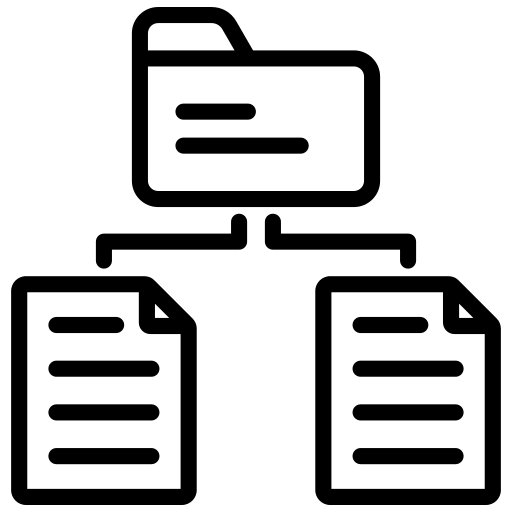
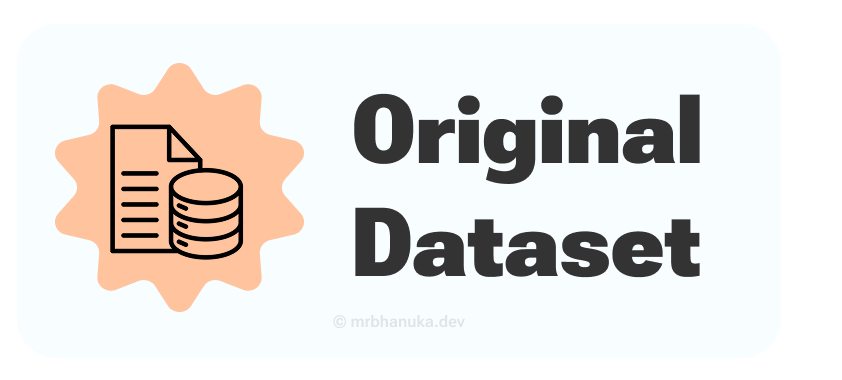
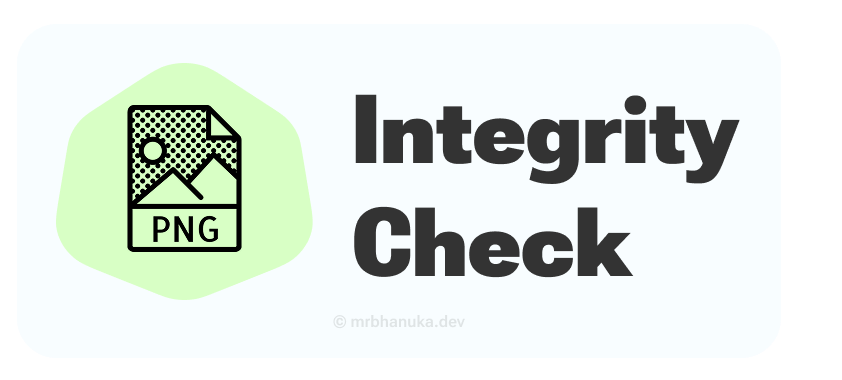
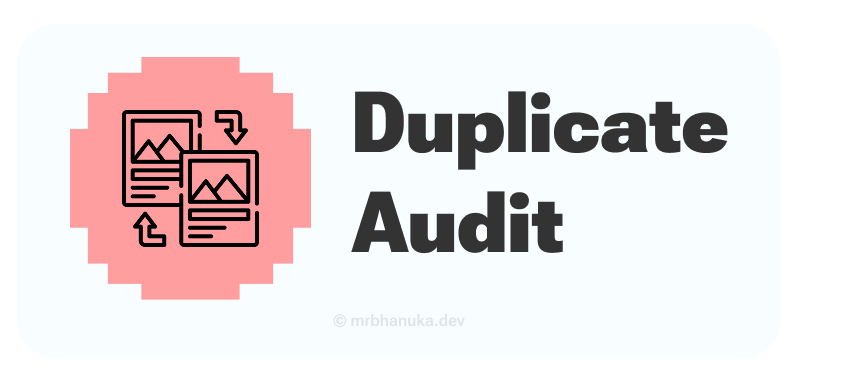
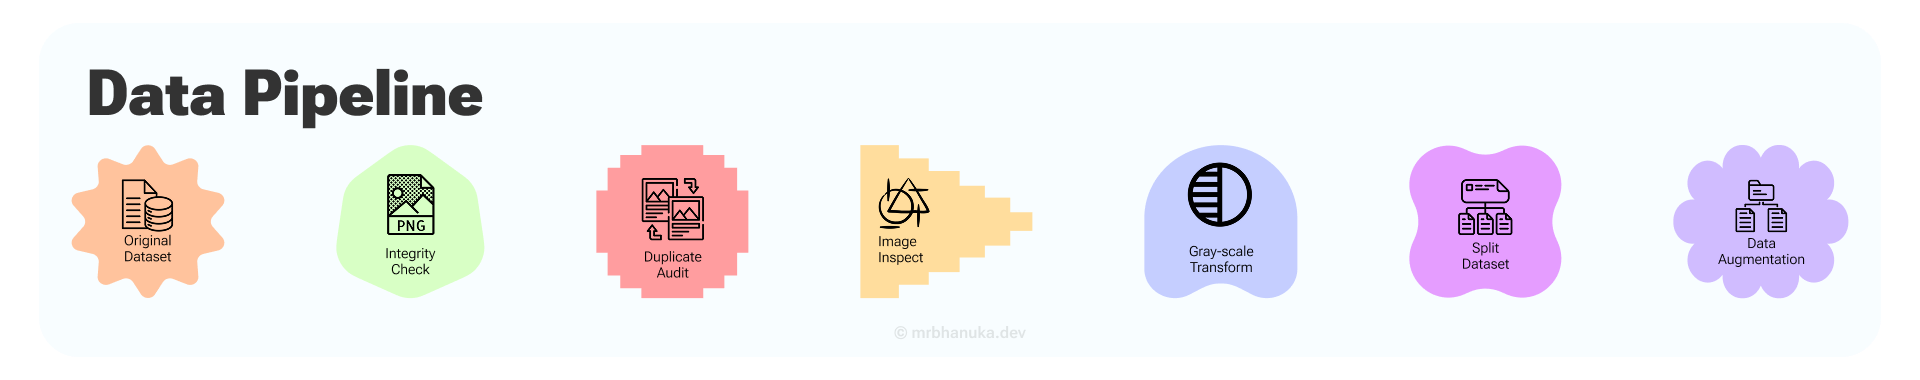
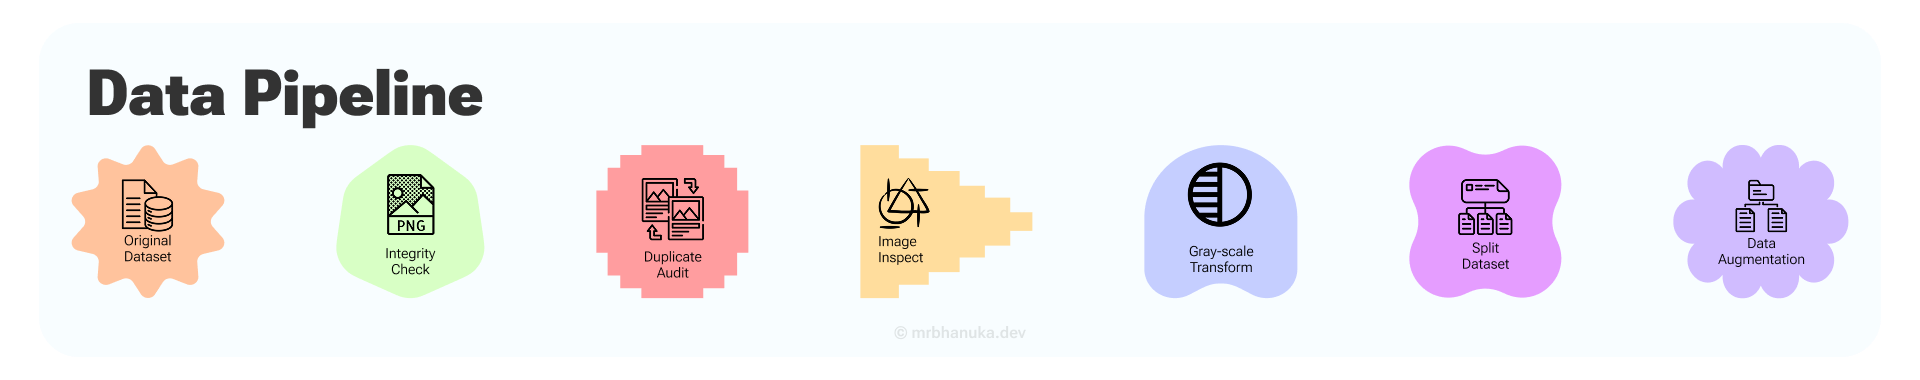
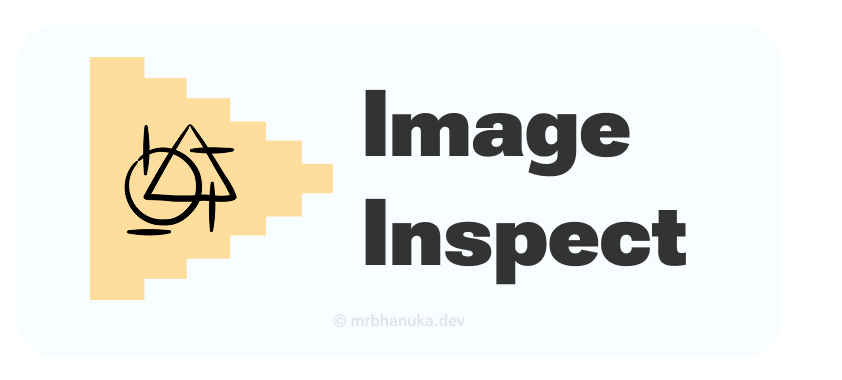
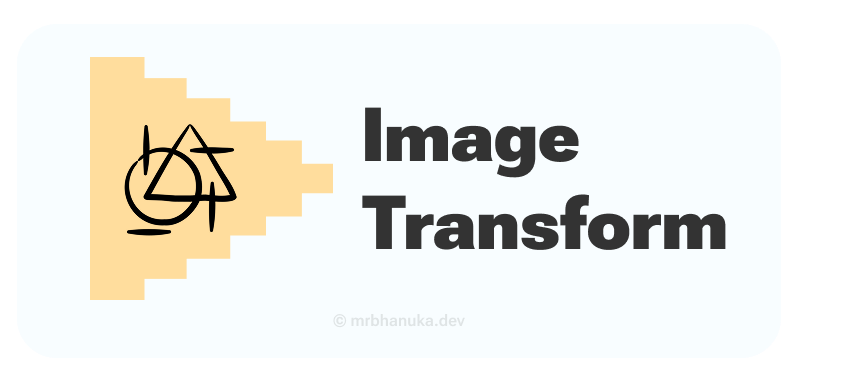
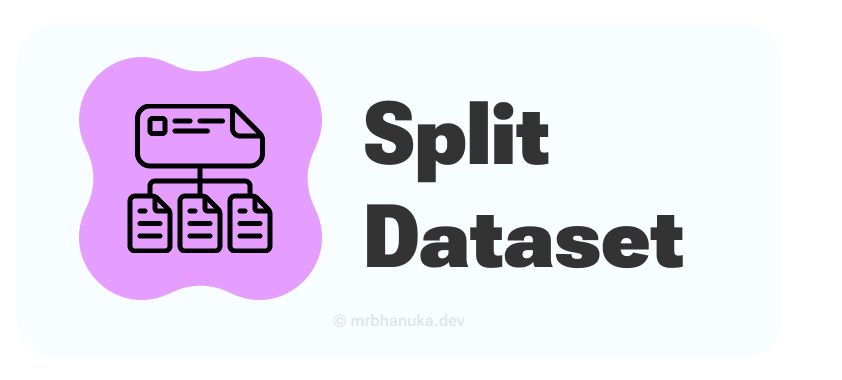

In [33]:
manipulated_dataset = manipulated_dataset.sort_values("MEDICINE_NAME").reset_index(drop=True)

# per-group position (0..n-1) and group size
position = manipulated_dataset.groupby("MEDICINE_NAME").cumcount()
size = manipulated_dataset.groupby("MEDICINE_NAME")["MEDICINE_NAME"].transform("size")

# compute thresholds
train_end = (0.6 * size).astype(int)
val_end = (0.8 * size).astype(int)

# default TEST
manipulated_dataset["SPLIT"] = "TEST"
manipulated_dataset.loc[position < train_end, "SPLIT"] = "TRAIN"
manipulated_dataset.loc[(position >= train_end) & (position < val_end), "SPLIT"] = "VALIDATE"

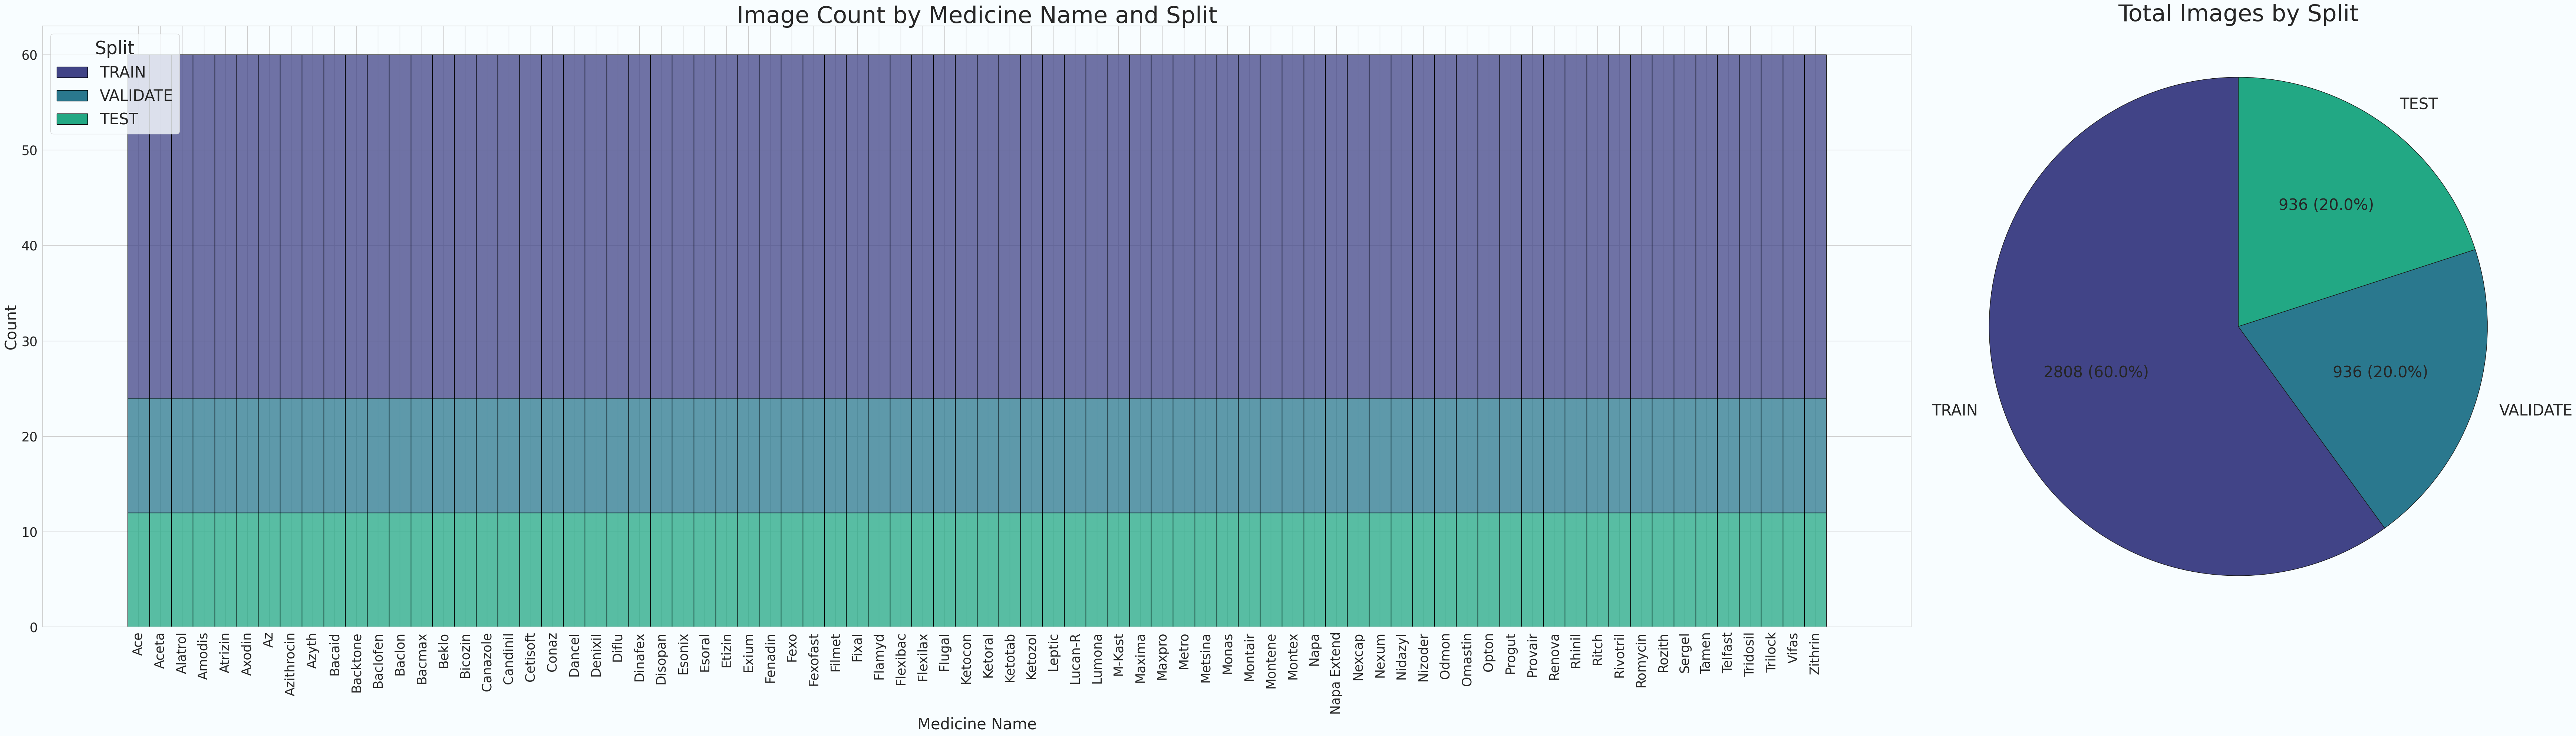

In [34]:
count_data = manipulated_dataset.groupby(['MEDICINE_NAME', 'SPLIT']).size().reset_index(name='COUNT')
totals = manipulated_dataset['SPLIT'].value_counts().reindex(['TRAIN','VALIDATE','TEST']).fillna(0)  # keep order if desired
hue_order = [str(x) for x in totals.index]
palette = sns.color_palette(color_palette, n_colors=len(hue_order))

# Create subplots: 1 row, 2 cols
fig, (ax_hist, ax_pie) = plt.subplots(ncols=2, figsize=(70, 20), gridspec_kw={'width_ratios':[3,1]})
fig.patch.set_facecolor(FIG_BG_COLOR)

# Histogram on left
sns.histplot(data=count_data, x='MEDICINE_NAME', weights='COUNT', hue='SPLIT',
             hue_order=hue_order, multiple='stack', binwidth=1, palette=palette,
             edgecolor='black', ax=ax_hist)
ax_hist.set_title('Image Count by Medicine Name and Split', fontsize=45)
ax_hist.set_xlabel('Medicine Name', fontsize=30)
ax_hist.set_ylabel('Count', fontsize=30)
ax_hist.tick_params(axis='x', rotation=90, labelsize=25)
ax_hist.tick_params(axis='y', labelsize=25)

# Custom legend for consistent labels/colors
handles = [Patch(facecolor=palette[i], edgecolor='black', label=hue_order[i]) for i in range(len(hue_order))]
ax_hist.legend(handles=handles, title='Split', fontsize=30, title_fontsize=35, loc='upper left')

# Pie chart on right
ax_pie.axis('equal')  # circle
wedges, texts, autotexts = ax_pie.pie(totals, labels=totals.index, autopct=lambda p: f"{int(round(p * totals.sum() / 100.0))} ({p:.1f}%)",
                                     startangle=90, colors=palette, wedgeprops=dict(edgecolor='k'), textprops={'fontsize':30})
ax_pie.set_title('Total Images by Split', fontsize=45)

plt.tight_layout()
plt.show()

In [35]:
OUT_ROOT = Path("out/dataset")
SPLIT_NAMES = {"TRAIN", "VALIDATE", "TEST"}
EXPECTED_IMAGES_PER_CLASS = 60  # Expected total across all splits

# --- helpers ---
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def get_hash_filename(src_path: str):
    """Generate a deterministic filename using blake3 hash of the source path"""
    hash_obj = blake3.blake3(src_path.encode())
    return f"{hash_obj.hexdigest()[:16]}.png"

# prepare output root and top-level split dirs
for s in SPLIT_NAMES:
    (OUT_ROOT / s).mkdir(parents=True, exist_ok=True)

# Track processed files to avoid duplicates
processed_files = set()

# Count images per class (across all splits)
class_counts = defaultdict(int)

try:
    # Prepare rows and deterministic order
    logger.info("Sorting and preparing dataset rows...")
    rows = list(manipulated_dataset.to_dict(orient="records"))
    rows.sort(key=lambda r: (r["SPLIT"], r["MEDICINE_NAME"], r["IMAGE"]))
    
    # Thread worker with strict error handling
    def _worker(row):
        src = Path(row["IMAGE"])
        if not src.exists():
            error_msg = f"Source image not found: {src}"
            logger.error(error_msg)
            raise FileNotFoundError(error_msg)
            
        split = str(row["SPLIT"])
        medicine = str(row["MEDICINE_NAME"])
        if split not in SPLIT_NAMES:
            error_msg = f"Unknown split {split} for {src}"
            logger.error(error_msg)
            raise ValueError(error_msg)

        # Create a hash-based filename that's unique to this source file
        hash_filename = get_hash_filename(str(src))
        dest_dir = OUT_ROOT / split / medicine
        ensure_dir(dest_dir)
        dest_path = dest_dir / hash_filename
        
        # Check if we've already processed this file
        if str(src) in processed_files:
            logger.debug(f"Already processed file: {src}")
            return True, str(dest_path), row
            
        # Check if destination already exists
        if dest_path.exists():
            logger.debug(f"File already exists: {dest_path}")
            processed_files.add(str(src))
            return True, str(dest_path), row

        # Perform IO with error handling
        try:
            with Image.open(src) as img:
                # Convert to RGB before transform_image to ensure 3 channels
                img = img.convert("RGB")
                out_img = transform_image(img)
                out_img.save(dest_path, format="PNG")
            
            logger.info(f"Created: {dest_path} from {src}")
            processed_files.add(str(src))
            return True, str(dest_path), row
        except Exception as e:
            error_msg = f"Failed to process {src}: {repr(e)}"
            logger.error(error_msg)
            raise type(e)(error_msg) from e

    # Run with ThreadPoolExecutor and tqdm with strict early termination on errors
    results = []
    logger.info(f"Starting export of {len(rows)} images with {os.cpu_count()} workers")
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as ex:
        futures = {ex.submit(_worker, r): r for r in rows}
        try:
            for fut in tqdm(as_completed(futures), total=len(futures), desc="Exporting"):
                result = fut.result()  # This will raise exception if worker failed
                results.append(result)
                
                # Update class counts after successful processing
                _, _, row = result
                medicine = str(row["MEDICINE_NAME"])
                class_counts[medicine] += 1
        except Exception as e:
            logger.error(f"Processing failed: {e}")
            # Cancel all remaining futures
            for f in futures:
                if not f.done():
                    f.cancel()
            raise  # Re-raise to stop the entire process
            
    # Verify all classes have the expected number of images
    logger.info("Verifying image counts per class")
    issues_found = False
    for medicine, count in class_counts.items():
        if count != EXPECTED_IMAGES_PER_CLASS:
            logger.error(f"Class '{medicine}' has {count} images (expected {EXPECTED_IMAGES_PER_CLASS})")
            issues_found = True
    
    if issues_found:
        error_msg = "Dataset integrity check failed! Some classes don't have exactly 60 images."
        logger.error(error_msg)
        raise Exception("Dataset integrity check failed")
    else:
        logger.info(f"All classes have exactly {EXPECTED_IMAGES_PER_CLASS} images!")

except Exception as e:
    logger.error(f"Processing terminated due to error: {e}")
    raise

logger.info("Processing completed successfully!")

Exporting:   0%|          | 0/4680 [00:00<?, ?it/s]

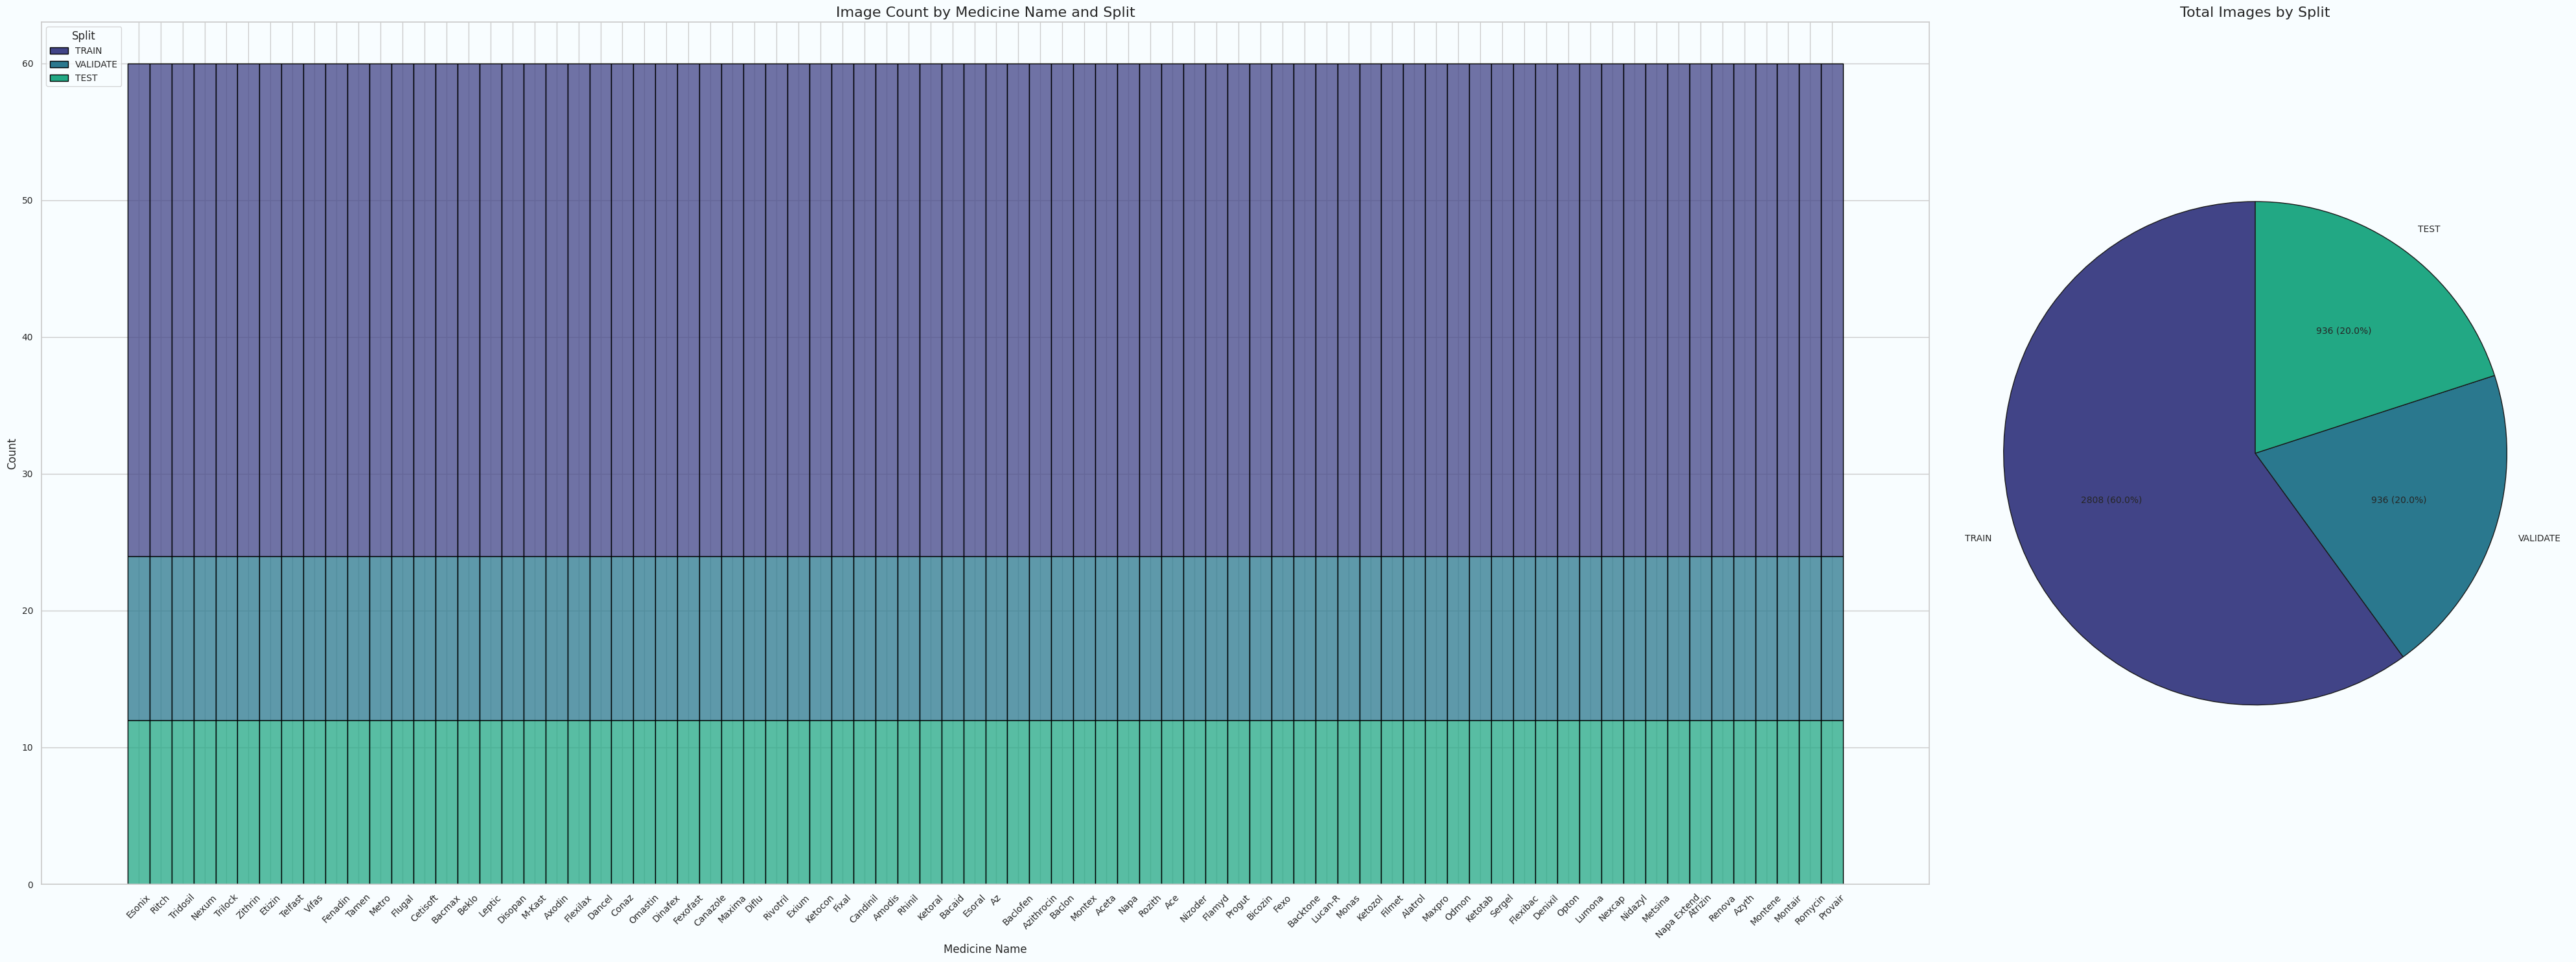

Dataset Summary:
SPLIT
TEST         936
TRAIN       2808
VALIDATE     936
Name: COUNT, dtype: int64

Detailed breakdown:
SPLIT          TEST  TRAIN  VALIDATE
MEDICINE_NAME                       
Ace              12     36        12
Aceta            12     36        12
Alatrol          12     36        12
Amodis           12     36        12
Atrizin          12     36        12
...             ...    ...       ...
Telfast          12     36        12
Tridosil         12     36        12
Trilock          12     36        12
Vifas            12     36        12
Zithrin          12     36        12

[78 rows x 3 columns]


In [36]:
dataset_path = "/kaggle/working/out/dataset"

# Read the file structure and count images
data = []
for split in ['TRAIN', 'VALIDATE', 'TEST']:
    split_path = os.path.join(dataset_path, split)
    if os.path.exists(split_path):
        for medicine_name in os.listdir(split_path):
            medicine_path = os.path.join(split_path, medicine_name)
            if os.path.isdir(medicine_path):
                # Count image files in this directory
                image_count = len([f for f in os.listdir(medicine_path) 
                                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
                data.append({
                    'MEDICINE_NAME': medicine_name,
                    'SPLIT': split,
                    'COUNT': image_count
                })

# Create DataFrame
count_data = pd.DataFrame(data)

# Calculate totals for pie chart
totals = count_data.groupby('SPLIT')['COUNT'].sum().reindex(['TRAIN','VALIDATE','TEST']).fillna(0)
hue_order = [str(x) for x in totals.index]
palette = sns.color_palette(color_palette, n_colors=len(hue_order))

# Create subplots: 1 row, 2 cols
fig, (ax_hist, ax_pie) = plt.subplots(ncols=2, figsize=(40, 15), gridspec_kw={'width_ratios':[3,1]})
fig.patch.set_facecolor(FIG_BG_COLOR)

# Histogram on left
sns.histplot(data=count_data, x='MEDICINE_NAME', weights='COUNT', hue='SPLIT',
             hue_order=hue_order, multiple='stack', binwidth=1, palette=palette,
             edgecolor='black', ax=ax_hist)
ax_hist.set_title('Image Count by Medicine Name and Split', fontsize=16)
ax_hist.set_xlabel('Medicine Name', fontsize=12)
ax_hist.set_ylabel('Count', fontsize=12)
ax_hist.tick_params(axis='x', rotation=45, labelsize=10)
ax_hist.tick_params(axis='y', labelsize=10)

# Custom legend for consistent labels/colors
handles = [Patch(facecolor=palette[i], edgecolor='black', label=hue_order[i]) for i in range(len(hue_order))]
ax_hist.legend(handles=handles, title='Split', fontsize=10, title_fontsize=12, loc='upper left')

# Pie chart on right
ax_pie.axis('equal')  # circle
wedges, texts, autotexts = ax_pie.pie(totals, labels=totals.index, 
                                     autopct=lambda p: f"{int(round(p * totals.sum() / 100.0))} ({p:.1f}%)",
                                     startangle=90, colors=palette, wedgeprops=dict(edgecolor='k'), 
                                     textprops={'fontsize':10})
ax_pie.set_title('Total Images by Split', fontsize=16)

plt.tight_layout()
plt.show()

# Optional: Print summary statistics
print("Dataset Summary:")
print(count_data.groupby('SPLIT')['COUNT'].sum())
print("\nDetailed breakdown:")
print(count_data.pivot(index='MEDICINE_NAME', columns='SPLIT', values='COUNT').fillna(0))

---
# References
<ol>
    <li id="ref1">A. R. Mia, M. A. -A. -S. Chowdhury, A. A. Mamun, A. M. Ruddra and N. T. Tanny, "A Deep Neural Network Approach with Pioneering Local Dataset to Recognize Doctor's Handwritten Prescription in Bangladesh," 2024 International Conference on Advances in Computing, Communication, Electrical, and Smart Systems (iCACCESS), Dhaka, Bangladesh, 2024, pp. 1-6, doi: 10.1109/iCACCESS61735.2024.10499631. keywords: {Handwriting recognition;Adaptation models;Hospitals;Terminology;Machine learning;Data models;Software;Machine Learning;Handwritten Prescription Recognition;Healthcare;Bangladesh;Custom Dataset;Convolutional Neural 
        Networks;Medication Safety;Medical Terminologies}</li>
    <li id="ref2">Abdur Rahim Mia, Abdullah Al Mamun, Abdullah Al Sajid, and Aurunave Mollik Ruddra. (2024). Doctor’s Handwritten Prescription BD dataset [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/8378585</li>
</ol>